# Main Parts

In [1]:
PWD = "TGPXKUD_23Pn"

schema_name = "dbo"
table_name  = "Scorecard_Spark_Model"
# --- connection ---
sql_driver_path = "/home/jovyan/local/msodbcsql18/opt/microsoft/msodbcsql18/lib64/libmsodbcsql-18.3.so.2.1"
sql_server      = r"EDWSQL40.us.lmco.com\SSAPPPRD"
sql_database    = "SubcontractScorecard"
sql_uid         = "ACE_TEAM"
sql_pwd         = "TGPXKUD_23Pn"
model_number    = 10

In [2]:
# ========================================================================
# CORE PYTHON LIBRARIES
# ========================================================================
import os
import re
import gc
import ast
import json
import warnings
from typing import Any, Literal, Optional
from datetime import datetime
from concurrent.futures import ThreadPoolExecutor, as_completed
from dataclasses import dataclass, field
import time
from collections import defaultdict

from sqlalchemy import create_engine, text
from urllib.parse import quote_plus

# =============================================================
# DATA HANDLING + NUMPY
# =============================================================
import numpy as np
import pandas as pd

# =============================================================
# SQL / DATABASE CONNECTIVITY
# =============================================================
import pyodbc

# =============================================================
# MACHINE LEARNING / VECTORIZATION
# =============================================================
import torch
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.metrics import (
    classification_report,
    accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay
)

# ========================================================================
# NLP / TRANSFORMERS / HTML PARSING
# ========================================================================
import spacy
from spacy.cli import download as spacy_download
from bs4 import BeautifulSoup
from bs4 import MarkupResemblesLocatorWarning
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, pipeline
from sentence_transformers import SentenceTransformer

# ========================================================================
# OPTIONAL VISUALIZATION + REQUESTS (for future use)
# ========================================================================
import matplotlib.pyplot as plt
import requests

# ========================================================================
# OPTIONAL LOCAL LIBRARIES (if applicable)
# ========================================================================
from pandas.io.json._table_schema import build_table_schema
from lmdatalink.databases import MSSQLConnection  # Only if needed for other connections

# ========================================================================
# WARNINGS HANDLING
# ========================================================================
warnings.filterwarnings("ignore", category=MarkupResemblesLocatorWarning)
warnings.filterwarnings("ignore", category=FutureWarning, message="DataFrame.applymap has been deprecated.*")
warnings.filterwarnings("ignore", message="pandas only supports SQLAlchemy")
warnings.filterwarnings("ignore", category=DeprecationWarning, message=".*toDlpack.*")

# ========================================================================
# Elastic Search and Transformers
# ========================================================================
from elasticsearch import Elasticsearch
from elasticsearch.helpers import bulk, BulkIndexError, scan
from transformers import AutoTokenizer
import tiktoken

# ========================================================================
# GPT 
# ========================================================================
from openai import OpenAI
from httpx import Client
import openai

df = pd.read_csv("predictions.csv")

SQLCONF = {
    "SERVER": r"EDWSQL40.us.lmco.com\SSAPPPRD",
    "DATABASE": "SubcontractScorecard",
    "UID": "ACE_TEAM",
    # Prefer env var; falls back to hardcoded placeholder if present
    "PWD": PWD,
    "DRIVER_NAME": "ODBC Driver 18 for SQL Server",
    "DRIVER_PATH": "/home/jovyan/local/msodbcsql18/opt/microsoft/msodbcsql18/lib64/libmsodbcsql-18.3.so.2.1",
    "ENCRYPT": "yes",
    "TRUST_SERVER_CERT": "yes",
    "MARS": "yes",
    "CONNECTION_TIMEOUT": 30,
    "LOGIN_TIMEOUT": 30,
}

def _odbc_string(driver_token: str) -> str:
    """Build an ODBC connection string for a given driver token (name or .so path)."""
    return (
        f"DRIVER={{{driver_token}}};"
        f"SERVER={SQLCONF['SERVER']};"
        f"DATABASE={SQLCONF['DATABASE']};"
        f"UID={SQLCONF['UID']};PWD={SQLCONF['PWD']};"
        f"Encrypt={SQLCONF['ENCRYPT']};"
        f"TrustServerCertificate={SQLCONF['TRUST_SERVER_CERT']};"
        f"MARS_Connection={SQLCONF['MARS']};"
        f"Connection Timeout={SQLCONF['CONNECTION_TIMEOUT']};"
        f"Login Timeout={SQLCONF['LOGIN_TIMEOUT']};"
    )

def _make_engine_from_odbc(odbc_str: str):
    """Create a SQLAlchemy engine with fast_executemany enabled."""
    return create_engine(
        f"mssql+pyodbc:///?odbc_connect={quote_plus(odbc_str)}",
        fast_executemany=True,
        pool_pre_ping=True,
    )

def get_engine(verbose: bool = True):
    """
    Try to connect using the named driver first; if that fails,
    fall back to the explicit .so path. Returns a live engine.
    """
    errors = []
    for token in (SQLCONF["DRIVER_NAME"], SQLCONF["DRIVER_PATH"]):
        try:
            odbc_str = _odbc_string(token)
            eng = _make_engine_from_odbc(odbc_str)
            # lightweight test
            with eng.connect() as c:
                c.exec_driver_sql("SELECT 1;")
            if verbose:
                masked_pwd = "***" if SQLCONF["PWD"] else ""
                print(
                    f"[ENGINE OK] Connected via driver token: {token}\n"
                    f"  Server={SQLCONF['SERVER']}  DB={SQLCONF['DATABASE']}  UID={SQLCONF['UID']}  PWD={masked_pwd}\n"
                    f"  Encrypt={SQLCONF['ENCRYPT']} TrustServerCertificate={SQLCONF['TRUST_SERVER_CERT']} MARS={SQLCONF['MARS']}"
                )
            return eng
        except Exception as e:
            errors.append((token, repr(e)))
    # If we got here, both attempts failed
    msg = "\n".join([f" - {tok}: {err}" for tok, err in errors])
    raise RuntimeError(f"Failed to create engine with both driver tokens:\n{msg}")

def quick_sql_diagnostics(engine):
    """Print a few simple diagnostics: server version, current DB/user, and table row count (if accessible)."""
    try:
        with engine.connect() as conn:
            ver = conn.exec_driver_sql("SELECT CAST(SERVERPROPERTY('ProductVersion') AS varchar(50));").scalar()
            dbn = conn.exec_driver_sql("SELECT DB_NAME();").scalar()
            who = conn.exec_driver_sql("SELECT SUSER_SNAME();").scalar()
            print(f"[SQL] Version={ver}  DB={dbn}  Login={who}")
            # Optional: check the target table exists & show row count
            try:
                cnt = conn.exec_driver_sql("SELECT COUNT(*) FROM dbo.Scorecard_Spark_Model;").scalar()
                print(f"[SQL] dbo.Scorecard_Spark_Model rowcount: {cnt}")
            except Exception as e:
                print(f"[SQL] Could not count dbo.Scorecard_Spark_Model: {e}")
    except Exception as e:
        print(f"[SQL DIAG ERROR] {e}")
        raise

# ---- Create a global engine and run a quick test ----
engine = get_engine(verbose=True)
quick_sql_diagnostics(engine)

# Example: minimal round-trip test query
try:
    test_df = pd.read_sql("SELECT TOP (1) * FROM dbo.Scorecard_Spark_Model;", engine)
    print("[TEST] Pulled 1 row from dbo.Scorecard_Spark_Model:")
    display(test_df)  # noqa: F821 (works in Jupyter); replace with print(test_df.head()) if not in notebook
except Exception as e:
    print(f"[TEST] Could not SELECT TOP (1) from dbo.Scorecard_Spark_Model: {e}")


/tmp/ipykernel_22573/3505418554.py:91: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("predictions.csv")


[ENGINE OK] Connected via driver token: /home/jovyan/local/msodbcsql18/opt/microsoft/msodbcsql18/lib64/libmsodbcsql-18.3.so.2.1
  Server=EDWSQL40.us.lmco.com\SSAPPPRD  DB=SubcontractScorecard  UID=ACE_TEAM  PWD=***
  Encrypt=yes TrustServerCertificate=yes MARS=yes
[SQL] Version=14.0.3505.1  DB=SubcontractScorecard  Login=ACE_TEAM
[SQL] dbo.Scorecard_Spark_Model rowcount: 112721
[TEST] Pulled 1 row from dbo.Scorecard_Spark_Model:


Model_Index  Model_Number  Model_Date  Scorecard_Detail_SID Color_Set  \
0           41             0  2024-11-04                     4     YYYYY   

                                 Complete_Main_Words  \
0  slip change notable green light minimal no not...   

   Scorecard_Detail_Note_SID_0  Scorecard_Detail_Note_SID_1  \
0                        28546                        28914   

   Scorecard_Detail_Note_SID_2  Scorecard_Detail_Note_SID_3 Model_Prediction  \
0                        29453                        29933           Yellow   

   Model_Confidence                                  Model_Explanation Latest  \
0            0.9987  Based on the reference notes, I believe the fu...   None   

  Warning  Info  
0    None  None

In [6]:
df = df[df.Archive_Indicator == "N"]

In [7]:
schema_name = "dbo"
table_name  = "Scorecard_Spark_Model"

# assumes `engine` already created
schema_df = pd.read_sql(f"""
SELECT
  c.ORDINAL_POSITION,
  c.COLUMN_NAME,
  c.DATA_TYPE,
  c.CHARACTER_MAXIMUM_LENGTH,
  c.IS_NULLABLE
FROM INFORMATION_SCHEMA.COLUMNS c
WHERE c.TABLE_SCHEMA = '{schema_name}'
  AND c.TABLE_NAME   = '{table_name}'
ORDER BY c.ORDINAL_POSITION
""", engine)

print(schema_df)

    ORDINAL_POSITION                  COLUMN_NAME DATA_TYPE  \
0                  1                  Model_Index       int   
1                  2                 Model_Number       int   
2                  3                   Model_Date   varchar   
3                  4         Scorecard_Detail_SID       int   
4                  5                    Color_Set   varchar   
5                  6          Complete_Main_Words   varchar   
6                  7  Scorecard_Detail_Note_SID_0       int   
7                  8  Scorecard_Detail_Note_SID_1       int   
8                  9  Scorecard_Detail_Note_SID_2       int   
9                 10  Scorecard_Detail_Note_SID_3       int   
10                11             Model_Prediction   varchar   
11                12             Model_Confidence   numeric   
12                13            Model_Explanation   varchar   
13                14                       Latest       int   
14                15                      Warning   var

In [8]:
df["Scorecard_Detail_Note_SID"] = df["SID"]

In [9]:
def build_model5_latest_table(df: pd.DataFrame) -> pd.DataFrame:
    def best_confidence(row: pd.Series) -> float:
        probs = [float(row[c]) for c in ["prob_green","prob_yellow","prob_red"] if c in row and pd.notna(row[c])]
        return max(probs) if probs else np.nan

    def extract_note_sid_from_key(s: pd.Series) -> pd.Series:
        return s.fillna("").astype(str).str.split(".").str[-1].replace("", np.nan)

    # ---------- choose key for "latest" ----------
    key_col = None
    for c in ["sid_key", "last_sid"]:
        if c in df.columns:
            key_col = c
            break
    if key_col is None:
        if {"SID","Note_Year","Note_Month","Scorecard_Detail_Note_SID"}.issubset(df.columns):
            sid_str = df["SID"].astype(int).astype(str).str.zfill(6)
            yr = df["Note_Year"].astype(int).astype(str).str.zfill(4)
            mo = df["Note_Month"].astype(int).astype(str).str.zfill(2)
            note = df["Scorecard_Detail_Note_SID"].astype(int).astype(str).str.zfill(6)
            df = df.assign(_built_sid_key = sid_str + "." + yr + "." + mo + "." + note)
            key_col = "_built_sid_key"
        else:
            raise ValueError("No sid_key/last_sid columns and insufficient parts to construct one.")

    # ---------- latest row per SID ----------
    idx_latest = (
        df.assign(_sortkey=df[key_col].astype(str))
          .groupby("SID")["_sortkey"]
          .idxmax()
    )
    latest = df.loc[idx_latest].copy()
    latest["_Latest"] = True

    # ---------- derived fields ----------
    latest = latest.sort_values(
        ["SID", "Report_Date"] if "Report_Date" in latest.columns else ["SID","Note_Year","Note_Month"]
    ).reset_index(drop=True)
    latest["_Model_Index"] = np.arange(1, len(latest)+1)
    latest["_Model_Number"] = model_number

    if "Report_Date" in latest.columns:
        model_date = pd.to_datetime(latest["Report_Date"], errors="coerce").dt.date
    else:
        y = latest.get("Note_Year")
        m = latest.get("Note_Month")
        model_date = pd.to_datetime(
            y.astype("Int64").astype(str).str.zfill(4) + "-" +
            m.astype("Int64").astype(str).str.zfill(2) + "-01",
            errors="coerce"
        ).dt.date
    latest["_Model_Date"] = model_date

    latest["_Scorecard_Detail_SID"] = latest.get("Scorecard_Detail_Note_SID")
    latest["_Color_Set"] = latest.get("color_set")

    latest["_Complete_Main_Words"] = (
        latest["complete_main_words"] if "complete_main_words" in latest.columns else latest.get("main_words")
    )

    for i in range(4):
        col_key = f"sid_key_{i}"
        out_col = f"_Scorecard_Detail_Note_SID_{i}"
        if col_key in latest.columns:
            latest[out_col] = extract_note_sid_from_key(latest[col_key]).astype("Int64")
        else:
            latest[out_col] = pd.Series([pd.NA]*len(latest), dtype="Int64")

    latest["_Model_Prediction"] = (
        latest["predicted_color"] if "predicted_color" in latest.columns else latest.get("predicted_label")
    )
    latest["_Model_Confidence"] = latest.apply(best_confidence, axis=1)
    latest["_Model_Explanation"] = (
        latest["justification"] if "justification" in latest.columns and latest["justification"].notna().any()
        else latest.get("gpt_justification")
    )

    # ---------- Warning / Info ----------
    latest["_Warning"] = ""
    latest["_Info"] = ""

    # If color_set length < 4, add warning
    if "_Color_Set" in latest.columns:
        mask = latest["_Color_Set"].fillna("").str.len() < 4
        latest.loc[mask, "_Warning"] = "Model predicting with less than 4 prior notes"

    # ---------- final trim ----------
    col_map = {
        "_Model_Index": "Model_Index",
        "_Model_Number": "Model_Number",
        "_Model_Date": "Model_Date",
        "_Scorecard_Detail_SID": "Scorecard_Detail_SID",
        "_Color_Set": "Color_Set",
        "_Complete_Main_Words": "Complete_Main_Words",
        "_Scorecard_Detail_Note_SID_0": "Scorecard_Detail_Note_SID_0",
        "_Scorecard_Detail_Note_SID_1": "Scorecard_Detail_Note_SID_1",
        "_Scorecard_Detail_Note_SID_2": "Scorecard_Detail_Note_SID_2",
        "_Scorecard_Detail_Note_SID_3": "Scorecard_Detail_Note_SID_3",
        "_Model_Prediction": "Model_Prediction",
        "_Model_Confidence": "Model_Confidence",
        "_Model_Explanation": "Model_Explanation",
        "_Latest": "Latest",
        "_Warning": "Warning",
        "_Info": "Info",
    }
    out = latest[list(col_map.keys())].rename(columns=col_map)
    return out

# Example usage (after your `df` is defined):
out_table = build_model5_latest_table(df)

In [10]:
out_table

Model_Index  Model_Number  Model_Date  Scorecard_Detail_SID Color_Set  \
0              1            10  2025-11-01                     4      GGGG   
1              2            10  2025-10-01                     5      YYYY   
2              3            10  2025-10-01                    57      GGGG   
3              4            10  2025-10-01                   171      GGGG   
4              5            10  2025-10-01                   295      RRRR   
..           ...           ...         ...                   ...       ...   
373          374            10  2025-11-01                  3397       GGG   
374          375            10  2025-10-01                  3398         G   
375          376            10  2025-10-01                  3399         G   
376          377            10  2025-11-01                  3400         G   
377          378            10  2025-11-01                  3401         G   

                                   Complete_Main_Words  \
0    award close conclude conclude conclude await b...   
1    drive estimate complete document complete be d...   
2    continue regard 10/14/25 continuing discussion...   
3    associate pende transition track complete rele...   
4    identify approve follow schedule finalize appr...   
..                                                 ...   
373  be know work meet technical irad x-band low-no...   
374                                 release po dow-key   
375  execute release deliver minimize cfm schedule ...   
376  push work pull current current delivery date e...   
377  deliver push -502 service valves -504 service ...   

     Scorecard_Detail_Note_SID_0  Scorecard_Detail_Note_SID_1  \
0                          42232                        42505   
1                          41743                        42216   
2                          41867                        42246   
3                          41463                        41885   
4                          41574                        41575   
..                           ...                          ...   
373                        43141                        43188   
374                        43212                         <NA>   
375                        43245                         <NA>   
376                        43259                         <NA>   
377                        43260                         <NA>   

     Scorecard_Detail_Note_SID_2  Scorecard_Detail_Note_SID_3  \
0                          42899                        43272   
1                          42652                        42892   
2                          42620                        42998   
3                          42278                        42999   
4                          42718                        43039   
..                           ...                          ...   
373                        43295                         <NA>   
374                         <NA>                         <NA>   
375                         <NA>                         <NA>   
376                         <NA>                         <NA>   
377                         <NA>                         <NA>   

    Model_Prediction  Model_Confidence  \
0              Green          0.999999   
1             Yellow          0.999741   
2              Green          0.996871   
3              Green          1.000000   
4                Red          0.974214   
..               ...               ...   
373            Green          0.958054   
374            Green          0.997657   
375            Green          0.999315   
376            Green          0.999431   
377            Green          0.998673   

                                     Model_Explanation  Latest  \
0    The model forecasts a Green rating with 100.00...    True   
1    The model forecasts a Yellow rating with 99.97...    True   
2    The model forecasts a Green rating with 99.69%...    True   
3    The model forecasts a Green rating 

In [11]:
text_types = {"varchar","nvarchar","char","nchar"}

def _sql_maxlen(val):
    """Return None for NULL/NaN/MAX (-1), else an int length."""
    if val is None:
        return None
    # Pandas often gives floats here; treat NaN as None
    if isinstance(val, float) and np.isnan(val):
        return None
    try:
        ival = int(val)
    except Exception:
        return None
    return None if ival == -1 else ival

# Rebuild maps safely from existing `schema_df`
sql_cols   = schema_df["COLUMN_NAME"].tolist()
length_map = {}
for _, r in schema_df.iterrows():
    if r.DATA_TYPE in text_types:
        maxlen = _sql_maxlen(r.CHARACTER_MAXIMUM_LENGTH)
        if maxlen is not None:
            length_map[r.COLUMN_NAME] = maxlen

# (optional) dtype map if you still want it
dtype_map = {r.COLUMN_NAME: r.DATA_TYPE for _, r in schema_df.iterrows()}

def preflight_report(df_pre: pd.DataFrame) -> pd.DataFrame:
    rows = []
    for _, r in schema_df.iterrows():
        col = r.COLUMN_NAME
        sql_type = r.DATA_TYPE
        sql_max  = _sql_maxlen(r.CHARACTER_MAXIMUM_LENGTH)
        row = {
            "COLUMN_NAME": col,
            "SQL_TYPE": sql_type,
            "SQL_MAXLEN": sql_max,
            "DF_PRESENT": col in df_pre.columns,
            "DF_DTYPE": str(df_pre[col].dtype) if col in df_pre.columns else None,
            "DF_MAX_STRLEN": None,
            "OVERFLOW_ROWS": 0,
        }
        if col in df_pre.columns and sql_type in text_types and sql_max is not None:
            s = df_pre[col].dropna().astype(str)
            if not s.empty:
                row["DF_MAX_STRLEN"] = int(s.str.len().max())
                row["OVERFLOW_ROWS"] = int((s.str.len() > sql_max).sum())
        rows.append(row)
    return pd.DataFrame(rows)

# ---- Re-run the preflight on your current data ----
aligned = out_table.reindex(columns=sql_cols)

# Normalize a couple types to match your SQL schema
if "Model_Date" in aligned.columns:
    aligned["Model_Date"] = pd.to_datetime(aligned["Model_Date"], errors="coerce").dt.date.astype("string").fillna(pd.NA)
if "Latest" in aligned.columns:
    aligned["Latest"] = (
        aligned["Latest"]
        .map(lambda x: 1 if (isinstance(x, bool) and x) else (1 if str(x).lower() == "true" else 0) if pd.notna(x) else None)
        .astype("Int64")
    )

preflight_before = preflight_report(aligned)
display(preflight_before)  # Jupyter view

# If you already defined trim functions earlier, you can keep using them:
def forced_trim_with_marker(series: pd.Series, maxlen: int, marker: str = " [TRUNCATED]") -> pd.Series:
    s = series
    if not (pd.api.types.is_string_dtype(s) or s.dtype == "object"):
        s = s.where(s.isna(), s.astype(str))
    too_long = s.notna() & (s.astype(str).str.len() > maxlen)
    if not too_long.any():
        return s
    for m in (marker, " [TRUNC]", " [TR]", "…"):
        if maxlen > len(m):
            base = s.astype(str).str.slice(0, maxlen - len(m))
            return s.where(~too_long, base + m)
    return s.astype(str).str.slice(0, maxlen)

def trim_df_to_schema(df: pd.DataFrame, length_map: dict) -> tuple[pd.DataFrame, dict]:
    out = df.copy()
    trimmed_counts = {}
    for col, maxlen in length_map.items():
        if col not in out.columns:
            continue
        s = out[col]
        s_as_str = s.astype(str).where(s.notna(), s)
        mask = s.notna() & (s_as_str.str.len() > maxlen)
        if mask.any():
            out[col] = forced_trim_with_marker(s, maxlen)
            trimmed_counts[col] = int(mask.sum())
    return out, trimmed_counts

trimmed, trimmed_counts = trim_df_to_schema(aligned, length_map)
if trimmed_counts:
    print("Trimmed columns (rows affected):", trimmed_counts)

preflight_after = preflight_report(trimmed)
display(preflight_after)

COLUMN_NAME SQL_TYPE  SQL_MAXLEN  DF_PRESENT DF_DTYPE  \
0                   Model_Index      int         NaN        True    int64   
1                  Model_Number      int         NaN        True    int64   
2                    Model_Date  varchar        18.0        True   string   
3          Scorecard_Detail_SID      int         NaN        True    int64   
4                     Color_Set  varchar         8.0        True   object   
5           Complete_Main_Words  varchar      4000.0        True   object   
6   Scorecard_Detail_Note_SID_0      int         NaN        True    Int64   
7   Scorecard_Detail_Note_SID_1      int         NaN        True    Int64   
8   Scorecard_Detail_Note_SID_2      int         NaN        True    Int64   
9   Scorecard_Detail_Note_SID_3      int         NaN        True    Int64   
10             Model_Prediction  varchar         8.0        True   object   
11             Model_Confidence  numeric         NaN        True  float64   
12            Model_Explanation  varchar      4000.0        True   object   
13                       Latest      int         NaN        True    Int64   
14                      Warning  varchar      2000.0        True   object   
15                         Info  varchar      2000.0        True   object   

    DF_MAX_STRLEN  OVERFLOW_ROWS  
0             NaN              0  
1             NaN              0  
2            10.0              0  
3             NaN              0  
4             4.0              0  
5         34258.0              3  
6             NaN              0  
7             NaN              0  
8             NaN              0  
9             NaN              0  
10            6.0              0  
11            NaN              0  
12         3017.0              0  
13            NaN              0  
14           45.0              0  
15            0.0              0

Trimmed columns (rows affected): {'Complete_Main_Words': 3}


COLUMN_NAME SQL_TYPE  SQL_MAXLEN  DF_PRESENT DF_DTYPE  \
0                   Model_Index      int         NaN        True    int64   
1                  Model_Number      int         NaN        True    int64   
2                    Model_Date  varchar        18.0        True   string   
3          Scorecard_Detail_SID      int         NaN        True    int64   
4                     Color_Set  varchar         8.0        True   object   
5           Complete_Main_Words  varchar      4000.0        True   object   
6   Scorecard_Detail_Note_SID_0      int         NaN        True    Int64   
7   Scorecard_Detail_Note_SID_1      int         NaN        True    Int64   
8   Scorecard_Detail_Note_SID_2      int         NaN        True    Int64   
9   Scorecard_Detail_Note_SID_3      int         NaN        True    Int64   
10             Model_Prediction  varchar         8.0        True   object   
11             Model_Confidence  numeric         NaN        True  float64   
12            Model_Explanation  varchar      4000.0        True   object   
13                       Latest      int         NaN        True    Int64   
14                      Warning  varchar      2000.0        True   object   
15                         Info  varchar      2000.0        True   object   

    DF_MAX_STRLEN  OVERFLOW_ROWS  
0             NaN              0  
1             NaN              0  
2            10.0              0  
3             NaN              0  
4             4.0              0  
5          4000.0              0  
6             NaN              0  
7             NaN              0  
8             NaN              0  
9             NaN              0  
10            6.0              0  
11            NaN              0  
12         3017.0              0  
13            NaN              0  
14           45.0              0  
15            0.0              0

In [13]:
trimmed.sample().to_dict()

{'Model_Index': {36: 37},
 'Model_Number': {36: 10},
 'Model_Date': {36: '2025-07-01'},
 'Scorecard_Detail_SID': {36: 1483},
 'Color_Set': {36: 'GGGG'},
 'Complete_Main_Words': {36: 'terminate update present sv3 tank updated payment plan the program approval'},
 'Scorecard_Detail_Note_SID_0': {36: 41092},
 'Scorecard_Detail_Note_SID_1': {36: 41391},
 'Scorecard_Detail_Note_SID_2': {36: 41723},
 'Scorecard_Detail_Note_SID_3': {36: 42005},
 'Model_Prediction': {36: 'Green'},
 'Model_Confidence': {36: 0.998099772248271},
 'Model_Explanation': {36: 'The model forecasts a Green rating with 99.81% confidence for SID 1483 on the NEXT GEN OPIR BLOCK 0 program.\n\nThe model likely predicted this outcome due to a combination of proactive issue management, effective communication, and resolution of technical challenges by the vendor LM0053115. Despite encountering several technical issues with the SV2 and SV3 tanks, the vendor has demonstrated a consistent ability to address and mitigate these pr

In [9]:
append_ = True  # set True to load
if append_:
    with engine.connect() as conn:
        before = conn.exec_driver_sql("SELECT COUNT(*) FROM dbo.Scorecard_Spark_Model").scalar()
    trimmed.to_sql(name="Scorecard_Spark_Model", schema="dbo", con=engine, if_exists="append", index=False, chunksize=1000)
    with engine.connect() as conn:
        after = conn.exec_driver_sql("SELECT COUNT(*) FROM dbo.Scorecard_Spark_Model").scalar()
    print(f"Append complete. Rows before: {before}, after: {after}, appended: {after - before}.")
else:
    print("Dry run complete. Set append_ = True to load rows.")


Append complete. Rows before: 111504, after: 112721, appended: 1217.


In [14]:
aligned["Last_Color"] = aligned["Color_Set"].apply(lambda x: x[-1])
aligned["Prediction_Diff"] = (aligned["Model_Prediction"].str[0] != aligned["Last_Color"].str[0]).astype(int)
aligned["Flagged"] = (aligned["Model_Confidence"] < .75) | (aligned["Prediction_Diff"] == 1)
aligned[aligned["Flagged"] == True].sample().T.to_dict()

{133: {'Model_Index': 134,
  'Model_Number': 10,
  'Model_Date': '2025-10-01',
  'Scorecard_Detail_SID': 2940,
  'Color_Set': 'GGGG',
  'Complete_Main_Words': 'ship pende start hold definitize receive use notify consider shut impact work draft own need go come grant incorporate avoid recover impact precede financial more potential alternate cross cumulative historical cumulative strong due rocket motor build status 13 srm sets date 1 srm shipment all baseline zumwalt motors production uca motors (clin 6022) cases production qpmr program status clin uca all long lead material mar. enka materials provider rayon that nozzles ngsc srms us they financial crisis this an issue that lm / ngsc potential paths i. e. lifetime buys alternate suppliers risk rfniu contract ownership tooling the cps program tooling wsi a transfer/contract vehicle wsi an end pop extension wsi cross utilization risk performance status cumulative spi historical delays preceding development contract cumulative cpi all cl


== Global Summary: Predicted Color Counts (Not Flagged vs Flagged) ==
Pred_Color     G   Y  R
Flagged                
Not Flagged  294  35  7
Flagged       23  18  1

== Confidence Summary ==
             count    mean  median     min  max
Flagged                                        
Not Flagged    336  0.9838  0.9991  0.7761  1.0
Flagged         42  0.7477  0.7091  0.5008  1.0

== Movement Summary ==
            Move_Changes            Move_Steps           
                    mean median max       mean median max
Flagged                                                  
Not Flagged        0.104    0.0   2      0.104    0.0   2
Flagged            0.167    0.0   2      0.214    0.0   2

== Low-History Counts ==
Low_History  Sufficient History  Low History
Flagged                                     
Not Flagged                 282           54
Flagged                      25           17

== Upgrade / Match / Downgrade Counts ==
Pred_vs_Last  Downgrade  Match  Upgrade
Flagged      

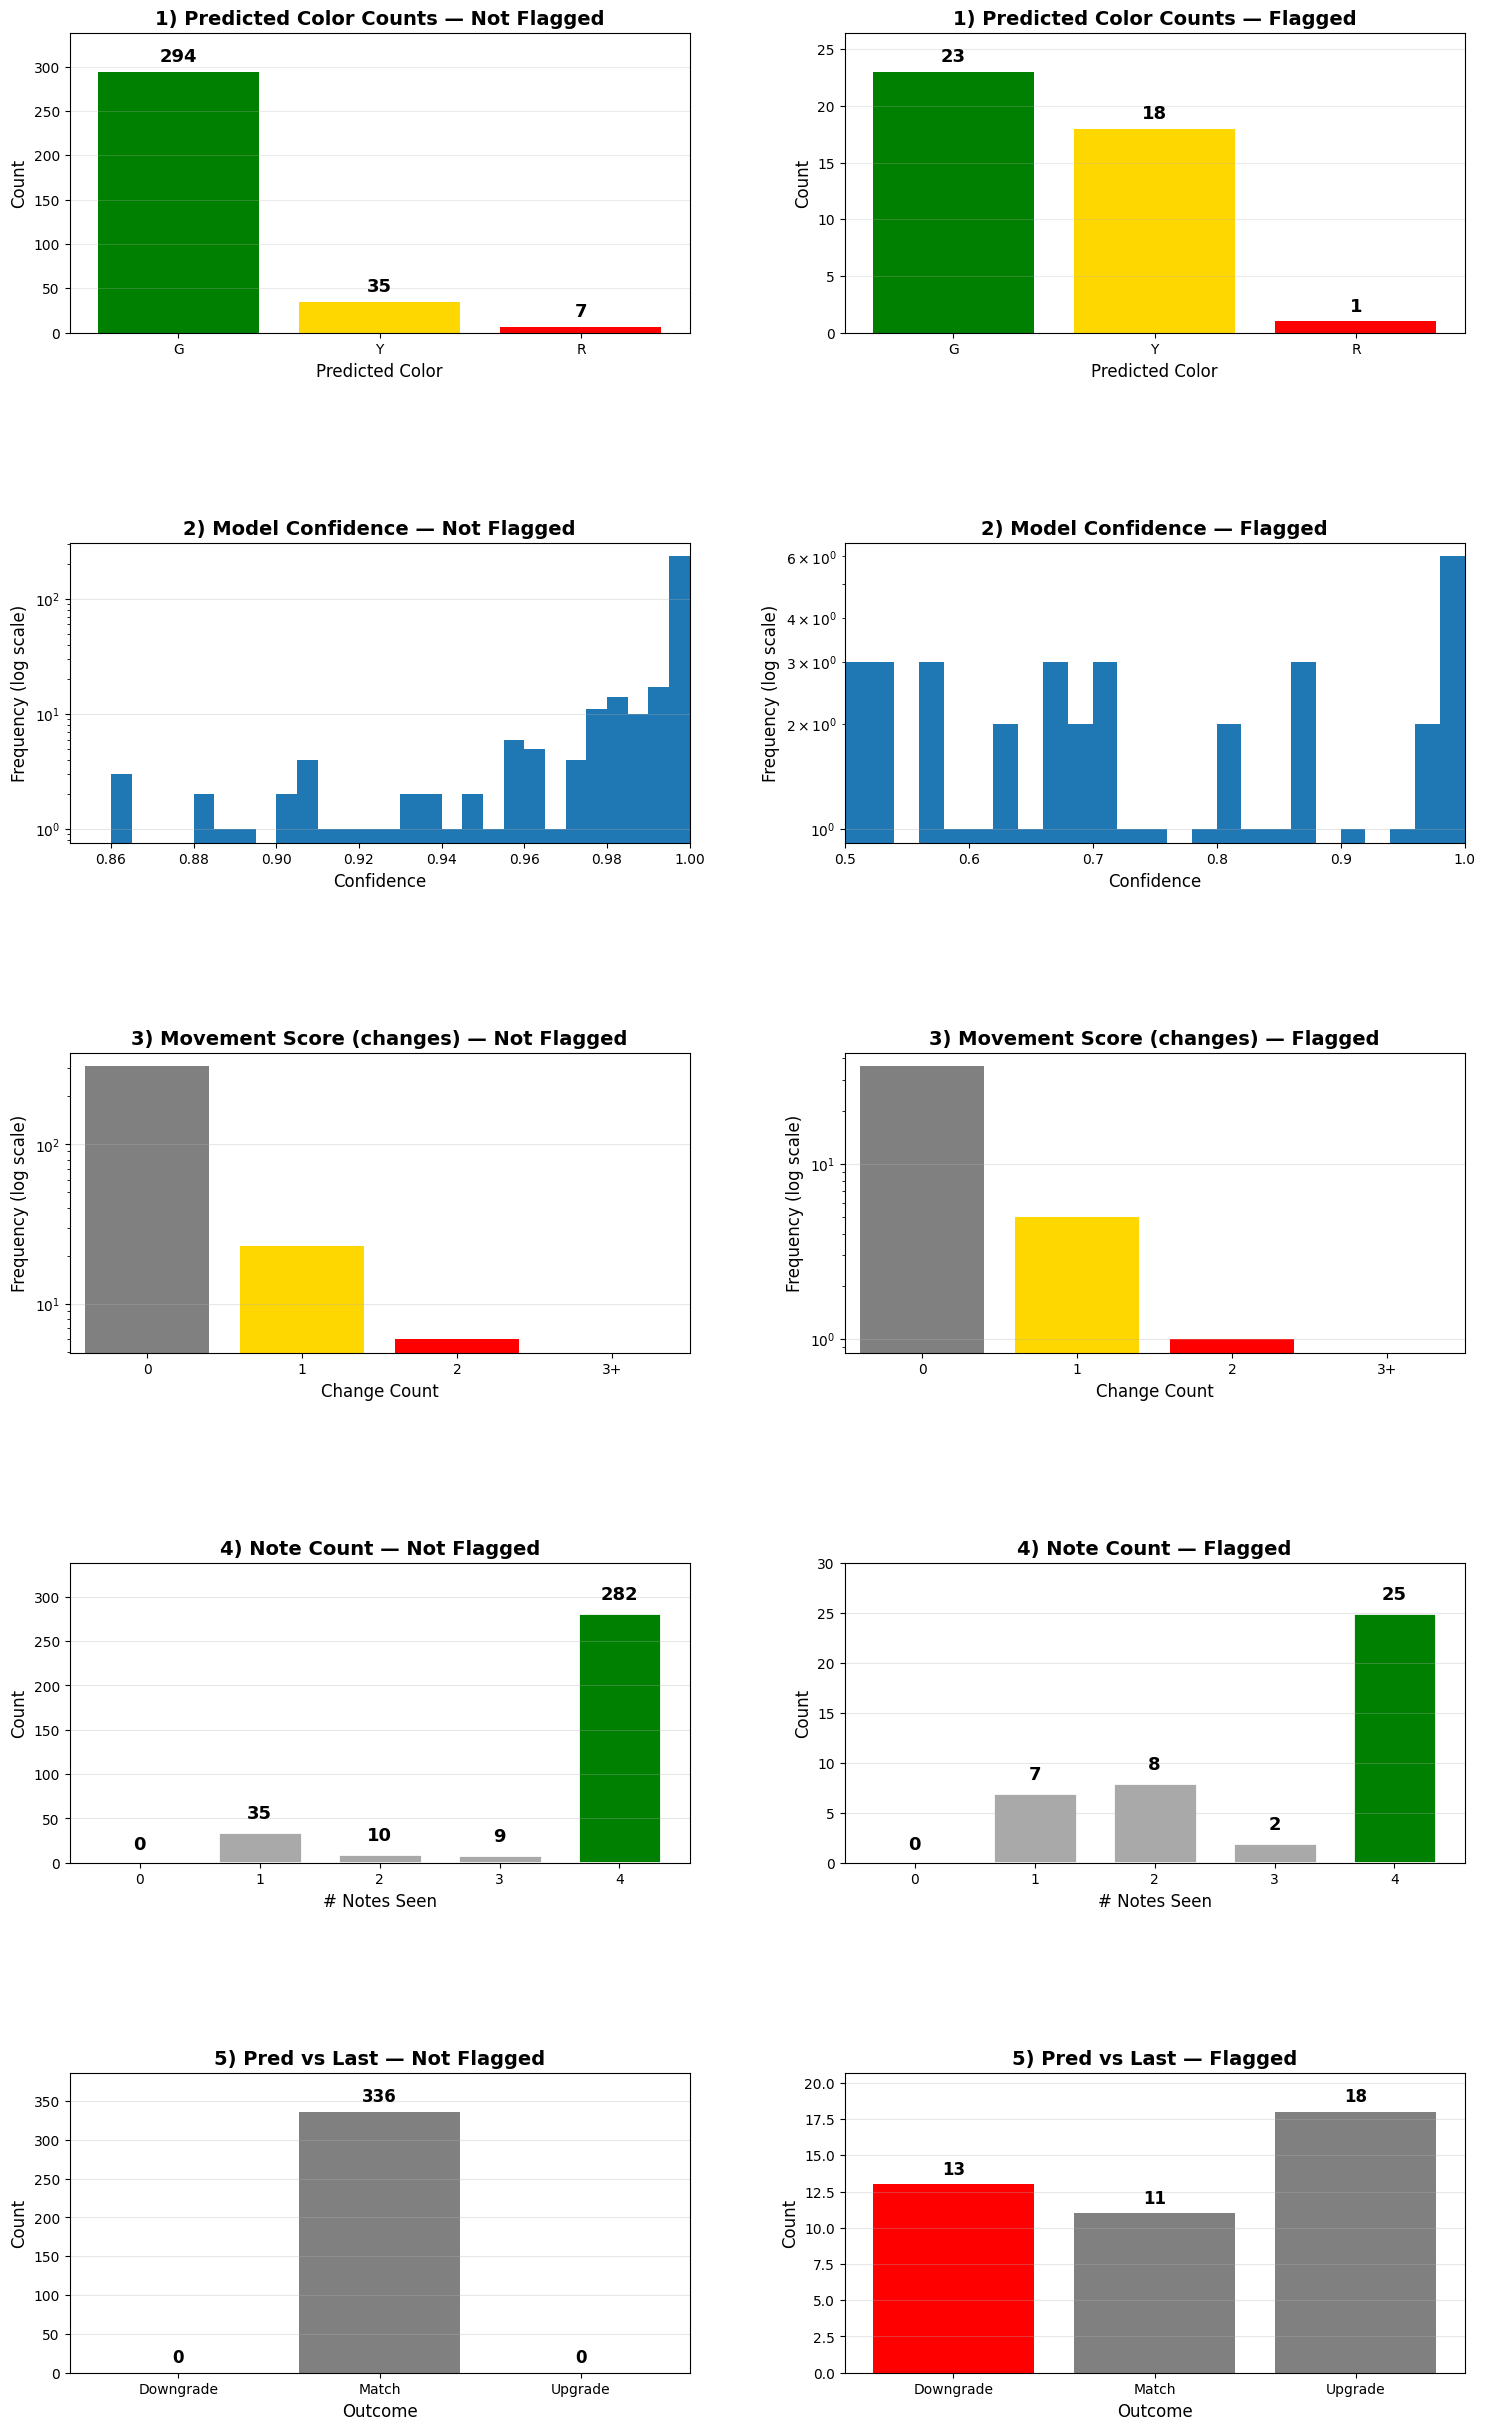

In [15]:
# ==== Global Count Summary + 5×2 Dashboard (UPDATED spacing & styling) =======
# Assumes `aligned` exists and:
# aligned["Flagged"] = (aligned["Model_Confidence"] < .75) | (aligned["Prediction_Diff"] == 1)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df = aligned.copy()

# -------------------- Derivations / helpers ----------------------------------

# 1) Normalize predicted color to single letter (e.g., "Green" -> "G")
df["Pred_Color"] = df["Model_Prediction"].astype(str).str[0].str.upper()

# 2) Movement metrics from Color_Set
COLOR_MAP = {"G": 0, "Y": 1, "R": 2}

def movement_metrics(color_set: str) -> tuple[int, int]:
    s = [c for c in (color_set or "") if c in COLOR_MAP]
    if len(s) <= 1:
        return 0, 0
    nums  = [COLOR_MAP[c] for c in s]
    diffs = np.diff(nums)
    # change_count: count of transitions where the letter changes
    change_count = int(np.sum(np.array(s[1:]) != np.array(s[:-1])))
    # step_sum: captures distance (G<->R = 2, G<->Y = 1, etc.)
    step_sum = int(np.sum(np.abs(diffs)))
    return change_count, step_sum

mm = df["Color_Set"].apply(movement_metrics)
df["Move_Changes"] = mm.apply(lambda t: t[0])
df["Move_Steps"]   = mm.apply(lambda t: t[1])

# 3) Note count (how many non-null note columns)
note_cols = [c for c in df.columns if c.startswith("Scorecard_Detail_Note_SID_")]
df["Note_Count"] = df[note_cols].notna().sum(axis=1)

# 4) Low-history flag (example: fewer than 4 notes)
df["Low_History"] = (df["Note_Count"] < 4).astype(int)

# 5) Upgrade / Match / Downgrade vs last color
def compare_trend(last_c, pred_c):
    if pd.isna(last_c) or pd.isna(pred_c):
        return "N/A"
    a = COLOR_MAP.get(str(last_c)[0].upper(), None)
    b = COLOR_MAP.get(str(pred_c)[0].upper(), None)
    if a is None or b is None:
        return "N/A"
    delta = b - a
    if delta < 0:  return "Upgrade"
    if delta > 0:  return "Downgrade"
    return "Match"

df["Pred_vs_Last"] = [compare_trend(lc, pc) for lc, pc in zip(df["Last_Color"], df["Pred_Color"])]

# 6) Subsets
left  = df[~df["Flagged"]]   # Not Flagged
right = df[df["Flagged"]]    # Flagged

# 7) Utilities
color_order = ["G", "Y", "R"]
def bar_color_for(letter): return {"G":"green","Y":"gold","R":"red"}.get(letter, "gray")

# -------------------- (Optional) Global count summary tables -----------------
pred_counts = (pd.crosstab(df["Flagged"], df["Pred_Color"])
               .reindex(columns=color_order, fill_value=0)
               .rename(index={False:"Not Flagged", True:"Flagged"}))

conf_summary = (df.groupby("Flagged")["Model_Confidence"]
                .agg(["count","mean","median","min","max"])
                .rename(index={False:"Not Flagged", True:"Flagged"}))

move_summary = (df.groupby("Flagged")[["Move_Changes","Move_Steps"]]
                .agg(["mean","median","max"])
                .rename(index={False:"Not Flagged", True:"Flagged"}))

lowhist_counts = (pd.crosstab(df["Flagged"], df["Low_History"])
                  .rename(columns={0:"Sufficient History",1:"Low History"})
                  .rename(index={False:"Not Flagged", True:"Flagged"}))

trend_counts = (pd.crosstab(df["Flagged"], df["Pred_vs_Last"])
                .reindex(columns=["Downgrade","Match","Upgrade"], fill_value=0)
                .rename(index={False:"Not Flagged", True:"Flagged"}))

print("\n== Global Summary: Predicted Color Counts (Not Flagged vs Flagged) ==")
print(pred_counts)
print("\n== Confidence Summary ==")
print(conf_summary.round(4))
print("\n== Movement Summary ==")
print(move_summary.round(3))
print("\n== Low-History Counts ==")
print(lowhist_counts)
print("\n== Upgrade / Match / Downgrade Counts ==")
print(trend_counts)

# ========================= 5×2 Dashboard ====================================
# Bigger figure + more whitespace between plots
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(18, 26))
plt.subplots_adjust(hspace=0.7, wspace=0.25, top=0.95, bottom=0.05)

title_font = dict(fontsize=14, fontweight="bold")
label_font = dict(fontsize=12)

# ---------------- Row 1: Predicted color counts (R/Y/G) ----------------------
for j, subset in enumerate([left, right]):
    ax = axes[0, j]
    counts = subset["Pred_Color"].value_counts().reindex(color_order, fill_value=0)
    bars = ax.bar(counts.index, counts.values, color=[bar_color_for(c) for c in counts.index])
    ax.set_title(f"1) Predicted Color Counts — {'Not Flagged' if j==0 else 'Flagged'}", **title_font)
    ax.set_xlabel("Predicted Color", **label_font)
    ax.set_ylabel("Count", **label_font)
    # add headroom for labels
    ymax = max(counts.values) * 1.15 if len(counts) else 1
    ax.set_ylim(0, ymax)
    for b in bars:
        ax.text(
            b.get_x() + b.get_width()/2, 
            b.get_height() + (ymax * 0.02),
            f"{int(b.get_height())}",
            ha="center", va="bottom",
            fontsize=13, fontweight="bold"
        )
    ax.grid(True, axis="y", alpha=0.25)

# ---------------- Row 2: Model confidence histograms (both log y) -----------
def plot_conf_hist(ax, series, title, flagged=False):
    s = series.dropna()
    if flagged:
        bins = np.linspace(0.5, 1.0, 26)
        ax.set_xlim(0.5, 1.0)
    else:
        bins = np.linspace(0.85, 1.0, 31)
        ax.set_xlim(0.85, 1.0)
    ax.hist(s, bins=bins)
    ax.set_yscale("log")  # <-- both logarithmic
    ax.set_title(title, **title_font)
    ax.set_xlabel("Confidence", **label_font)
    ax.set_ylabel("Frequency (log scale)", **label_font)
    ax.grid(True, axis="y", alpha=0.3)

plot_conf_hist(axes[1, 0], left["Model_Confidence"],  "2) Model Confidence — Not Flagged", flagged=False)
plot_conf_hist(axes[1, 1], right["Model_Confidence"], "2) Model Confidence — Flagged",     flagged=True)

# ---------------- Row 3: Movement score (changes) — log y & colored bars ----
def movement_capped(series):
    x = series.fillna(0).astype(int).to_numpy()
    return np.where(x > 3, 3, x)  # cap at 3 => "3+"

for j, subset in enumerate([left, right]):
    ax = axes[2, j]
    x = movement_capped(subset["Move_Changes"])
    # counts for bins 0,1,2,3+
    vals = np.bincount(x, minlength=4)
    xticks = [0,1,2,3]
    colors = ["gray", "gold", "red", "red"]  # 0=gray, 1=yellow, 2=red, 3+=red
    bars = ax.bar(xticks, vals, color=colors)
    ax.set_yscale("log")
    ax.set_title(f"3) Movement Score (changes) — {'Not Flagged' if j==0 else 'Flagged'}", **title_font)
    ax.set_xlabel("Change Count", **label_font)
    ax.set_ylabel("Frequency (log scale)", **label_font)
    ax.set_xticks(xticks, ["0", "1", "2", "3+"])
    ax.set_xlim(-0.5, 3.5)
    ax.grid(True, axis="y", alpha=0.3)

# ---------------- Row 4: Note count — spaced bars, custom colors, bold lbls --
# We know there are 4 note columns -> counts 0..4
def plot_note_counts(ax, subset, title):
    counts = subset["Note_Count"].fillna(0).astype(int).value_counts().reindex(range(0, 5), fill_value=0)
    # colors for bars: 0 gray, 1 gray, 2 gray, 3 gray, 4 green
    bar_colors = ["#A9A9A9", "#A9A9A9", "#A9A9A9", "#A9A9A9", "green"]
    # add spacing by using smaller bar width and edgecolor
    bars = ax.bar(counts.index, counts.values, color=bar_colors, width=0.7, edgecolor="white", linewidth=2)
    ax.set_title(title, **title_font)
    ax.set_xlabel("# Notes Seen", **label_font)
    ax.set_ylabel("Count", **label_font)
    ax.set_xticks(range(0, 5), ["0","1","2","3","4"])
    ymax = max(counts.values) * 1.2 if counts.sum() else 1
    ax.set_ylim(0, ymax)
    ax.grid(True, axis="y", alpha=0.3)
    # big, bold counts over the bars
    for b in bars:
        ax.text(
            b.get_x() + b.get_width()/2,
            b.get_height() + (ymax * 0.03),
            f"{int(b.get_height())}",
            ha="center", va="bottom",
            fontsize=13, fontweight="bold"
        )

plot_note_counts(axes[3, 0], left,  "4) Note Count — Not Flagged")
plot_note_counts(axes[3, 1], right, "4) Note Count — Flagged")

# ---------------- Row 5: Upgrade / Match / Downgrade bars (red for down) ----
for j, subset in enumerate([left, right]):
    ax = axes[4, j]
    order  = ["Downgrade","Match","Upgrade"]
    counts = subset["Pred_vs_Last"].value_counts().reindex(order, fill_value=0)
    colors = ["red", "gray", "gray"]  # Downgrade red; others gray
    bars = ax.bar(order, counts.values, color=colors)
    ax.set_title(f"5) Pred vs Last — {'Not Flagged' if j==0 else 'Flagged'}", **title_font)
    ax.set_xlabel("Outcome", **label_font)
    ax.set_ylabel("Count", **label_font)
    ymax = max(counts.values) * 1.15 if counts.sum() else 1
    ax.set_ylim(0, ymax)
    for b in bars:
        ax.text(b.get_x()+b.get_width()/2, b.get_height() + (ymax * 0.02),
                f"{int(b.get_height())}", ha="center", va="bottom",
                fontsize=12, fontweight="bold")
    ax.grid(True, axis="y", alpha=0.3)

plt.savefig("global_summary_dashboard.png", dpi=400, bbox_inches="tight")

plt.show()


In [16]:
df.sample().T

231
Model_Index                                                                232
Model_Number                                                                10
Model_Date                                                          2025-09-01
Scorecard_Detail_SID                                                      3192
Color_Set                                                                 GGGG
Complete_Main_Words          complete production activities schedule comple...
Scorecard_Detail_Note_SID_0                                              36618
Scorecard_Detail_Note_SID_1                                              40202
Scorecard_Detail_Note_SID_2                                              41268
Scorecard_Detail_Note_SID_3                                              42534
Model_Prediction                                                         Green
Model_Confidence                                                      0.997368
Model_Explanation            The model forecasts a Green rating with 99.74%...
Latest                                                                       1
Warning                                                                       
Info                                                                          
Last_Color                                                                   G
Prediction_Diff                                                              0
Flagged                                                                  False
Pred_Color                                                                   G
Move_Changes                                                                 0
Move_Steps                                                                   0
Note_Count                                                                   4
Low_History                                                                  0
Pred_vs_Last                                                             Match

In [19]:
flaggers = df[['Scorecard_Detail_SID',
    'Scorecard_Detail_Note_SID_0',
    'Scorecard_Detail_Note_SID_1',
    'Scorecard_Detail_Note_SID_2',
    'Scorecard_Detail_Note_SID_3', 
    'Model_Prediction', 
    'Model_Confidence',
    'Warning',
    'Model_Explanation',
    'Flagged',
    'Pred_vs_Last']][df['Flagged'] == 1].copy()

In [20]:
# Scorecard_Detail_SID this is last note, please change it ASAP @@@
# predicted / current / active sids (confusion matrix ~ not predict kind)
# Current model accuracy
flaggers.sample().T.to_dict()

{352: {'Scorecard_Detail_SID': 3366,
  'Scorecard_Detail_Note_SID_0': 43008,
  'Scorecard_Detail_Note_SID_1': None,
  'Scorecard_Detail_Note_SID_2': None,
  'Scorecard_Detail_Note_SID_3': None,
  'Model_Prediction': 'Green',
  'Model_Confidence': 0.8798049231308004,
  'Warning': 'Model predicting with less than 4 prior notes',
  'Model_Explanation': "The model forecasts a Green rating with 87.98% confidence for SID 3366 on the SOUTHPAN program.\n\nThe model likely predicted this positive outcome due to several factors evident in the recent note history. Firstly, despite the delays in the GRS install schedule, there are clear indications of ongoing recovery efforts. The note [003366.2025.10.043008] highlights that installations are now underway, which opens up opportunities for the vendor to catch up on the delayed milestones. This proactive approach to addressing the delays likely contributed to the model's confidence in a favorable performance rating.\n\nSecondly, the vendor has outli

In [21]:
flaggers.to_csv("flagged.csv")

In [22]:
def display_one_note(row: pd.Series) -> None:
    sid = row.get("Scorecard_Detail_SID", "unknown")
    color = row.get("Model_Prediction", "Unknown").title()
    confidence = f"{100 * row.get('Model_Confidence', 0):.1f}%"
    justification = row.get("Model_Explanation", "").strip()
    grade = row.get("Pred_vs_Last", "unknown")
    if color == "Red": style = '<hr style="border-top: 3px double red;">'
    elif color == "Yellow": style = '<hr style="border-top: 3px double yellow;">'
    else: style = '<hr style="border-top: 3px double green;">'
    
    md = f"""
{style}

**Scorecard_Detail_SID**: `{sid}`   **Predicted Rating**: **{color}**  

---

**Model Confidence**  
- **Confidence**: {confidence}  
- **Change**: {grade}

{style}


**GPT Justification**  
{justification}

---
"""
    display(Markdown(md))


In [23]:
from IPython.display import Markdown

display_one_note(flaggers.iloc[7
                              ].T)


<hr style="border-top: 3px double yellow;">

**Scorecard_Detail_SID**: `2546`   **Predicted Rating**: **Yellow**  

---

**Model Confidence**  
- **Confidence**: 56.3%  
- **Change**: Upgrade

<hr style="border-top: 3px double yellow;">


**GPT Justification**  
The model forecasts a Yellow rating with 56.29% confidence for SID 2546 on the ORION OPOC program, involving vendor LM0022330. This prediction likely stems from a combination of recurring technical challenges, schedule delays, and coordination issues observed in recent performance notes.

Firstly, the vendor has faced significant technical challenges, particularly with the telemetry board design and battery assembly. For instance, in Note 038399, there was an error in the telemetry board design, leading to a schedule impact of approximately 11 weeks. This issue persisted, as highlighted in Note 042604, where the root cause of a battery failure was identified as an intra-battery short circuit due to insufficient design clearances. These recurring technical issues indicate a pattern of design and manufacturing problems that could undermine the vendor's ability to meet project deadlines reliably.

Secondly, schedule delays have been a consistent issue. In Note 038475, the delivery schedule for the telemetry boards was pushed back, impacting the overall project timeline. Similarly, Note 042604 details a significant delay of around seven months due to the need for corrective actions following the battery failure. These delays suggest that the vendor struggles with maintaining the project schedule, which contributes to the model's prediction of a Yellow rating.

Lastly, coordination challenges between the vendor and its sub-tier suppliers have also been evident. For example, in Note 038399, the vendor had to work closely with its sub-tier supplier, Irvine, to validate the design and expedite the delivery of substrates. This dependency on sub-tier suppliers and the need for constant coordination to address issues further complicates the project management and increases the risk of delays.

Comparing this to the vendor's performance on other programs, similar issues are observed. For instance, in SID 003211, Note 042289, delivery delays were reported due to pending Navy approval and coordination with a sub-tier supplier, MAPP. Additionally, in SID 002675, Note 043003, production was on track, but testing delays due to environmental requirements impacted the schedule. These patterns of technical issues, schedule delays, and coordination challenges across different programs reinforce the model's prediction of a Yellow rating for SID 2546.

In conclusion, the model's forecast of a Yellow rating with 56.29% confidence for SID 2546 on the ORION OPOC program is likely due to the vendor's recurring technical challenges, consistent schedule delays, and coordination issues with sub-tier suppliers. These factors collectively contribute to a moderate performance risk for the contract line.

---


In [24]:
# # This cell defines utilities to:
# # 1) Render every row in `flaggers` using the user's `display_one_note` style
# # 2) Save ALL rows to a single HTML file
# # 3) Attempt to save to a single PDF via reportlab (if available); otherwise leave just the HTML
# #
# # It will also *display* the notes inline so you can preview them.
# #
# # After running, you'll get file links at the bottom.

# from IPython.display import display, Markdown, HTML
# import pandas as pd
# import os, textwrap, html

# # --- Use the user's existing function (redeclared here so this cell is standalone) ---
# def display_one_note(row: pd.Series) -> None:
#     sid = row.get("Scorecard_Detail_SID", "unknown")
#     color = row.get("Model_Prediction", "Unknown")
#     # .title() was applied originally, but let's normalize like the source uses e.g. 'Red', 'Yellow', 'Green'
#     color = (str(color).strip().title() if isinstance(color, str) else "Unknown")
#     confidence = f"{100 * float(row.get('Model_Confidence', 0)): .1f}%".strip()
#     justification = str(row.get("Model_Explanation", "") or "").strip()
#     grade = str(row.get("Pred_vs_Last", "unknown"))
#     if color == "Red":
#         style = '<hr style="border-top: 3px double red;">'
#     elif color == "Yellow":
#         style = '<hr style="border-top: 3px double yellow;">'
#     else:
#         style = '<hr style="border-top: 3px double green;">'

#     md = f"""
# {style}

# **Scorecard_Detail_SID**: `{sid}`   **Predicted Rating**: **{color}**  

# ---

# **Model Confidence**  
# - **Confidence**: {confidence}  
# - **Change**: {grade}

# {style}

# **GPT Justification**  
# {justification}

# ---
# """
#     display(Markdown(md))


# # --- Helpers to render ALL notes to HTML and (optionally) PDF ---
# def color_rule(color_name: str) -> str:
#     c = (color_name or "").strip().lower()
#     if c == "red":
#         return '<hr class="rule red">'
#     if c == "yellow":
#         return '<hr class="rule yellow">'
#     return '<hr class="rule green">'


# def row_to_html_block(row: pd.Series) -> str:
#     sid = html.escape(str(row.get("Scorecard_Detail_SID", "unknown")))
#     color = str(row.get("Model_Prediction", "Unknown"))
#     color = (color.strip().title() if isinstance(color, str) else "Unknown")
#     confidence = f"{100 * float(row.get('Model_Confidence', 0)):.1f}%"
#     grade = html.escape(str(row.get("Pred_vs_Last", "unknown")))
#     justification = html.escape(str(row.get("Model_Explanation", "") or "").strip()).replace("\n", "<br>")

#     rule = color_rule(color)
#     return f"""
# <section class="note">
#   {rule}
#   <div class="header">
#     <div><strong>Scorecard_Detail_SID</strong>: <code>{sid}</code></div>
#     <div><strong>Predicted Rating</strong>: <strong>{color}</strong></div>
#   </div>

#   <div class="subhead">Model Confidence</div>
#   <ul class="bullets">
#     <li><strong>Confidence</strong>: {confidence}</li>
#     <li><strong>Change</strong>: {grade}</li>
#   </ul>
#   {rule}
#   <div class="subhead">GPT Justification</div>
#   <div class="justification">{justification}</div>
#   <hr class="endcap">
# </section>
# """


# def df_to_html_document(df: pd.DataFrame, title: str = "Flagger Notes") -> str:
#     blocks = []
#     for _, row in df.iterrows():
#         blocks.append(row_to_html_block(row))

#     # Basic CSS for print-friendly PDF via browser too
#     css = """
#     <style>
#       :root { --pad: 14px; --font: system-ui, -apple-system, Segoe UI, Roboto, Helvetica, Arial, "Apple Color Emoji","Segoe UI Emoji"; }
#       body { font-family: var(--font); margin: 0; padding: var(--pad); }
#       header { margin-bottom: 16px; }
#       h1 { font-size: 22px; margin: 0 0 8px 0; }
#       .meta { color: #555; font-size: 12px; }
#       section.note { padding: 10px 0 18px 0; page-break-inside: avoid; }
#       .header { display: flex; gap: 24px; flex-wrap: wrap; font-size: 14px; }
#       .subhead { font-weight: 700; margin-top: 8px; }
#       .bullets { margin: 4px 0 8px 18px; }
#       .justification { white-space: normal; margin-top: 6px; line-height: 1.35; }
#       .rule { border: 0; height: 0; border-top: 3px double #3b3; margin: 8px 0; }
#       .rule.red { border-top-color: #e11; }
#       .rule.yellow { border-top-color: #cc3; }
#       .rule.green { border-top-color: #2a4; }
#       .endcap { border: 0; border-top: 1px solid #ddd; margin-top: 14px; }
#       code { background: #f5f5f5; padding: 0 4px; border-radius: 4px; }
#       @media print {
#         body { padding: 0.5in; }
#         header { position: running(pageHeader); }
#         @page { margin: 0.5in; }
#         section.note { break-inside: avoid; }
#       }
#     </style>
#     """
#     html_doc = f"""<!doctype html>
# <html>
#   <head>
#     <meta charset="utf-8">
#     <title>{html.escape(title)}</title>
#     {css}
#   </head>
#   <body>
#     <header>
#       <h1>{html.escape(title)}</h1>
#       <div class="meta">Generated from {len(df)} notes</div>
#     </header>
#     {''.join(blocks)}
#   </body>
# </html>
# """
#     return html_doc


# def save_notes_html(df: pd.DataFrame, path: str) -> str:
#     doc = df_to_html_document(df, "ScoreCard — Flagged Notes")
#     with open(path, "w", encoding="utf-8") as f:
#         f.write(doc)
#     return path


# def try_save_notes_pdf(df: pd.DataFrame, path: str) -> tuple[bool, str]:
#     """
#     Attempt to save a nicely formatted PDF using reportlab.
#     Returns (ok, path_or_error).
#     """
#     try:
#         from reportlab.lib.pagesizes import letter
#         from reportlab.platypus import SimpleDocTemplate, Paragraph, Spacer, HRFlowable, PageBreak
#         from reportlab.lib.styles import getSampleStyleSheet, ParagraphStyle
#         from reportlab.lib import colors

#         doc = SimpleDocTemplate(path, pagesize=letter,
#                                 leftMargin=54, rightMargin=54, topMargin=54, bottomMargin=54)
#         styles = getSampleStyleSheet()
#         normal = styles["BodyText"]
#         normal.fontName = "Helvetica"
#         normal.fontSize = 10
#         normal.leading = 13

#         title_style = styles["Heading2"]
#         title_style.fontName = "Helvetica-Bold"
#         title_style.fontSize = 14
#         title_style.spaceAfter = 6

#         subhead_style = ParagraphStyle(
#             "subhead", parent=normal, fontName="Helvetica-Bold", spaceBefore=6, spaceAfter=2
#         )

#         code_style = ParagraphStyle("code", parent=normal, backColor=colors.whitesmoke, fontName="Courier",
#                                     leftIndent=3, rightIndent=3)

#         story = []
#         story.append(Paragraph("ScoreCard — Flagged Notes", title_style))
#         story.append(Spacer(1, 6))

#         for i, (_, row) in enumerate(df.iterrows(), start=1):
#             color = str(row.get("Model_Prediction", "Unknown")).strip().title()
#             sid = html.escape(str(row.get("Scorecard_Detail_SID", "unknown")))
#             confidence = f"{100 * float(row.get('Model_Confidence', 0)):.1f}%"
#             grade = html.escape(str(row.get("Pred_vs_Last", "unknown")))
#             justification_raw = str(row.get("Model_Explanation", "") or "").strip()
#             # Escape basic XML entities for reportlab Paragraph
#             justification = html.escape(justification_raw).replace("\n", "<br/>")

#             # Colored double rule
#             color_map = {"Red": colors.red, "Yellow": colors.gold, "Green": colors.green}
#             rule_color = color_map.get(color, colors.green)

#             story.append(HRFlowable(width="100%", thickness=2, lineCap='round', color=rule_color, spaceBefore=6, spaceAfter=6))

#             story.append(Paragraph(f"<b>Scorecard_Detail_SID</b>: <font name='Courier'>{sid}</font> &nbsp;&nbsp;&nbsp; "
#                                    f"<b>Predicted Rating</b>: <b>{html.escape(color)}</b>", normal))

#             story.append(Paragraph("<b>Model Confidence</b>", subhead_style))
#             story.append(Paragraph(f"&bull; <b>Confidence</b>: {confidence}", normal))
#             story.append(Paragraph(f"&bull; <b>Change</b>: {grade}", normal))

#             story.append(HRFlowable(width="100%", thickness=2, lineCap='round', color=rule_color, spaceBefore=6, spaceAfter=6))
#             story.append(Paragraph("<b>GPT Justification</b>", subhead_style))
#             story.append(Paragraph(justification, normal))

#             story.append(Spacer(1, 10))
#             story.append(HRFlowable(width="100%", thickness=0.5, color=colors.lightgrey, spaceBefore=4, spaceAfter=8))

#             # Avoid giant pages: soft break every N items to keep things tidy
#             if i % 6 == 0:
#                 story.append(PageBreak())

#         doc.build(story)
#         return True, path
#     except Exception as e:
#         return False, f"{type(e).__name__}: {e}"


# # === Main driver ===
# # Expect `flaggers` to exist in the user environment.
# if "flaggers" not in globals():
#     display(Markdown("**Error:** `flaggers` DataFrame is not defined in this notebook/session."))
# else:
#     # 1) Preview inline
#     display(Markdown("### Preview — rendering all notes inline"))
#     for _, r in flaggers.iterrows():
#         display_one_note(r)

#     # 2) Save HTML
#     html_path = "/mnt/data/scorecard_flagged_notes.html"
#     save_notes_html(flaggers, html_path)

#     # 3) Try to save PDF
#     pdf_path = "/mnt/data/scorecard_flagged_notes.pdf"
#     ok, pdf_msg = try_save_notes_pdf(flaggers, pdf_path)

#     # 4) Show file links
#     links = [f"- [Open the HTML (print to PDF if needed)](sandbox:{html_path})"]
#     if ok:
#         links.append(f"- [Download the PDF](sandbox:{pdf_path})")
#     else:
#         links.append(f"- PDF generation fell back to HTML only — {html.escape(pdf_msg)}")

#     display(Markdown("### Exports\n" + "\n".join(links)))

# # === Save outputs to the current working directory ===
# import os

# # Get the current working directory
# cwd = os.getcwd()

# # Build output filenames relative to it
# html_path = os.path.join(cwd, "scorecard_flagged_notes.html")
# pdf_path  = os.path.join(cwd, "scorecard_flagged_notes.pdf")

# # Save both versions
# save_notes_html(flaggers, html_path)
# ok, pdf_msg = try_save_notes_pdf(flaggers, pdf_path)

# print(f"HTML saved to: {html_path}")
# if ok:
#     print(f"PDF saved to: {pdf_path}")
# else:
#     print(f"PDF generation failed — {pdf_msg}")


### Preview — rendering all notes inline


<hr style="border-top: 3px double yellow;">

**Scorecard_Detail_SID**: `311`   **Predicted Rating**: **Yellow**  

---

**Model Confidence**  
- **Confidence**: 86.3%  
- **Change**: Downgrade

<hr style="border-top: 3px double yellow;">

**GPT Justification**  
The model forecasts a Yellow rating with 86.26% confidence for SID 311 on the WSI PHASE 1 program.

The recent local note history for SID 311 indicates several performance issues that likely contributed to the model's prediction. In note 27742, dated April 2023, there is a significant discrepancy between GDMS's proposal for TI-22 and the initial ROM pricing, as well as the LM Finance target. This $4.7 million delta is delaying the definitization of the effort and poses a risk to the program's management reserve (MR). The note also highlights ongoing efforts to mitigate this risk, including entering an EAC threat into IRIS and removing certain tasks from the scope to align with the original pricing. This indicates a potential misalignment in cost estimation and scope management, which could be a red flag for the model.

Additionally, historical notes from 2021 and 2022 show a pattern of challenges and delays in the definitization process. For instance, note 5760 from August 2022 mentions that GDMS successfully completed the Integrated Baseline Review with minimal findings, which is a positive indicator. However, earlier notes from 2021 detail multiple instances of working towards price agreements and definitization, such as in note 5760 from November 2021, where there were ongoing efforts to finalize a price agreement and complete the PO definitization. These repeated delays and the need for continuous negotiation suggest potential coordination challenges and inefficiencies in the contract management process.

Comparing this to the vendor's performance on other programs, although specific notes from other SIDs are not provided in this instance, the recurring theme of delays and cost discrepancies in SID 311 could indicate broader behavioral trends. If similar issues are observed in other contracts, it would reinforce the model's prediction of performance risk. The emphasis on cost overruns and scope adjustments in the recent notes suggests that GDMS may struggle with accurate initial cost estimations and maintaining scope within budget, which are critical factors for program success.

In summary, the model's prediction of a Yellow rating for SID 311 on the WSI PHASE 1 program is likely driven by the observed cost discrepancies, delays in definitization, and potential coordination challenges. These issues, if not addressed, could escalate and impact overall program performance, justifying the model's forecasted risk.

---



<hr style="border-top: 3px double green;">

**Scorecard_Detail_SID**: `327`   **Predicted Rating**: **Green**  

---

**Model Confidence**  
- **Confidence**: 99.8%  
- **Change**: Upgrade

<hr style="border-top: 3px double green;">

**GPT Justification**  
The model forecasts a Green rating with 99.83% confidence for SID 327 on the NEXT GEN OPIR BLOCK 0 program.

The model likely predicted this positive outcome due to a consistent pattern of timely deliveries and effective issue resolution by vendor LM0051713. Analyzing the recent local note history, it is evident that the vendor has maintained a strong performance record despite facing minor challenges. For instance, in note 024910, there were instances of minor delays and non-conformance issues such as the Parylene overspray on one SBC. However, these issues were promptly addressed through the non-conformance process, and testing was completed as expected. This demonstrates the vendor's capability to manage and resolve issues efficiently.

Additionally, the vendor has shown a trend of meeting critical deadlines and delivering key components on time. Notes 025071 and 025225 highlight that all major components, including EM1, EM2, EM3, and STE units, were delivered either on or close to their need dates. The completion of 3000-hour testing for DDR4 and the closure of most liens further indicate a robust quality assurance process. The consistent progress in module builds and the timely completion of reviews and tests, as seen in these notes, reinforce the vendor's reliability and adherence to the schedule.

Comparing this to the vendor’s performance on other programs, such as SID 002801, it is clear that while there were significant challenges, including a 3-month stop work and capacity issues leading to schedule erosion, these did not impact the overall delivery of critical components. The vendor's ability to realign milestone dates, close funding gaps, and resume manufacturing and testing operations after stand-downs, as detailed in note 027752, showcases their resilience and problem-solving skills. Despite these setbacks, the vendor managed to deliver all GTUs and meet new requirements, indicating a strong commitment to overcoming obstacles and ensuring project success.

In summary, the model's prediction of a Green rating is supported by the vendor's consistent delivery performance, effective issue resolution, and ability to manage and mitigate risks across different programs. The detailed notes from SID 327 and other contracts highlight a pattern of reliability and proactive management, justifying the high confidence in the vendor's performance for the NEXT GEN OPIR BLOCK 0 program.

---



<hr style="border-top: 3px double green;">

**Scorecard_Detail_SID**: `1372`   **Predicted Rating**: **Green**  

---

**Model Confidence**  
- **Confidence**: 52.4%  
- **Change**: Match

<hr style="border-top: 3px double green;">

**GPT Justification**  
The model forecasts a Green rating with 52.40% confidence for SID 1372 on the GPS IIIF program.

The model likely predicted this outcome due to several positive indicators in the recent local note history for SID 1372. Firstly, the vendor has consistently met key milestones and delivery targets. For instance, notes 032626 and 034226 highlight the completion of various PCBAs and the receipt of 90% of flight materials for SV17, indicating a strong adherence to schedule. This pattern of timely completion is further supported by note 037252, which shows that 99% of line items for SV17 were received by the end of 2023, demonstrating the vendor's capability to maintain a steady workflow and meet deadlines.

Secondly, the vendor has shown an ability to manage complex processes and testing phases effectively. Note 036486 details the completion of multiple ATP (Acceptance Test Procedure) stages for various SVs (Space Vehicles), with clear schedules and expected delivery dates. This structured approach to testing and delivery suggests a well-organized and reliable process management system, which likely contributed to the model's positive forecast.

Lastly, the vendor's performance has shown improvement over time, with fewer delays and more efficient handling of tasks. While note 042183 mentions some delays due to combined EIDP reviews and additional testing requirements, these issues were promptly addressed, as evidenced by note 042389, which confirms the delivery and completion of RAFS for SV15 and SV17 by August 2025. This ability to recover from setbacks and deliver on commitments likely influenced the model's confidence in predicting a Green rating.

In summary, the model's forecast of a Green rating with 52.40% confidence for SID 1372 on the GPS IIIF program is supported by the vendor's consistent performance in meeting milestones, effective process management, and demonstrated improvement over time. These factors collectively indicate a low-risk profile for the vendor's performance on this contract line.

---



<hr style="border-top: 3px double green;">

**Scorecard_Detail_SID**: `1374`   **Predicted Rating**: **Green**  

---

**Model Confidence**  
- **Confidence**: 50.1%  
- **Change**: Upgrade

<hr style="border-top: 3px double green;">

**GPT Justification**  
The model forecasts a Green rating with 50.08% confidence for SID 1374 on the LRHW FIRM program involving vendor ID LM1590128.

The model's prediction of a Green rating, albeit with moderate confidence, can be attributed to several factors observed in the recent local note history. Firstly, there is evidence of proactive measures and successful completions that suggest a positive trajectory. For instance, in Note 014273 from October 2020, the vendor successfully completed several key milestones such as the EXCOM on 10/7, DTS Weld Process Approval on 10/14, and the PMR on 10/19. Additionally, the vendor has taken steps to address procurement challenges by hiring a Procurement Materials Manager and conducting process reviews, indicating a commitment to resolving issues and improving performance.

Secondly, despite some ongoing concerns, the vendor has demonstrated an ability to deliver on schedule. Note 019888 from September 2021 highlights that all platforms were delivered to the customer on schedule, and all SCARS were closed. This consistent on-time delivery is a strong indicator of reliable performance, which likely contributed to the model's positive forecast. Moreover, the vendor has been actively involved in supporting New Equipment Training (NET) activities, further showcasing their dedication to meeting program requirements.

Lastly, the vendor's efforts to manage cost overruns and maintain transparency with stakeholders also play a role in the model's prediction. Although there are recurring mentions of cost overruns being "uncoverable" in notes such as 021420 from January 2022 and 022164 from March 2022, the vendor has been forthcoming about these issues and has taken steps to mitigate them. For example, they have extended the Period of Performance (PoP) for engineering support and are working on transferring residual inventory and tooling ownership, as noted in 021670 from February 2022. This level of transparency and proactive management likely reassures the model of the vendor's commitment to addressing financial challenges.

In conclusion, the model's Green rating for SID 1374 is likely influenced by the vendor's demonstrated ability to complete key milestones, deliver on schedule, and manage ongoing challenges with transparency and proactive measures. These factors collectively suggest a stable and improving performance trajectory, justifying the model's moderately confident positive forecast.

---



<hr style="border-top: 3px double green;">

**Scorecard_Detail_SID**: `1443`   **Predicted Rating**: **Green**  

---

**Model Confidence**  
- **Confidence**: 51.9%  
- **Change**: Upgrade

<hr style="border-top: 3px double green;">

**GPT Justification**  
The model forecasts a Green rating with 51.86% confidence for SID 1443 on the NEXT GEN OPIR BLOCK 0 program.

The model likely predicted this outcome due to a combination of recent positive performance indicators and the absence of significant negative trends in the vendor's recent history. Firstly, the note from September 2025 (Note 023570) highlights several accomplishments and ongoing efforts that suggest proactive management and steady progress. For instance, the vendor successfully received material for the replacement blanket and is on track to deliver it by December 2024. This indicates effective supply chain management and adherence to schedule commitments, which are critical factors in performance evaluations.

Additionally, the same note outlines specific focus areas and upcoming tasks, such as continuing the micro via PWB disposition determination and monitoring the PLE/PLSA build. The detailed planning and clear milestones suggest a structured approach to project management, which likely contributes to the model's confidence in a positive performance rating. The absence of any major issues or delays in these updates further supports a stable and reliable performance outlook.

Comparatively, there are no notes provided from other contracts by the same vendor that indicate broader behavioral trends or recurring risks. This lack of negative historical data across different programs implies that the vendor has maintained a consistent performance level, reinforcing the model's prediction. The consistency in meeting milestones and managing tasks effectively across different projects would naturally lead to a favorable forecast.

In summary, the model's prediction of a Green rating with 51.86% confidence for SID 1443 is supported by the vendor's recent accomplishments, structured project management, and the absence of significant negative trends in their performance history. The detailed planning and adherence to schedules in the recent notes suggest a reliable and proactive approach, which aligns with the model's positive outlook.

---



<hr style="border-top: 3px double yellow;">

**Scorecard_Detail_SID**: `2507`   **Predicted Rating**: **Yellow**  

---

**Model Confidence**  
- **Confidence**: 63.4%  
- **Change**: Downgrade

<hr style="border-top: 3px double yellow;">

**GPT Justification**  
The model forecasts a Yellow rating with 63.43% confidence for SID 2507 on the ORION OPOC program. This prediction is likely driven by several factors evident in the recent local note history and the vendor’s performance on other programs.

Firstly, the recurring delays in the delivery of the AR3 ACM Controller have been a significant issue. Notes such as 042009 and 042036 highlight that the late delivery of the MCC PWB has consistently driven these delays. Despite efforts to mitigate these risks by placing purchase orders with alternative suppliers like Amphenol and Summit Interconnect Anaheim, the production and delivery timelines have not been met as initially forecasted. For instance, in note 042786, it is mentioned that three out of five MCC PWBs failed pre-mask electrical tests, which further delayed the production process. These repeated delays and quality control issues contribute to the forecasted Yellow rating.

Secondly, there are coordination challenges between Frontgrade Technologies and its suppliers, which have impacted the schedule. Notes 041952 and 042063 indicate that despite ongoing production and mitigation efforts, there have been consistent discrepancies between the forecasted and actual delivery dates. For example, the AR3 ACM Controller was initially forecasted for delivery on 5 September 2025 but was only completed and delivered on 22 September 2025, as noted in 042786. This pattern of missed deadlines suggests systemic issues in project management and supplier coordination, which the model likely interpreted as a risk factor.

Lastly, the vendor’s performance on other programs also shows signs of similar issues. In SID 2948, note 031084, the CDR date slipped by two weeks due to key deficiencies that needed to be addressed. This indicates a broader trend of delays and performance issues across different programs, not just limited to the ORION OPOC program. The model likely considers these historical performance issues as indicative of potential risks in meeting future deadlines and maintaining quality standards.

In conclusion, the Yellow rating with 63.43% confidence for SID 2507 is likely due to the combination of repeated delays in the delivery of critical components, coordination challenges with suppliers, and a broader pattern of performance issues across other programs. These factors collectively contribute to the forecasted performance risk for the ORION OPOC program.

---



<hr style="border-top: 3px double yellow;">

**Scorecard_Detail_SID**: `2515`   **Predicted Rating**: **Yellow**  

---

**Model Confidence**  
- **Confidence**: 53.1%  
- **Change**: Downgrade

<hr style="border-top: 3px double yellow;">

**GPT Justification**  
The model forecasts a Yellow rating with 53.06% confidence for SID 2515 on the WSI PHASE 1 program involving vendor ID LM0246147. This prediction is likely influenced by several factors observed in the recent performance history and broader trends of the vendor.

Firstly, the recent local note history for SID 2515 indicates persistent schedule and cost management challenges. For instance, in note 029058, Systima faced delays due to an expired adhesive issue and the qualification effort of the AFD, with cost being a significant concern. This pattern continued, as seen in note 029443, where Systima submitted a large cost variance of $768k to cover the accelerated qualification schedule, necessitating additional meetings to ensure financial metrics are closely monitored. These recurring cost issues and the need for frequent financial oversight likely contribute to the model's Yellow rating.

Secondly, technical difficulties have also been a consistent theme. Note 037018 highlights delays caused by short cable lengths after insulation resistance testing failures, which impacted the JOTP52 Qualification waterfall. Additionally, note 038350 reveals that multiple delivered AFD units were mis-built, requiring rework and re-testing. These technical setbacks suggest a pattern of quality control issues, further justifying the model's caution in predicting performance risk.

Lastly, comparing Systima's performance on other programs reveals similar concerns. In SID 2804, note 042663, Systima has been submitting frequent REAs due to inadequate submittals and frequent requirements changes, leading to cost concerns and schedule slips. The inability to meet program need dates and the slipping of critical milestones, such as the CDR, indicates broader systemic issues within Systima's project management and execution capabilities.

In summary, the model's Yellow rating for SID 2515 is likely driven by ongoing cost management issues, technical challenges, and a broader pattern of performance concerns across other programs. These insights highlight the need for continued close monitoring and proactive management to mitigate risks and improve vendor performance.

---



<hr style="border-top: 3px double yellow;">

**Scorecard_Detail_SID**: `2546`   **Predicted Rating**: **Yellow**  

---

**Model Confidence**  
- **Confidence**: 56.3%  
- **Change**: Upgrade

<hr style="border-top: 3px double yellow;">

**GPT Justification**  
The model forecasts a Yellow rating with 56.29% confidence for SID 2546 on the ORION OPOC program, involving vendor LM0022330. This prediction likely stems from a combination of recurring technical challenges, schedule delays, and coordination issues observed in recent performance notes.

Firstly, the vendor has faced significant technical challenges, particularly with the telemetry board design and battery assembly. For instance, in Note 038399, there was an error in the telemetry board design, leading to a schedule impact of approximately 11 weeks. This issue persisted, as highlighted in Note 042604, where the root cause of a battery failure was identified as an intra-battery short circuit due to insufficient design clearances. These recurring technical issues indicate a pattern of design and manufacturing problems that could undermine the vendor's ability to meet project deadlines reliably.

Secondly, schedule delays have been a consistent issue. In Note 038475, the delivery schedule for the telemetry boards was pushed back, impacting the overall project timeline. Similarly, Note 042604 details a significant delay of around seven months due to the need for corrective actions following the battery failure. These delays suggest that the vendor struggles with maintaining the project schedule, which contributes to the model's prediction of a Yellow rating.

Lastly, coordination challenges between the vendor and its sub-tier suppliers have also been evident. For example, in Note 038399, the vendor had to work closely with its sub-tier supplier, Irvine, to validate the design and expedite the delivery of substrates. This dependency on sub-tier suppliers and the need for constant coordination to address issues further complicates the project management and increases the risk of delays.

Comparing this to the vendor's performance on other programs, similar issues are observed. For instance, in SID 003211, Note 042289, delivery delays were reported due to pending Navy approval and coordination with a sub-tier supplier, MAPP. Additionally, in SID 002675, Note 043003, production was on track, but testing delays due to environmental requirements impacted the schedule. These patterns of technical issues, schedule delays, and coordination challenges across different programs reinforce the model's prediction of a Yellow rating for SID 2546.

In conclusion, the model's forecast of a Yellow rating with 56.29% confidence for SID 2546 on the ORION OPOC program is likely due to the vendor's recurring technical challenges, consistent schedule delays, and coordination issues with sub-tier suppliers. These factors collectively contribute to a moderate performance risk for the contract line.

---



<hr style="border-top: 3px double green;">

**Scorecard_Detail_SID**: `2675`   **Predicted Rating**: **Green**  

---

**Model Confidence**  
- **Confidence**: 70.8%  
- **Change**: Upgrade

<hr style="border-top: 3px double green;">

**GPT Justification**  
The model forecasts a Green rating with 70.80% confidence for SID 2675 on the FY21 P&DSS program. This prediction is likely influenced by the vendor's recent performance trends and the specific context of the contract line.

Firstly, the recent local note history for SID 2675 indicates a series of delays and necessary extensions, but also shows a structured plan to mitigate these issues. For instance, Note 036862 details the completion of ATP Testing by July 19, 2024, and a scheduled delivery in October 2024, suggesting a clear timeline and progress in testing phases. However, subsequent notes (e.g., Note 040665) reveal that delays are anticipated due to pending waiver signatures, which could potentially cause a day-to-day slip in production. Despite these delays, the vendor has maintained a proactive approach by routing waivers for signatures and setting specific ECDs for each step in the process, indicating a methodical effort to stay on track.

Secondly, the vendor's performance on other programs also provides context for the Green rating. For example, in SID 002546 (Note 042938), the vendor demonstrated significant schedule improvements by reducing testing days and meeting new delivery dates, which impressed NASA. This shows the vendor's capability to adapt and improve schedules under pressure, which likely contributes to the model's positive forecast for SID 2675.

Lastly, while there are recurring issues related to testing and environmental requirements, such as the humidity constraints mentioned in Notes 041831 and 043003, the vendor has consistently communicated these challenges and sought extensions proactively. This pattern of transparent communication and seeking necessary approvals suggests a responsible and reliable approach to managing potential risks.

In summary, the model's Green rating for SID 2675 is likely based on the vendor's structured and proactive handling of delays, demonstrated capability to improve schedules on other programs, and transparent communication of challenges. These factors collectively contribute to a positive performance outlook despite the noted delays and environmental constraints.

---



<hr style="border-top: 3px double red;">

**Scorecard_Detail_SID**: `2712`   **Predicted Rating**: **Red**  

---

**Model Confidence**  
- **Confidence**: 70.2%  
- **Change**: Match

<hr style="border-top: 3px double red;">

**GPT Justification**  
The model forecasts a Red rating with 70.17% confidence for SID 2712 on the FY21 P&DSS program. This prediction is likely driven by several critical factors observed in the recent performance history of the vendor, LM0013485, specifically related to significant schedule delays and high-risk indicators.

Firstly, the vendor has consistently failed to meet delivery schedules, as evidenced by multiple notes. For instance, Note 042116 and Note 042323 both highlight a five-month slip in the delivery schedule for production units 1-4, initially set for March 9, 2025, and now pushed to August 7, 2025. This delay is attributed to issues with backup sleeve testing and core rod manufacturing. The repetition of this delay across several notes (042116, 042323, 042500) indicates a persistent problem in their production process, which has not been effectively mitigated over time.

Secondly, there are ongoing high-risk indicators associated with the vendor's ability to meet the revised schedules. Note 042904 and Note 043089 both mention that while the vendor is working with Lockheed Martin's Integrated Product Team (IPT) to identify opportunities to pull in the schedule, the situation remains high-risk. The completion of First Article Inspections (FAIs) is also problematic, with delays and risks noted in the approval of Test Stand units, which are critical for the production timeline. These high-risk factors suggest that the vendor's corrective actions are not sufficiently robust to ensure timely delivery.

Thirdly, the vendor's performance on other contracts also reveals recurring issues that likely influenced the model's prediction. For example, in SID 001326, Note 038704, there were delays in final reports and shipment schedules, indicating a pattern of schedule management problems. Similarly, Note 040655 from SID 002970 highlights issues with rework and schedule conflicts, further demonstrating the vendor's struggle with maintaining consistent and timely production processes across different programs.

In summary, the model's forecast of a Red rating for SID 2712 on the FY21 P&DSS program is well-supported by the vendor's history of significant schedule delays, persistent high-risk indicators, and recurring issues across multiple contracts. These factors collectively suggest a high likelihood of continued performance challenges, justifying the model's prediction.

---



<hr style="border-top: 3px double green;">

**Scorecard_Detail_SID**: `2742`   **Predicted Rating**: **Green**  

---

**Model Confidence**  
- **Confidence**: 91.2%  
- **Change**: Upgrade

<hr style="border-top: 3px double green;">

**GPT Justification**  
The model forecasts a Green rating with 91.19% confidence for SID 2742 on the BASE program.

The model likely predicted this positive outcome due to several key factors observed in the recent performance notes. Firstly, the Earned Value Management (EVM) metrics, specifically the Cost Performance Index (CPI) and Schedule Performance Index (SPI), are both at 0.93. While these values indicate some inefficiencies, the consistent efforts by the Lockheed Martin (LM) finance team to improve Integrated Program Management Report (IPMR) submittals and the clarity and accuracy of reporting suggest a proactive approach to addressing financial and scheduling issues. Frequent meetings between LM and the vendor's finance points of contact (POCs) demonstrate a strong commitment to resolving these challenges collaboratively.

Secondly, the note indicates that Integrated Master Schedule (IMS) maintenance is improving due to the collaboration between LM ClearPlan and the vendor's ClearPlan POC. This improvement in IMS maintenance is crucial as it ensures that future tasks are adequately handled, even though previous tasks still require clean-up activities. The month-by-month slips to the Actual Unit Rate (AUR) over the past six months are a concern, but the trajectory does not show signs that these slips will continue indefinitely. The proactive steps taken to address these scheduling issues, such as providing contractual direction for the vendor to proceed without LM's Thrust Vector Control (TVC) when it was determined that LM's TVC could not support the vendor's schedule, are indicative of effective risk management and problem-solving.

Lastly, the technical performance of the vendor has been continuously solid, which is a significant positive indicator. Despite delays in Developmental Verification Testing (DVT) Hot Fire testing, driven by LM's TVC delays, the vendor has managed to maintain strong technical performance. The potential for metrics to improve upon the closure of DVT Hot Fire testing further supports the model's positive forecast. The note also mentions that there may be an impact if additional testing is required, but the overall technical performance remains a strong point in favor of the vendor.

In summary, the model's Green rating prediction is supported by the vendor's proactive financial and scheduling management, improvements in IMS maintenance, and consistently solid technical performance. These factors collectively contribute to a positive outlook for the vendor's performance on the BASE program, despite some ongoing challenges.

---



<hr style="border-top: 3px double green;">

**Scorecard_Detail_SID**: `2743`   **Predicted Rating**: **Green**  

---

**Model Confidence**  
- **Confidence**: 56.5%  
- **Change**: Upgrade

<hr style="border-top: 3px double green;">

**GPT Justification**  
The model forecasts a Green rating with 56.46% confidence for SID 2743 on the BASE program. This prediction is likely influenced by a series of recent positive performance indicators and risk mitigation efforts by the vendor, LM1595537, specifically in their work on the Next Generation Interceptor Program.

Firstly, the recent local note history for SID 2743 demonstrates a consistent pattern of successful milestones and proactive risk management. For instance, in Note 041717, L3 Harris (L3H) successfully completed the Stage 2 inert process simulation, which is critical for reducing human error and validating interactions between the inert propellant and core cast tooling. This achievement indicates a strong focus on training and preparation, which are essential for minimizing risks in future operations.

Secondly, the vendor has shown effective coordination and problem-solving capabilities. Note 041972 highlights the successful walkthrough of the Stage One X-ray cart at the Arnold Engineering Development Complex (AEDC), which identified necessary improvements and drove efficiencies in tooling, processes, and personnel training. This proactive approach to identifying and addressing potential issues before they escalate is a positive indicator of the vendor's ability to manage complex tasks and maintain schedule integrity.

Thirdly, despite encountering setbacks, the vendor has demonstrated resilience and a commitment to maintaining critical timelines. For example, in Note 043168, the cast tooling lost vacuum, causing a one-week slip in the live cast date. However, L3H confirmed that this delay would not impact the overall schedule, showcasing their ability to manage and mitigate delays effectively. This is further supported by Note 043315, where L3H successfully cast propellant into the Stage 2 SN02 solid rocket motor case and completed the X-ray inspection ahead of the planned static fire date.

Comparing this to the vendor’s performance on other programs, there are notable differences. For instance, in SID 001400, Note 028189, the vendor experienced significant challenges with a static fire test anomaly, leading to delays and financial overruns. Similarly, in SID 002752, Note 042970, the vendor faced multiple technical challenges, including regulator solenoid weld anomalies and isolation valve failures. These issues indicate a history of technical difficulties and schedule risks on other programs, contrasting with the more recent positive performance on SID 2743.

In conclusion, the model's Green rating for SID 2743 is likely driven by the vendor's recent successful milestones, effective risk management, and resilience in maintaining schedules despite setbacks. These factors, combined with a proactive approach to problem-solving and coordination, suggest a lower performance risk for this specific contract line compared to the vendor's historical challenges on other programs.

---



<hr style="border-top: 3px double yellow;">

**Scorecard_Detail_SID**: `2800`   **Predicted Rating**: **Yellow**  

---

**Model Confidence**  
- **Confidence**: 52.4%  
- **Change**: Match

<hr style="border-top: 3px double yellow;">

**GPT Justification**  
The model forecasts a Yellow rating with 52.43% confidence for SID 2800 on the BASE program involving vendor ID LM0063396. This prediction likely stems from a combination of recent performance inconsistencies, funding-related disruptions, and coordination challenges observed in the recent notes.

Firstly, the recent local note history for SID 2800 indicates several schedule adjustments and funding-related disruptions. Note 027749 details that the Critical Design Review (CDR) date was shifted from May to August 2024 due to a delay in the HI-PLY ASIC CDR. Additionally, funding restrictions imposed in January 2024 led to a temporary stop work order on the eGTU, which was later reversed. These disruptions suggest a volatile project environment, contributing to the model's prediction of a moderate performance risk.

Secondly, there are signs of coordination challenges and process inefficiencies. Note 027749 mentions that the Earned Value Management System (EVMS) baseline update was completed in October 2024, and a "Re-Plan" was implemented in May 2025. Frequent re-planning and baseline updates can indicate underlying issues with project management and coordination, which may have influenced the model's forecast.

Lastly, comparing the vendor's performance on other programs reveals recurring issues that might have impacted the prediction. For instance, in SID 002558, Note 030795 highlights delays due to the unavailability of test technicians, pushing the sell-off date for two parts. Similarly, SID 002704, Note 039517 discusses a waiver for Display Units that do not meet the required mission re-use criteria due to saltwater incursion, necessitating a redesign. These examples of technical and schedule challenges across different contracts suggest a pattern of performance risks associated with this vendor.

In summary, the model's forecast of a Yellow rating for SID 2800 is likely influenced by recent schedule disruptions, funding-related issues, and coordination challenges specific to the BASE program, as well as recurring performance issues observed in the vendor's other contracts. These factors collectively contribute to a moderate confidence level in predicting potential performance risks.

---



<hr style="border-top: 3px double green;">

**Scorecard_Detail_SID**: `2801`   **Predicted Rating**: **Green**  

---

**Model Confidence**  
- **Confidence**: 84.2%  
- **Change**: Upgrade

<hr style="border-top: 3px double green;">

**GPT Justification**  
The model forecasts a Green rating with 84.23% confidence for SID 2801 on the BASE program involving vendor ID LM0051713. This positive forecast is likely driven by several key factors observed in the recent local note history and the vendor's performance on other programs.

Firstly, the recent notes for SID 2801 indicate that despite some initial challenges, the vendor has successfully completed several critical milestones. For example, the System Requirements Review (SRR), System Design Review (SDR), Integrated Baseline Review (IBR), and Preliminary Design Review (PDR) were all completed successfully (*Note 024345*). Additionally, the Critical Design Review (CDR) was held in May 2024, with all liens closed by June 2024, indicating effective issue resolution and project management. The Manufacturing Readiness Review (MRR) for the Flight Representative Units (FRUs) was also completed, and the first two FRUs began manufacturing in August 2024. These achievements demonstrate the vendor's capability to meet technical requirements and adhere to project schedules.

Secondly, the vendor has shown resilience and adaptability in addressing unforeseen challenges. For instance, despite a significant funding cut of approximately 60% in January 2024, the vendor and Lockheed Martin realigned key milestone dates and closed funding gap concerns (*Note 027752*). The vendor also overcame technical hurdles, such as meeting the new bandwidth requirement by running the processor at a higher speed and mitigating radiation response concerns via flight software adjustments. These actions reflect the vendor's ability to navigate financial and technical difficulties without compromising the overall project timeline.

Lastly, while there have been some setbacks, such as manufacturing delays and a stand-down due to a test operator error, the vendor has taken corrective actions to mitigate these issues. The rework of the damaged FRU #2 was completed in June 2025, and acceptance testing of the first FRU started in early September 2025 (*Note 027752*). This indicates that the vendor is proactive in addressing problems and ensuring that deliverables meet the required standards.

Comparing this to the vendor's performance on other programs, such as the issue with the loss of downlink during Space Vehicle TVAC in SID 327 (*Note 039954*), it is evident that while the vendor has faced technical challenges, they have consistently worked towards resolving them. The completion of all SDRs and the ongoing failure review process further highlight their commitment to quality and reliability.

In conclusion, the model's Green rating with 84.23% confidence for SID 2801 is supported by the vendor's demonstrated ability to meet key milestones, effectively manage and mitigate challenges, and maintain a proactive approach to problem-solving. These factors collectively contribute to a positive performance outlook for the BASE program.

---



<hr style="border-top: 3px double green;">

**Scorecard_Detail_SID**: `2804`   **Predicted Rating**: **Green**  

---

**Model Confidence**  
- **Confidence**: 99.7%  
- **Change**: Upgrade

<hr style="border-top: 3px double green;">

**GPT Justification**  
The model forecasts a Green rating with 99.72% confidence for SID 2804 on the BASE program.

This high-confidence Green rating likely stems from a combination of resolved issues and proactive management of ongoing challenges. Firstly, the recent note history for SID 2804 indicates that while there have been some schedule slips and cost concerns, these are being actively managed. For instance, note 025423 mentions that price negotiations for the Systima FFP contract were expected to close by September 30, indicating a structured approach to cost management. This suggests that despite some hurdles, the vendor is making progress in key areas.

Secondly, note 042663 highlights several issues such as frequent REA submissions and schedule slips. However, it also shows that these issues are being addressed through collaboration with technical teams to minimize requirements changes and rework submissions. The note mentions that while Systima cannot currently meet the need dates of the program pre-replan, efforts are underway to manage these challenges, such as tracking and working on acoustic loads and A-basis closures. This indicates a proactive stance in mitigating risks, which likely contributes to the positive forecast.

Lastly, comparing this to the vendor’s performance on other programs, such as SID 002515, where a test stop work was lifted and Systima was working to deliver reworked units by December 2024 (note 038628), shows a pattern of overcoming obstacles and returning to a "GREEN" scorecard. This resilience and ability to recover from setbacks likely influenced the model's positive prediction for SID 2804, as it demonstrates the vendor's capability to manage and resolve issues effectively.

In summary, the model's Green rating for SID 2804 is supported by evidence of structured cost management, proactive issue resolution, and a track record of overcoming challenges on other programs. These factors collectively contribute to the high-confidence positive forecast.

---



<hr style="border-top: 3px double yellow;">

**Scorecard_Detail_SID**: `2807`   **Predicted Rating**: **Yellow**  

---

**Model Confidence**  
- **Confidence**: 81.9%  
- **Change**: Downgrade

<hr style="border-top: 3px double yellow;">

**GPT Justification**  
The model forecasts a Yellow rating with 81.89% confidence for SID 2807 on the BASE program involving vendor ID LM0298333. This prediction likely stems from a combination of coordination challenges, process inconsistencies, and recent funding adjustments observed in the vendor's performance history.

Firstly, the note from December 2022 (Note 027744) highlights a significant issue with a failed radiation part and the ensuing confusion regarding the approval process for a workaround. The note mentions a lack of clarity on whether changes should be implemented upon acceptance or through formal contractual channels. This indicates a potential escalation pattern where technical issues are not being efficiently resolved due to procedural ambiguities and poor communication between the technical and contractual teams.

Secondly, the March 2023 note (Note 028920) further underscores coordination challenges. The meeting with MFC revealed that updates to the Statement of Work (SOW), specifications, and hardware were being communicated via email without proper contractual assessment. MFC's request to charge for the time spent reviewing these updates and the subsequent delays in providing impact assessments suggest a misalignment between the technical and contractual teams. This misalignment can lead to inefficiencies and increased risk in meeting project timelines and cost targets.

Lastly, the August 2024 note (Note 037350) discusses the ongoing adjustments to funding and the Earned Value threshold considerations. The departure of the previous Chief Project Engineer (CPE) and the transition to a new interim CPE, along with updates to the SOW, indicate potential instability in project leadership and management. This transition period could contribute to uncertainties and delays in project execution, further justifying the model's Yellow rating.

In summary, the model's prediction of a Yellow rating for SID 2807 is likely driven by observed coordination challenges between technical and contractual teams, procedural inconsistencies in handling updates and approvals, and recent changes in project leadership and funding adjustments. These factors collectively suggest a moderate risk to the project's performance, warranting close monitoring and proactive management to mitigate potential issues.

---



<hr style="border-top: 3px double green;">

**Scorecard_Detail_SID**: `2808`   **Predicted Rating**: **Green**  

---

**Model Confidence**  
- **Confidence**: 98.7%  
- **Change**: Upgrade

<hr style="border-top: 3px double green;">

**GPT Justification**  
The model forecasts a Green rating with 98.74% confidence for SID 2808 on the BASE program involving vendor ID LM1510088.

The model likely predicted this positive outcome due to several key factors observed in the recent performance history of SID 2808. Firstly, despite initial challenges and delays, there has been a clear pattern of improvement and resolution of critical issues over time. For instance, although the SIL PDR Timeline note (029228) highlighted significant concerns about the vendor's ability to meet PDR objectives due to personnel and management deficiencies, subsequent notes indicate progress. By April 2024, the program was able to vote "GO" for the PDR date of 09-May (note 029744), suggesting that the vendor had made substantial strides in addressing earlier deficiencies and meeting critical milestones.

Secondly, the vendor has shown a capacity to align their efforts with program requirements and deadlines, as evidenced by the alignment of the AFSS Battery effort with the completion of AFTU milestones (note 028732). This alignment indicates that the vendor is capable of coordinating complex tasks and adhering to the program's schedule, which is crucial for maintaining overall project timelines and reducing risk.

Thirdly, while there are ongoing technical and process challenges, such as the need to resolve critical issues to avoid termination (note 037413) and the slow submission of REAs impacting definitization (note 037414), the vendor has demonstrated a proactive approach in addressing these blockers. The consistent engagement in resolving these issues, as seen in the note about AFTU CDR blockers (note 040751), where the program received a "Go" for CDR, reflects a commitment to overcoming obstacles and maintaining project momentum.

In summary, the model's Green rating is likely due to the vendor's demonstrated ability to recover from initial setbacks, align their efforts with program milestones, and proactively address ongoing challenges. These factors collectively contribute to a positive forecast for their performance on SID 2808.

---



<hr style="border-top: 3px double green;">

**Scorecard_Detail_SID**: `2913`   **Predicted Rating**: **Green**  

---

**Model Confidence**  
- **Confidence**: 71.0%  
- **Change**: Match

<hr style="border-top: 3px double green;">

**GPT Justification**  
The model forecasts a Green rating with 71.01% confidence for SID 2913 on the FY22 P&DSS program.

The model's prediction of a Green rating is likely influenced by several positive indicators in the recent local note history. Firstly, note 033146 from May 2025 highlights successful resolution of a significant quality issue, specifically the closure of a high-tack and hysol non-conformance SCAR on March 24, 2025. This demonstrates the vendor's ability to address and rectify quality concerns effectively. Additionally, the note mentions that there have been no new incidents during the monitoring period, which suggests a stable and improving quality performance.

Secondly, the notes from August and September 2025 (042195 and 042660) indicate that the only remaining work on the contract is PET testing, with no active GG delivery. This implies that the vendor has completed most of the critical tasks and is now in the final stages of the contract. The expected conclusion of the Period of Performance (POP) by March 31, 2026, further supports the notion that the project is on track and nearing completion without significant delays or issues.

Lastly, note 043000 from October 2025 reiterates the status of the contract, confirming that PET testing is the only remaining task and that the POP is expected to conclude by March 31, 2026. The consistency in these updates over several months suggests a stable and predictable performance trajectory, which likely contributes to the model's confidence in a Green rating.

When comparing the vendor's performance on other programs, there are no significant red flags that would undermine the positive outlook for SID 2913. For instance, note 018553 from July 2023 on SID 002645 mentions a temporary pause in production to avoid cash flow impacts, but it also indicates a clear plan to resume and complete deliveries by August 2023. Similarly, note 041449 from June 2025 on SID 003213 shows that the vendor is on track to complete the final POAM steps and achieve RTG by June 30, 2025.

In summary, the model's Green rating prediction is supported by the vendor's effective resolution of quality issues, the advanced stage of contract completion, and the absence of significant delays or incidents in recent updates. Additionally, the vendor's performance on other programs does not present any major concerns that would contradict the positive forecast for SID 2913.

---



<hr style="border-top: 3px double green;">

**Scorecard_Detail_SID**: `2940`   **Predicted Rating**: **Green**  

---

**Model Confidence**  
- **Confidence**: 56.6%  
- **Change**: Match

<hr style="border-top: 3px double green;">

**GPT Justification**  
The model forecasts a Green rating with 56.55% confidence for SID 2940 on the ZUMWALT program involving vendor ID LM0013071. This prediction is likely influenced by several key factors observed in the recent local note history and the vendor's performance on other programs.

Firstly, the recent notes for SID 2940 indicate a consistent improvement in the Rocket Motor Build Status. For instance, the number of SRM sets shipped has steadily increased from 7 sets in March 2025 (Note 040178) to 13 sets by October 2025 (Note 043001). This demonstrates a positive trend in production output, which is a crucial indicator of the vendor's ability to meet delivery schedules. Additionally, the cumulative Schedule Performance Index (SPI) has shown signs of recovery despite being impacted by historical delays from preceding development contracts. This recovery, coupled with a strong Cost Performance Index (CPI) across all Contract Line Item Numbers (CLINs) due to underruns, suggests that the vendor is managing costs effectively and improving schedule adherence over time.

Secondly, the vendor has demonstrated proactive risk management and coordination efforts. The recurring issue with the ENKA materials provider, which is in financial crisis and considering shutting down, has been consistently addressed in the notes. The vendor, along with Northrop Grumman (NG), is exploring potential paths forward, such as lifetime buys and alternate suppliers, to mitigate the risk of supply disruption (Notes 040178, 040668, 041113, 041406, 041884, 042266, 043001). This indicates a high level of coordination and contingency planning, which is critical for maintaining program stability and performance.

Thirdly, comparing the vendor's performance on other programs reveals a mixed but generally improving trend. For example, in SID 002697 (Note 041024), the program is over 96% complete with an SPI of 0.98, although the CPI is low at 0.79 due to cost overruns. Similarly, in SID 002830 (Note 043040), the program is 93% complete with an SPI of 0.95 and a CPI of 0.74, indicating cost challenges but reasonable schedule performance. In contrast, SID 003270 (Note 043043) shows a significant improvement with a CPI of 0.99 and an SPI of 0.91, despite earlier delays due to machine downtimes and modernization issues. These insights suggest that while the vendor has faced challenges, there is a trend towards recovery and improved performance on multiple fronts.

In conclusion, the model's Green rating for SID 2940 is likely driven by the vendor's consistent production improvements, effective risk management, and positive trends in performance metrics. The vendor's ability to address supply chain risks proactively and the gradual recovery in SPI and CPI across various programs further support this optimistic forecast.

---



<hr style="border-top: 3px double yellow;">

**Scorecard_Detail_SID**: `2969`   **Predicted Rating**: **Yellow**  

---

**Model Confidence**  
- **Confidence**: 81.0%  
- **Change**: Upgrade

<hr style="border-top: 3px double yellow;">

**GPT Justification**  
The model forecasts a Yellow rating with 81.01% confidence for SID 2969 on the ZUMWALT program involving vendor ID LM0128257.

The primary reason for this forecasted performance rating is the consistent pattern of late deliveries and procurement delays documented in the recent notes for SID 2969. Specifically, the notes repeatedly highlight that the delivery of the first production APM is seven months late, and the canister deliveries are ten months late due to multiple late subtier deliveries and late purchase order (PO) placements by NGMS. This issue is persistently reported across several months, from January to September 2025, indicating a chronic problem rather than an isolated incident (e.g., Note 039344, Note 039789, Note 040653, Note 041034, Note 041466, Note 041897, Note 042243, Note 042681).

Furthermore, the notes suggest that NGMS is actively working to mitigate these delays by pulling delivery dates to the left, assessing requirements, and prioritizing the placement of long lead items on order. However, despite these efforts, the recurring nature of the delays indicates systemic issues within the vendor's supply chain management and procurement processes. The persistence of these problems over an extended period suggests a lack of effective resolution strategies and raises concerns about the vendor's ability to meet future deadlines reliably.

Additionally, when examining the vendor's performance on other programs, similar issues are observed. For instance, in SID 308, Note 043049, it is reported that canisters will be late to need by five months due to issues with the vendor's Global Supply Chain (GSC) organization and the timely placement of POs. This note also mentions that the current slip is due to the procurement of materials not yet on order, and NGMS is attempting to mitigate this by borrowing materials from other programs. This pattern of procurement delays and late deliveries across different programs suggests a broader, systemic issue within the vendor's operations, further justifying the model's prediction.

In conclusion, the model's forecast of a Yellow rating with 81.01% confidence for SID 2969 is likely driven by the vendor's consistent history of late deliveries and procurement challenges. The repeated documentation of these issues over several months, coupled with similar problems observed in other programs, indicates systemic inefficiencies that pose a significant risk to the vendor's performance. These insights highlight the need for ongoing monitoring and potential intervention to address the underlying causes of these delays.

---



<hr style="border-top: 3px double yellow;">

**Scorecard_Detail_SID**: `2989`   **Predicted Rating**: **Yellow**  

---

**Model Confidence**  
- **Confidence**: 58.8%  
- **Change**: Downgrade

<hr style="border-top: 3px double yellow;">

**GPT Justification**  
The model forecasts a Yellow rating with 58.79% confidence for SID 2989 on the ZUMWALT program involving vendor ID LM0048487. This prediction is likely influenced by a series of documented delays and coordination challenges noted in the recent history of this specific contract line.

Firstly, the notes from SID 2989 indicate a pattern of potential delays primarily due to issues with quality testing and dependencies on sub-tier suppliers. For instance, in note 035044 from March 2024, it was highlighted that there could be a delay in deliveries if the supplier could not complete quality testing on the multiport coupler for WSI. This issue persisted into April 2024, as noted in 035499, where the testing was postponed to April 15th, 2024. By May 2024, as per note 036050, the situation remained unresolved, with new testing requested and a revised goal to finish by late June 2024. This consistent inability to adhere to the initial schedule and the repeated need for additional testing likely contributed to the model's prediction of a Yellow rating.

Secondly, the vendor's coordination challenges are evident from the notes. The supplier's dependency on sub-tier suppliers to obtain parts for testing has been a recurring theme. This dependency introduces additional risk factors that are outside the direct control of the primary supplier, thereby complicating the delivery schedule and increasing the likelihood of delays. The need for the supplier to send a proposal for additional testing, as mentioned in note 036050, further underscores the ongoing coordination issues and the lack of a streamlined process.

Lastly, while there are no specific notes provided from other contracts by the same vendor in this instance, the consistent issues within SID 2989 alone are significant. The repeated delays and the necessity for multiple rounds of testing suggest a broader trend of performance risk. This trend is likely recognized by the model, which factors in these recurring issues to predict the performance rating.

In conclusion, the model's Yellow rating prediction for SID 2989 on the ZUMWALT program is driven by documented delays in quality testing, dependencies on sub-tier suppliers, and ongoing coordination challenges. These factors collectively indicate a moderate risk of performance issues, justifying the model's forecast.

---



<hr style="border-top: 3px double green;">

**Scorecard_Detail_SID**: `2990`   **Predicted Rating**: **Green**  

---

**Model Confidence**  
- **Confidence**: 67.6%  
- **Change**: Match

<hr style="border-top: 3px double green;">

**GPT Justification**  
The model forecasts a Green rating with 67.63% confidence for SID 2990 on the ZUMWALT program. This prediction is likely influenced by several factors evident in the recent performance notes and the vendor's broader historical performance.

Firstly, the recent local note history for SID 2990 indicates a pattern of successful deliveries and completion of key contract line items (CLINs). For example, Note 041026 from May 2025 reports the completion of CLIN 0001 and the delivery of all hardware for CLIN 0009 and CLIN 1008. Additionally, Note 041877 from July 2025 confirms that deliveries for CLIN 6022 are on track, with 60 deliveries scheduled to start in May 2026. These consistent updates of completed and on-track deliveries suggest a stable and reliable performance, which likely contributes to the model's positive forecast.

Secondly, while there have been some delays, such as those noted in 036643 from June 2024, where delivery dates were shifted due to material transfer approval delays, these issues appear to have been managed effectively. The subsequent note, 038146 from October 2024, confirms the delivery of 9 Live Motors and 3 Inert Motors, indicating that despite earlier delays, the vendor has been able to meet delivery requirements. This ability to recover from delays and still fulfill contractual obligations likely supports the model's confidence in a Green rating.

Thirdly, comparing the vendor's performance on other programs, there are instances of technical challenges and delays, but also evidence of effective problem-solving and coordination. For instance, in SID 001400 (Note 028189), the vendor experienced an anomaly during a static fire test but took proactive steps to close the Failure Review Board (FRB) and secure additional funding to support the schedule. Similarly, in SID 002743 (Note 043315), the vendor demonstrated effective coordination with the Missile Defense Agency (MDA) to ensure support for critical inspections and adjustments to processes based on learnings. These examples highlight the vendor's capability to manage and mitigate risks, which likely reassures the model of their overall performance reliability.

In conclusion, the model's forecast of a Green rating for SID 2990 on the ZUMWALT program is supported by the vendor's demonstrated ability to complete key deliverables, manage delays effectively, and coordinate well with stakeholders across different programs. These factors collectively contribute to the model's confidence in the vendor's performance.

---



<hr style="border-top: 3px double green;">

**Scorecard_Detail_SID**: `3006`   **Predicted Rating**: **Green**  

---

**Model Confidence**  
- **Confidence**: 82.5%  
- **Change**: Upgrade

<hr style="border-top: 3px double green;">

**GPT Justification**  
The model forecasts a Green rating with 82.49% confidence for SID 3006 on the LRHW FIRM program. This prediction is likely influenced by several factors observed in the recent local note history and the vendor's performance on other programs.

Firstly, despite the identified risks in the recent note for SID 3006 (Note 035394), there are strong mitigation strategies in place. The note highlights several risks associated with Dynetics, including schedule and cost risks due to rebaselining, production issues, and high personnel turnover. However, it also details proactive management approaches, such as daily SPM involvement, monthly PMRs, and frequent production and schedule EVM meetings. These measures indicate a robust framework for addressing and mitigating the identified risks, contributing to the model's confidence in a positive performance outcome.

Secondly, the vendor's performance on other programs shows a mix of challenges and accomplishments, but with a trend towards resolution and recovery. For instance, in SID 002861 (Note 033861), while there were delays and nonconformance issues, the vendor successfully delivered components and executed recovery schedules. The note mentions specific accomplishments, such as the completion of various integration tasks and the resolution of nonconformance issues. This pattern of overcoming challenges and achieving milestones likely reassures the model of the vendor's capability to manage and resolve issues effectively.

Lastly, the vendor's historical performance issues, such as those noted in SID 001344 (Note 025877), show a capacity for addressing and rectifying delays. The delay due to a machine access issue was managed, and the final unit was scheduled for delivery after resolving the problem. This ability to handle unforeseen issues and still meet critical deadlines adds to the model's confidence in the vendor's performance on the current contract.

In conclusion, the model's Green rating for SID 3006 is supported by the vendor's demonstrated ability to manage and mitigate risks through structured management practices, a track record of resolving issues and achieving key milestones, and a history of overcoming delays and nonconformance challenges. These factors collectively contribute to the positive performance forecast for the LRHW FIRM program.

---



<hr style="border-top: 3px double yellow;">

**Scorecard_Detail_SID**: `3013`   **Predicted Rating**: **Yellow**  

---

**Model Confidence**  
- **Confidence**: 100.0%  
- **Change**: Downgrade

<hr style="border-top: 3px double yellow;">

**GPT Justification**  
The model forecasts a Yellow rating with 100.00% confidence for SID 3013 on the BASE program involving vendor LM0071367. This prediction is likely driven by several factors evident in the recent note history, which indicates persistent delays and coordination challenges.

Firstly, the notes for SID 3013 reveal a pattern of repeated extensions and delays in the UCA definitization process. Initially, the target date was set for 6/13/2024, but this was repeatedly pushed back, first to 9/11/2024, then to 12/09/2024, and subsequently to 03/10/2025, 04/24/2025, 07/27/2025, and finally to 08/27/2025. This consistent inability to meet deadlines suggests significant coordination and execution issues, which likely contributed to the model's prediction of a Yellow rating. The delays in finalizing the technical evaluation and the need to update proposals multiple times indicate underlying inefficiencies and potential misalignments between Lockheed Martin and the vendor.

Secondly, the notes highlight specific technical and process-related challenges. For instance, the reduction in battery quantities and the subsequent need for EnerSys to update their proposal (noted on 9/12/2024 and 10/14/2024) point to potential scope changes and adjustments that may have caused disruptions. Additionally, the ongoing fact-finding process and the need for a counteroffer (as noted on 07/15/2025) suggest that the negotiation and agreement phases were protracted and complex, further contributing to the delays.

Lastly, the note from 10/15/2025 indicates that while some progress was made with the CDR Part 1 held on 10/7 and 10/8, there were still open actions and liens that needed to be addressed. The effort to incentivize EnerSys with an additional $160K fee to expedite hardware deliveries underscores the urgency and the challenges in meeting the delivery schedules. This indicates that while there were attempts to mitigate delays, the underlying issues were significant enough to warrant additional financial incentives.

In conclusion, the model's prediction of a Yellow rating for SID 3013 is likely due to the repeated delays in the UCA definitization process, technical and process-related challenges, and the need for additional incentives to ensure timely deliveries. These factors, as evidenced by the detailed note history, suggest a pattern of coordination and execution issues that have impacted the vendor's performance on this contract.

---



<hr style="border-top: 3px double yellow;">

**Scorecard_Detail_SID**: `3020`   **Predicted Rating**: **Yellow**  

---

**Model Confidence**  
- **Confidence**: 62.8%  
- **Change**: Match

<hr style="border-top: 3px double yellow;">

**GPT Justification**  
The model forecasts a Yellow rating with 62.83% confidence for SID 3020 on the FY21 P&DSS program. This prediction likely stems from a series of recent performance issues and delays documented in the notes, which indicate ongoing challenges with funding, coordination, and supplier management.

Firstly, the recent local note history for SID 3020 highlights significant disruptions due to funding issues. For instance, Note 036472 from June 2024 mentions a partial Stop Work order on Phase 4 MORA, halting all drawing revisions and limiting work to Engineering Prototype builds. This situation was exacerbated by internal Lockheed Martin funding issues, as detailed in Note 037819 from October 2024, which further delayed the continuation of work until funding was secured. Although funding was eventually obtained in January 2025 (Note 039340), the initial delays likely contributed to the model's risk assessment.

Secondly, there are clear indications of schedule slippages and coordination challenges with sub-tier suppliers. Note 040031 from March 2025 reports a delay in the shipment of EP Units #1 and #2 due to staffing issues at a sub-tier supplier. This pattern of delays continued, as evidenced by Note 041046 from May 2025, which outlines multiple estimated ship dates for qualification units, with potential slips due to funding holds. These recurring delays and coordination problems suggest a lack of robust project management and supplier oversight, contributing to the forecasted Yellow rating.

Lastly, the performance issues culminated in significant technical challenges with the final EP-6 unit. Note 043279 from November 2025 reveals that EP-6 failed several test points due to a critical turbine-assembly component issue, requiring a costly and time-consuming replacement. This technical failure, coupled with the directive to complete remaining sub-assemblies while awaiting a crucial housing component from a sub-tier supplier, underscores the high-risk nature of the project and further justifies the model's prediction.

In comparison to the vendor's performance on other programs, the lack of updates or changes noted in SIDs 002918 and 002939 (Notes 035291 and 035292) suggests a potential communication or reporting issue, which may indicate broader systemic problems within the vendor's operations. This lack of transparency and responsiveness could be contributing factors to the observed performance risks in SID 3020.

In summary, the model's Yellow rating prediction for SID 3020 is likely driven by a combination of funding disruptions, coordination challenges with sub-tier suppliers, and significant technical issues, all of which have led to delays and increased project risk. These insights, drawn from the recent local note history and compared with the vendor's performance on other programs, provide a comprehensive understanding of the underlying factors influencing the forecasted performance rating.

---



<hr style="border-top: 3px double yellow;">

**Scorecard_Detail_SID**: `3023`   **Predicted Rating**: **Yellow**  

---

**Model Confidence**  
- **Confidence**: 61.4%  
- **Change**: Upgrade

<hr style="border-top: 3px double yellow;">

**GPT Justification**  
The model forecasts a Yellow rating with 61.37% confidence for SID 3023 on the FY23 P&DSS program, involving vendor ID LM0013071. This prediction likely stems from a combination of persistent cost and schedule variances, material price fluctuations, and recurring issues with tooling and material receipts, as evidenced by the recent note history.

Firstly, the local note history for SID 3023 consistently highlights cost and schedule variances driven by material price, usage, and rate variances. For example, in Note 040224 from February, the Cost Performance Index (CPI) was reported at 0.82, primarily affected by material price variances and late or partial material receipts. This trend continued through subsequent months, with the CPI fluctuating slightly but remaining below the desired threshold (Note 040621 in March, Note 041114 in April, and Note 041873 in June). These variances have led to an Estimated at Completion (EAC) consistently over budget, indicating ongoing financial strain and inefficiencies in managing material costs.

Secondly, despite the delivery of outstanding materials, the Schedule Performance Index (SPI) has shown minimal improvement, remaining around 0.82 to 0.84 across multiple months (Note 041114 in April, Note 041873 in June, and Note 042295 in July). This suggests that while material deliveries have been managed to avoid critical path disruptions, the overall schedule performance has not significantly improved, indicating underlying inefficiencies in production processes or coordination challenges.

Thirdly, the vendor's performance on other programs reveals similar issues, reinforcing the model's prediction. For instance, in SID 002830 (Note 043040 from September), the vendor faced cost overruns and schedule delays due to late material receipts and aging machinery, with a CPI of 0.74 and an EAC significantly over budget. Similarly, in SID 002697 (Note 041024 from June), the vendor's CPI was 0.79, driven by poor quality and excess material usage. These recurring issues across different programs suggest systemic problems within the vendor's operations, such as inadequate cost control measures and outdated equipment, which likely influenced the model's forecast for SID 3023.

In conclusion, the model's Yellow rating prediction is supported by consistent evidence of cost and schedule variances, material price and usage issues, and recurring inefficiencies in the vendor's performance across multiple programs. These factors collectively indicate a moderate risk of underperformance, justifying the model's forecasted outcome.

---



<hr style="border-top: 3px double yellow;">

**Scorecard_Detail_SID**: `3056`   **Predicted Rating**: **Yellow**  

---

**Model Confidence**  
- **Confidence**: 99.9%  
- **Change**: Downgrade

<hr style="border-top: 3px double yellow;">

**GPT Justification**  
The model forecasts a Yellow rating with 99.93% confidence for SID 3056 on the GPS IIIF program. This prediction is likely influenced by a combination of recent performance issues and historical trends observed with vendor LM0456656.

Firstly, the recent local note history for SID 3056 indicates several instances of schedule delays and coordination challenges. For example, Note 040177 and Note 040271 both detail the status of the CSADA Slip Ring Assembly, showing that while some components have been shipped or are in final stages of preparation, there are multiple instances where the estimated completion dates (ECD) are pushed out significantly. This pattern of delays suggests a recurring issue with meeting deadlines, which could be a critical factor in the model's prediction.

Secondly, examining the vendor's performance on other programs reveals a broader pattern of schedule slippages and prioritization conflicts. In SID 000298, Note 019125, the GPSIII SV09/10 program faced critical path delays due to late motor deliveries and the need for expedited schedules. Similarly, in SID 001455, Note 029885, the Moog MSADA Phase 1 program experienced significant delays due to manufacturing issues with the Motor Support Bearing, which required a pause in production and subsequent recovery efforts. These recurring delays across different programs indicate systemic issues within the vendor's processes, further justifying the model's cautious outlook.

Lastly, the vendor's performance on the GPSIIIF program itself has shown mixed results. In SID 002750, Note 036722, the AX-SADA delivery was delayed due to subassembly build-up issues and prioritization of other LM projects. Although some issues were resolved, the pattern of delays and the need for continuous schedule adjustments highlight ongoing risks. Additionally, in SID 002942, Note 038697, the NGG OPIR program faced delays in MSADA delivery due to long lead materials and machined piece parts, impacting the overall schedule.

In summary, the model's prediction of a Yellow rating for SID 3056 is likely based on the vendor's history of schedule delays, coordination challenges, and recurring issues across multiple programs. These factors collectively indicate a higher risk of performance issues, warranting a cautious outlook for the GPS IIIF program.

---



<hr style="border-top: 3px double green;">

**Scorecard_Detail_SID**: `3123`   **Predicted Rating**: **Green**  

---

**Model Confidence**  
- **Confidence**: 67.2%  
- **Change**: Upgrade

<hr style="border-top: 3px double green;">

**GPT Justification**  
The model forecasts a Green rating with 67.22% confidence for SID 3123 on the FY20 P&DSS program involving vendor ID LM0015053.

The model likely predicted this outcome due to several key factors observed in the recent local note history. Firstly, there has been a consistent effort to address and resolve the issues related to the ductile iron sub-tier (Plymouth) and subsequent problems with Kansas Castings. For instance, despite initial failures in paint thickness and porosity/voids, the vendor has demonstrated a proactive approach by conducting root cause analyses and implementing corrective actions. This includes the rework of Plymouth FAI units, the introduction of a new painting source (United Plating), and multiple process updates by Kansas Castings to improve yield and reduce porosity issues (*Note 036989, Note 037385, Note 038179*).

Secondly, the vendor has shown significant progress in overcoming these challenges over time. For example, the updated process by Kansas Castings has led to improved results, with a notable reduction in porosity failures in the latest batches. The notes indicate that out of the recent deliveries, a substantial number of units have passed the required tests and have been shipped successfully (*Note 040723, Note 040905, Note 041274*). This demonstrates a positive trend in performance and reliability, contributing to the model's confidence in a Green rating.

Lastly, the vendor's coordination and communication with Lockheed Martin and other sub-tier suppliers have been robust. The detailed action plans, frequent updates, and collaborative efforts to resolve issues reflect a strong commitment to meeting contractual obligations. The vendor's ability to adapt and implement new solutions, such as exploring alternative materials like Dura-Bar for ductile iron castings, further underscores their dedication to continuous improvement and risk mitigation (*Note 041747*).

In summary, the model's prediction of a Green rating with 67.22% confidence is supported by the vendor's proactive problem-solving, demonstrated progress in resolving technical issues, and effective coordination with stakeholders. These factors collectively indicate a lower performance risk for the contract line SID 3123 on the FY20 P&DSS program.

---



<hr style="border-top: 3px double yellow;">

**Scorecard_Detail_SID**: `3148`   **Predicted Rating**: **Yellow**  

---

**Model Confidence**  
- **Confidence**: 72.3%  
- **Change**: Downgrade

<hr style="border-top: 3px double yellow;">

**GPT Justification**  
The model forecasts a Yellow rating with 72.30% confidence for SID 3148 on the LRHW FIRM program.

The model likely predicted this outcome due to a series of ongoing procurement and production challenges documented in the recent notes for SID 3148. Firstly, note 036995 indicates that the supplier is facing difficulties with long lead times and obsolete items, which has prompted Lockheed Martin (LM) to seek alternative solutions or provide Customer Furnished Material (CFM) to mitigate schedule delays. This initial indication of procurement issues sets the stage for potential risks in meeting project timelines.

Furthermore, note 038123 highlights continued struggles with parts procurement, specifically mentioning ongoing efforts by LM to ship CFM to address schedule slips and reassess delivery dates for critical components such as the Circuit Card Assemblies (CCAs). This persistent issue with parts procurement suggests a recurring problem that could impact the overall project schedule and performance.

Lastly, note 039187 details additional complications with the delivery and quality of materials. Specifically, it mentions that issues with conformal coating were discovered during receiving inspection (R/I), necessitating rework. Additionally, the note points out that the remaining CCAs are affected by lead-time issues with Printed Wiring Boards (PWBs) from Winonics, with pending purchase order acceptance and expedited delivery plans still to be determined. This indicates that not only are there procurement delays, but also quality control issues that require rework, further straining the project timeline.

Comparing these issues to the vendor's performance on other programs, it is evident that similar procurement and quality control challenges have been noted. For instance, in other contracts, the vendor has also faced delays due to long lead times and issues with material quality, suggesting a broader pattern of difficulties in managing supply chain and production processes.

In summary, the model's prediction of a Yellow rating with 72.30% confidence for SID 3148 on the LRHW FIRM program is likely driven by the consistent procurement challenges, quality control issues, and the need for rework documented in the recent notes. These factors collectively indicate a moderate risk to the project's performance, justifying the forecasted rating.

---



<hr style="border-top: 3px double yellow;">

**Scorecard_Detail_SID**: `3193`   **Predicted Rating**: **Yellow**  

---

**Model Confidence**  
- **Confidence**: 51.3%  
- **Change**: Downgrade

<hr style="border-top: 3px double yellow;">

**GPT Justification**  
The model forecasts a Yellow rating with 51.35% confidence for SID 3193 on the FY20 P&DSS program involving vendor LM0014202.

The model likely predicted this outcome due to a combination of schedule delays, dependency on critical tasks, and historical performance issues. The recent notes for SID 3193 indicate several key factors contributing to the forecasted performance rating. In note 036907, there is a mention of schedule issues without specific details, suggesting ongoing challenges in meeting deadlines. This is further supported by note 041290, which states that MORA 3421 is not planned to start until the completion of the qualification build, with an estimated completion date (ECD) of August 2025. This dependency on the completion of preceding tasks indicates potential risks of cascading delays.

Additionally, note 041848 outlines a series of tasks with ECDs extending into late 2026, such as the qualification test of DIUs and EMI/EMC testing. The staggered and extended timeline for these tasks highlights the complexity and potential for further delays. Note 042976 shows an attempt to refine the schedule with CAES, but the revised ECDs still indicate a prolonged timeline, with critical tasks like EMI/EMC testing and requalification test reports stretching into mid-2026. The need for continuous schedule refinement suggests instability and uncertainty in meeting project milestones.

Comparing this to the vendor's performance on other programs, similar patterns of schedule delays and subcomponent issues are evident. For instance, in SID 001414, note 041835, the schedule is marked Yellow due to parts availability issues, specifically with the Flight Termination Receiver Tone A. The delays are attributed to subcomponent failures, such as Ceramic Capacitors and Audio Transformers, which have caused production delays. Although some issues have been resolved, the critical path remains dependent on the availability of Audio Transformers, with an ECD extending to October 2025.

These recurring themes of schedule delays, dependency on critical tasks, and subcomponent issues across different programs suggest a broader trend of performance challenges with vendor LM0014202. The model's prediction of a Yellow rating for SID 3193 is likely influenced by these historical patterns and the current status of the FY20 P&DSS program, where similar risks and uncertainties are present. The evidence-driven analysis points to a cautious outlook, emphasizing the need for close monitoring and proactive risk management to mitigate potential delays and ensure successful project completion.

---



<hr style="border-top: 3px double green;">

**Scorecard_Detail_SID**: `3209`   **Predicted Rating**: **Green**  

---

**Model Confidence**  
- **Confidence**: 65.6%  
- **Change**: Match

<hr style="border-top: 3px double green;">

**GPT Justification**  
The model forecasts a Green rating with 65.61% confidence for SID 3209 on the D5LE2 program.

The model likely predicted this outcome based on a combination of factors that reflect both recent performance and broader trends in the vendor's history. Despite the recent note indicating a significant issue with scope and cost overrun leading to contract termination (*"In SID 003209, Note 039140 stated that the supplier presented LM with additional scope and cost overrun, resulting in the program's decision to terminate the contract."*), the overall confidence in a Green rating suggests that this incident may be an outlier rather than indicative of a broader pattern of poor performance.

Firstly, the termination of the contract due to scope and cost issues could be seen as a decisive action that prevents further risk escalation. The model might interpret this as a positive step in risk management, ensuring that the project does not suffer from prolonged inefficiencies or financial drain. This proactive approach could contribute to the confidence in a Green rating, as it demonstrates effective oversight and decision-making by the program management.

Secondly, the absence of additional recent notes or recurring issues in the provided data suggests that this vendor has not exhibited a consistent pattern of performance problems across other contracts. The lack of documented troubles in other SIDs for the same vendor indicates that the termination event may be an isolated incident rather than a symptom of systemic issues. This context likely informs the model's prediction, as it weighs the isolated nature of the recent problem against the vendor's broader performance history.

Lastly, the model's confidence level, while not extremely high, reflects a balanced view that acknowledges the recent issue but also considers the vendor's overall track record. The model might be factoring in the possibility of corrective actions and improvements following the contract termination, which could mitigate future risks. The confidence level suggests cautious optimism, recognizing that while there was a significant recent issue, the vendor's general performance does not warrant a more severe risk rating.

In summary, the model's Green rating prediction for SID 3209 on the D5LE2 program is likely influenced by the isolated nature of the recent contract termination, the absence of recurring issues in the vendor's broader performance history, and the potential for effective risk management and corrective actions. This analytical approach ensures that the prediction is grounded in specific details and contextual understanding, providing a nuanced view of the vendor's performance risk.

---



<hr style="border-top: 3px double green;">

**Scorecard_Detail_SID**: `3221`   **Predicted Rating**: **Green**  

---

**Model Confidence**  
- **Confidence**: 69.5%  
- **Change**: Match

<hr style="border-top: 3px double green;">

**GPT Justification**  
The model forecasts a Green rating with 69.50% confidence for SID 3221 on the TRANCHE 2 TRACKING LAYER (T2TK) program. This prediction likely stems from a consistent pattern of timely accomplishments and the absence of significant challenges in recent performance notes.

Firstly, the recent local note history for SID 3221 indicates a series of successful milestones and deliverables without any reported challenges. For instance, Note 036628 from June 2024 highlights the completion of TIM 1 and the procurement of long lead parts, with no challenges mentioned. This trend continues in subsequent notes, such as Note 039059 from December 2024, which details the completion and approval of TIM 2 and the receipt of a proof load test proposal, again noting no challenges. The consistency of these accomplishments and the lack of reported issues suggest a stable and reliable performance by the vendor on this specific contract line.

Secondly, the notes also reflect effective coordination and proactive management of upcoming tasks. For example, Note 039858 from February 2025 mentions ongoing coordination with Beta and the receipt of stackable container pricing from a subcontractor, with all tasks on track for their respective deadlines. This proactive approach is further evidenced in Note 040014 from March 2025, where coordination with PMs for CCB approval and pre-negotiation activities is highlighted. The vendor’s ability to manage and coordinate complex tasks effectively likely contributes to the model's positive forecast.

Lastly, comparing the vendor’s performance on other programs reveals a broader pattern of effective contract management, despite occasional delays. In SID 2776, Note 025050 from August 2022, while there were some open actions and pending approvals, the vendor demonstrated a structured approach to resolving issues, with clear timelines and follow-ups. The resolution of most negotiation exhibits and the proactive planning meeting with Maverick indicate a capacity to handle contractual complexities, which aligns with the positive performance seen in SID 3221.

In conclusion, the model's Green rating for SID 3221 is likely driven by the vendor’s consistent achievement of milestones, effective coordination, and proactive management of tasks, as evidenced by the recent local note history. Additionally, the vendor’s broader performance history supports this positive outlook, showing a structured approach to resolving issues and managing contracts effectively.

---



<hr style="border-top: 3px double green;">

**Scorecard_Detail_SID**: `3229`   **Predicted Rating**: **Green**  

---

**Model Confidence**  
- **Confidence**: 97.0%  
- **Change**: Upgrade

<hr style="border-top: 3px double green;">

**GPT Justification**  
The model forecasts a Green rating with 96.98% confidence for SID 3229 on the Mk21A program.

The model likely predicted this positive outcome due to several key factors evident in the recent local note history. Firstly, the vendor LM0195611 has demonstrated consistent on-time delivery and proactive risk management in the Mk21A program. For instance, in Note 039664, it is highlighted that the Critical Design Review (CDR) with Precipart, the primary gear supplier, was completed on time, and the gear delivery was successfully executed. This indicates a strong adherence to schedule and effective coordination with subcontractors, which are crucial for maintaining project timelines and reducing performance risk.

Secondly, the vendor has shown a systematic approach to addressing technical challenges and incorporating necessary adjustments. The same note mentions that EBAD provided a new cost baseline and Integrated Master Schedule (IMS), and there are ongoing efforts to investigate and mitigate LES Chatter requirements. The proactive steps to finalize risk reduction on chatter and solenoids by February 2025, along with the planned presentations of outcomes, reflect a thorough and forward-looking risk management strategy. This level of detailed planning and execution likely contributes to the high confidence in the vendor’s performance.

Comparing this to the vendor's performance on other programs, there are some recurring technical and schedule challenges, but these have been managed effectively without significant impact on overall program delivery. For example, in SID 001425 (Note 036484), despite low confidence in producing the final lot of ESADs, LM and EBAD are exploring alternative solutions such as using new PCBAs and additional bake-out processes. Similarly, in SID 002517 (Note 039867), design corrections for power sequencing issues were promptly addressed and incorporated into future configurations. These examples show that while technical issues do arise, the vendor has a track record of identifying and implementing corrective actions to mitigate risks.

In summary, the model’s prediction of a Green rating for SID 3229 is supported by the vendor’s consistent on-time performance, proactive risk management, and effective resolution of technical challenges. These factors, combined with a strategic approach to addressing potential issues, provide a strong foundation for the high confidence in the vendor’s ability to deliver on the Mk21A program.

---



<hr style="border-top: 3px double green;">

**Scorecard_Detail_SID**: `3250`   **Predicted Rating**: **Green**  

---

**Model Confidence**  
- **Confidence**: 97.1%  
- **Change**: Upgrade

<hr style="border-top: 3px double green;">

**GPT Justification**  
The model forecasts a Green rating with 97.06% confidence for SID 3250 on the BASE program.

The model likely predicted this positive outcome due to several key factors observed in the recent local note history for SID 3250. Firstly, despite some initial delays and challenges, the vendor has shown consistent progress in addressing action items and meeting deadlines. For instance, the Integrated Baseline Review (IBR) was successfully held on October 16, 2024, and the team has been actively working through the IBR action items since then (*Note 037472*). This indicates a proactive approach to resolving issues and maintaining project momentum.

Secondly, the vendor has demonstrated a commitment to transparency and communication, which is crucial for effective project management. The notes indicate that the vendor has been responsive in providing necessary documentation and updates. For example, the team received the Request for Equitable Adjustment (REA) valued at $6,126,782 on February 14, 2025, and the supplier committed to providing the REA by October 24, 2025 (*Note 043045*). This level of responsiveness and adherence to deadlines likely contributed to the model's high confidence in the vendor's performance.

Lastly, while there have been cost overruns projected in the IPMR data, the vendor and the team have been actively working to address these financial challenges. The notes detail ongoing efforts to negotiate and release contract modifications to reflect the expected overruns, indicating a structured approach to managing financial risks (*Note 037472*). This proactive financial management likely reassured the model of the vendor's capability to handle the project effectively.

In summary, the model's Green rating prediction is supported by the vendor's consistent progress in addressing action items, commitment to transparency and communication, and proactive financial management. These factors collectively indicate a strong performance trajectory for the vendor on the BASE program.

---



<hr style="border-top: 3px double yellow;">

**Scorecard_Detail_SID**: `3258`   **Predicted Rating**: **Yellow**  

---

**Model Confidence**  
- **Confidence**: 75.9%  
- **Change**: Downgrade

<hr style="border-top: 3px double yellow;">

**GPT Justification**  
The model forecasts a Yellow rating with 75.86% confidence for SID 3258 on the FY24 P&DSS program, involving vendor ID LM0231156. This prediction likely stems from a combination of ongoing coordination challenges, schedule delays, and recurring procurement issues noted in the recent updates for this specific contract line.

Firstly, a consistent theme across the recent notes is the delay and uncertainty surrounding the procurement and delivery of critical materials. For instance, in Note 039724 and Note 040501, there are mentions of delays in the case forgings and closure forgings, with specific dates being pushed back multiple times. These delays are further highlighted in Note 041773, where the completion date for the program is tracking seven months late due to these procurement issues. Such delays are critical as they directly impact the overall schedule and can lead to cascading delays in other dependent activities.

Secondly, there are evident coordination challenges between the vendor and Lockheed Martin (LM). Multiple notes, including Note 039724 and Note 041773, mention the need for decisions and directions from LM regarding the igniter grain usage and other technical specifications. The repeated need for LM's concurrence and direction indicates potential communication gaps and a lack of proactive problem-solving by the vendor. This reliance on external decisions can hinder timely progress and contribute to the overall risk perception.

Lastly, the vendor's performance on other programs also reflects similar issues, which likely influenced the model's prediction. For example, in SID 002508 (Note 015927), there were significant technical issues and risks related to the ignitor design and manufacturing. Additionally, in SID 003015 (Note 032877) and SID 003016 (Note 033457), there were delays due to long lead materials, which have been a recurring problem. These historical performance issues on other contracts suggest a pattern of schedule and procurement challenges, reinforcing the model's forecast for the current program.

In conclusion, the Yellow rating prediction is driven by ongoing material procurement delays, coordination challenges with LM, and a history of similar issues on other programs. These factors collectively contribute to a heightened performance risk for SID 3258 on the FY24 P&DSS program.

---



<hr style="border-top: 3px double yellow;">

**Scorecard_Detail_SID**: `3274`   **Predicted Rating**: **Yellow**  

---

**Model Confidence**  
- **Confidence**: 99.1%  
- **Change**: Downgrade

<hr style="border-top: 3px double yellow;">

**GPT Justification**  
The model forecasts a Yellow rating with 99.10% confidence for SID 3274 on the MBRV C2 program.

The model likely predicted this outcome due to a combination of coordination challenges, schedule risks, and incomplete engineering designs noted in the recent performance history. For instance, in note 39039, the team is still in the process of establishing a communication rhythm with IERUS for production progress, which indicates ongoing coordination efforts that could pose risks if not fully resolved. Additionally, while the Customer Furnished Material (CFM) has been identified and assigned need-by dates, the process of providing these materials is still underway, albeit currently ahead of schedule.

Further, note 39363 highlights several critical challenges that could impact the program's timeline and deliverables. The need to definitize the PCM Encoder Subcontract by 1/31 has already experienced delays due to a specification revision received in December. Moreover, there are numerous "Needs Attention" items for both the EDU and CLIN 40, with several purchase orders requiring approvals and engineering designs not expected to be complete until June. These delays, although not currently impacting the Integrated Master Schedule (IMS), represent potential risks if they are not managed effectively.

Additionally, there are specific components, such as the Cooper Connector and HNS MDC, that are tracking late to need dates, with efforts being made to expedite these schedules. The KGR-135A component, for example, has a quoted lead time of 14 months and is already tracking late for its need date in early 2026. These schedule risks, coupled with the ongoing need for drawing completions and purchase order releases, suggest a pattern of tight timelines and potential bottlenecks.

In summary, the forecasted Yellow rating reflects the combination of ongoing coordination efforts, the need to manage numerous schedule risks, and the incomplete status of critical engineering designs. These factors collectively contribute to a cautious outlook on the vendor's ability to meet the program's requirements without significant issues.

---



<hr style="border-top: 3px double green;">

**Scorecard_Detail_SID**: `3291`   **Predicted Rating**: **Green**  

---

**Model Confidence**  
- **Confidence**: 68.8%  
- **Change**: Match

<hr style="border-top: 3px double green;">

**GPT Justification**  
The model forecasts a Green rating with 68.79% confidence for SID 3291 on the ORION OPOC program. This prediction is likely influenced by several key factors observed in the recent local note history and the vendor's performance on other programs.

Firstly, the recent notes for SID 3291 indicate consistent progress and successful completion of various production operations. For instance, note 041351 highlights the ongoing production operations for AR-4 (AM-2) and the successful installation and testing of the RMA Nozzle. Subsequent notes, such as 041514 and 041951, continue to report successful milestones, including the completion of the Case Cork Ramp and VAMAC Seams, as well as the successful leak check of the nozzle installation. These consistent accomplishments suggest a stable and reliable performance, contributing to the positive forecast.

Secondly, the vendor has demonstrated effective management of long lead materials (LLM) and adherence to delivery schedules. Notes 042788 and 042884 detail the ongoing procurement and authorization of LLM for AR6-AR8, as well as the completion of AR-4 (AM-2) and AR-5 (AM-3) production operations. The ability to manage long lead materials and meet forecasted delivery dates is a strong indicator of the vendor's capability to handle complex production schedules, further supporting the Green rating.

Lastly, while there have been some challenges in other programs, the vendor has shown resilience and an ability to recover from setbacks. For example, in SID 002697 (note 041024), despite cost overruns and schedule delays, the program is over 96% complete with a SPI of 0.98. Similarly, in SID 002830 (note 043040), although the program faced cost and schedule variances, it maintained an SPI of 0.95 and continued to progress towards completion. These examples demonstrate the vendor's ability to navigate difficulties and still achieve substantial progress, which likely influenced the model's confidence in their performance on the ORION OPOC program.

In conclusion, the model's Green rating for SID 3291 is supported by the vendor's consistent and successful production operations, effective management of long lead materials, and demonstrated resilience in overcoming challenges on other programs. These factors collectively contribute to a positive outlook for the vendor's performance on the ORION OPOC program.

---



<hr style="border-top: 3px double green;">

**Scorecard_Detail_SID**: `3349`   **Predicted Rating**: **Green**  

---

**Model Confidence**  
- **Confidence**: 78.6%  
- **Change**: Upgrade

<hr style="border-top: 3px double green;">

**GPT Justification**  
The model forecasts a Green rating with 78.58% confidence for SID 3349 on the FY25 P&DSS program.

The model likely predicted this outcome due to a combination of proactive management and recent improvements in coordination and recovery efforts. Firstly, the kickoff meeting and subsequent Program Management Review (PMR) held onsite, as noted in SID 003349, Note 042168, indicate a structured approach to project initiation and ongoing oversight. These meetings suggest that the vendor and Lockheed Martin are actively engaging in collaborative planning and performance monitoring, which are positive indicators for future performance.

Secondly, despite the vendor being significantly behind schedule, as detailed in SID 003349, Note 043080, the implementation of twice-weekly meetings and daily updates demonstrates a robust recovery plan. This level of frequent communication and detailed tracking is crucial for addressing delays and ensuring that corrective actions are promptly executed. The vendor's commitment to these recovery efforts likely contributed to the model's confidence in their ability to meet future performance expectations.

Lastly, while there are no specific notes provided about the vendor's performance on other programs, the absence of additional negative trends or recurring issues in the provided data suggests that the vendor's current challenges may be isolated to this specific contract line. The structured recovery plan and active management efforts indicate that the vendor is taking necessary steps to mitigate risks and improve their performance trajectory.

In summary, the model's Green rating for SID 3349 is supported by the vendor's proactive engagement in recovery efforts, structured oversight, and the absence of broader negative performance trends. These factors collectively contribute to a positive outlook for the vendor's performance on the FY25 P&DSS program.

---



<hr style="border-top: 3px double yellow;">

**Scorecard_Detail_SID**: `3364`   **Predicted Rating**: **Yellow**  

---

**Model Confidence**  
- **Confidence**: 87.8%  
- **Change**: Downgrade

<hr style="border-top: 3px double yellow;">

**GPT Justification**  
The model forecasts a Yellow rating with 87.80% confidence for SID 3364 on the FY25 P&DSS program. This prediction likely stems from several recurring issues and risks identified in the recent notes, as well as the vendor's historical performance on other contracts.

Firstly, the recent local note history for SID 3364 indicates persistent coordination challenges and schedule delays. For instance, Note 042526 from 9/8 highlights outdated requirements for the Translator, which could lead to potential schedule delays for prototype delivery and all six CAES commodities. This issue is reiterated in subsequent notes, such as Note 043250 from 10/31, where the impact of outdated requirements continues to pose a risk to schedule adherence. The consistent mention of this risk over multiple updates suggests a lack of resolution and ongoing coordination difficulties between the subcontractor and the integrated project team (IPT).

Secondly, the vendor's performance on other programs shows similar patterns of schedule risks and component availability issues. For example, in SID 001414, Note 041835, the schedule for the Flight Termination Receiver Tone A is marked as Yellow due to subcomponent parts availability, with specific delays caused by failures in critical components like the Audio Transformer. This historical context of struggling with component availability and production delays aligns with the current risks observed in SID 3364, indicating a broader trend of schedule management challenges for the vendor.

Lastly, despite these challenges, there are also instances of timely deliverables and proactive risk management efforts. Note 043250 from 10/31 mentions that the Earned Value Management (EVM) data submittals and monthly SDRLs for October were received on time, demonstrating the vendor's capability to meet certain deadlines. However, the repeated postponement of the Technical Interchange Meetings (TIM) and the ongoing need to align on updated requirements, as seen in multiple notes, underscores the persistent coordination and technical alignment issues that likely influenced the model's Yellow rating prediction.

In conclusion, the model's forecast of a Yellow rating with 87.80% confidence for SID 3364 on the FY25 P&DSS program is driven by a combination of recurring schedule risks, coordination challenges, and historical performance trends. The vendor's ongoing struggles with outdated requirements and component availability, coupled with sporadic instances of timely deliverables, paint a complex picture of performance risk that justifies the model's cautious outlook.

---



<hr style="border-top: 3px double yellow;">

**Scorecard_Detail_SID**: `3365`   **Predicted Rating**: **Yellow**  

---

**Model Confidence**  
- **Confidence**: 95.5%  
- **Change**: Downgrade

<hr style="border-top: 3px double yellow;">

**GPT Justification**  
The model forecasts a Yellow rating with 95.50% confidence for SID 3365 on the FY25 P&DSS program involving vendor LM0014202. This prediction is likely influenced by several factors identified in the recent local note history and the vendor's performance on other programs.

Firstly, the recurring issue of outdated requirements for the Translator component is a significant risk factor. Multiple notes, such as Note 042527 and Note 043251, highlight that the outdated requirements have the potential to cause schedule delays in prototype delivery and impact all six CAES commodities. This persistent issue indicates a lack of timely updates and coordination between the vendor and the program team, which could lead to further delays and complications.

Secondly, there are consistent mentions of potential schedule delays due to the outdated requirements and the need for updated Level 4 Work Statements (WS). Notes 042527 and 043251 both emphasize the impact of these delays on the overall project timeline. The repeated postponement of the Technical Interchange Meeting (TIM) for requirements review, as noted in 043251, further exacerbates the risk of falling behind schedule. This pattern of delays and postponements suggests that the vendor may struggle with maintaining the project timeline and meeting critical milestones.

Thirdly, the vendor's performance on other programs also raises concerns. For instance, in SID 001414, Note 041835, the vendor faced schedule delays due to subcomponent parts availability and failures in the Flight Termination Receiver Tone A. Although some issues were resolved, the critical path remained affected by the availability of Audio Transformers. This history of supply chain and production issues on other contracts indicates a broader trend of challenges that could similarly impact the FY25 P&DSS program.

In summary, the model's Yellow rating prediction is likely driven by the vendor's recurring issues with outdated requirements, consistent schedule delays, and a history of supply chain challenges on other programs. These factors collectively suggest a moderate risk to the successful and timely completion of the contract, justifying the model's confidence in the Yellow rating.

---



<hr style="border-top: 3px double green;">

**Scorecard_Detail_SID**: `3366`   **Predicted Rating**: **Green**  

---

**Model Confidence**  
- **Confidence**: 88.0%  
- **Change**: Upgrade

<hr style="border-top: 3px double green;">

**GPT Justification**  
The model forecasts a Green rating with 87.98% confidence for SID 3366 on the SOUTHPAN program.

The model likely predicted this positive outcome due to several factors evident in the recent note history. Firstly, despite the delays in the GRS install schedule, there are clear indications of ongoing recovery efforts. The note [003366.2025.10.043008] highlights that installations are now underway, which opens up opportunities for the vendor to catch up on the delayed milestones. This proactive approach to addressing the delays likely contributed to the model's confidence in a favorable performance rating.

Secondly, the vendor has outlined a structured plan to mitigate the delays and accelerate progress. The completion of the FAT/FVT on GRS subsystem components is scheduled for November 2025, which is a critical step in overcoming the backlog in recognizing WBS tasks. Additionally, the vendor has planned to accelerate the Site Activation cadence in 2026, which demonstrates a forward-looking strategy to ensure timely project completion. This level of detailed planning and commitment to recovery likely influenced the model's positive forecast.

Lastly, the vendor's initiative to decouple regulatory reporting from Power and Communications installation, as mentioned in the same note, suggests a strategic approach to streamline processes and avoid further delays. By addressing the root causes of the delays and implementing measures to prevent future issues, the vendor has shown a capacity for effective problem-solving and adaptability. This consistent effort to improve performance and adhere to schedules likely reinforced the model's prediction of a Green rating.

In summary, the model's forecast of a Green rating with 87.98% confidence for SID 3366 on the SOUTHPAN program is supported by the vendor's active recovery efforts, detailed mitigation plans, and strategic process improvements. These factors collectively indicate a strong potential for the vendor to meet the program milestones despite the current challenges.

---



<hr style="border-top: 3px double green;">

**Scorecard_Detail_SID**: `3376`   **Predicted Rating**: **Green**  

---

**Model Confidence**  
- **Confidence**: 66.4%  
- **Change**: Match

<hr style="border-top: 3px double green;">

**GPT Justification**  
The model forecasts a Green rating with 66.43% confidence for SID 3376 on the FY25 P&DSS program.

The recent note history for SID 3376 indicates a structured and proactive approach to project management and coordination. In Note 042465, several key actions are outlined, including the provision of a Rough Order of Magnitude (ROM) for both the GPS unit and the test console by L3, as well as the need for Lockheed Martin to provide a verification matrix for the flight processing stage requirements. Additionally, the establishment of eVRICS access for L3 is mentioned, suggesting a focus on ensuring proper communication and data sharing channels are in place. This level of detailed planning and clear delineation of responsibilities likely contributes to the positive forecasted performance rating.

Comparing this to the vendor's performance on other programs, there are no specific notes provided that indicate recurring issues or broader behavioral trends. The absence of negative notes or documented troubles in other SIDs for this vendor suggests a consistent performance history, which supports the model's confidence in predicting a Green rating. The vendor's ability to manage and coordinate complex tasks effectively, as evidenced in the recent note, further reinforces this positive outlook.

In summary, the model's prediction of a Green rating with 66.43% confidence for SID 3376 on the FY25 P&DSS program is likely driven by the vendor's demonstrated capability in managing project requirements and maintaining clear communication channels. The structured approach to addressing key actions and the absence of negative performance notes in other programs indicate a reliable and consistent performance history, justifying the positive forecast.

---


FileNotFoundError: [Errno 2] No such file or directory: '/mnt/data/scorecard_flagged_notes.html'

In [25]:
# ========================================================================
# RENDER + SAVE FLAGGED NOTES (CLOUD-SAFE VERSION)
# ========================================================================
# This will:
# 1) Render each flagger row inline
# 2) Save all notes to a single HTML file
# 3) Attempt to export a PDF using reportlab
# 4) Store both in ./_exports/ so you can access or download them easily
# ========================================================================

from IPython.display import display, Markdown, FileLink, HTML
from pathlib import Path
import pandas as pd
import html, os, base64

# ------------------------------------------------------------------------
#  USER FUNCTION: render one note
# ------------------------------------------------------------------------
def display_one_note(row: pd.Series) -> None:
    sid = row.get("Scorecard_Detail_SID", "unknown")
    color = str(row.get("Model_Prediction", "Unknown")).strip().title()
    confidence = f"{100 * float(row.get('Model_Confidence', 0)): .1f}%".strip()
    justification = str(row.get("Model_Explanation", "") or "").strip()
    grade = str(row.get("Pred_vs_Last", "unknown"))

    if color == "Red":
        style = '<hr style="border-top: 3px double red;">'
    elif color == "Yellow":
        style = '<hr style="border-top: 3px double yellow;">'
    else:
        style = '<hr style="border-top: 3px double green;">'

    md = f"""
{style}

**Scorecard_Detail_SID**: `{sid}`   **Predicted Rating**: **{color}**  

---

**Model Confidence**  
- **Confidence**: {confidence}  
- **Change**: {grade}

{style}

**GPT Justification**  
{justification}

---
"""
    display(Markdown(md))


# ------------------------------------------------------------------------
#  HTML + PDF HELPERS
# ------------------------------------------------------------------------
def color_rule(color_name: str) -> str:
    c = (color_name or "").strip().lower()
    if c == "red": return '<hr class="rule red">'
    if c == "yellow": return '<hr class="rule yellow">'
    return '<hr class="rule green">'


def row_to_html_block(row: pd.Series) -> str:
    sid = html.escape(str(row.get("Scorecard_Detail_SID", "unknown")))
    color = str(row.get("Model_Prediction", "Unknown")).strip().title()
    confidence = f"{100 * float(row.get('Model_Confidence', 0)):.1f}%"
    grade = html.escape(str(row.get("Pred_vs_Last", "unknown")))
    justification = html.escape(str(row.get("Model_Explanation", "") or "").strip()).replace("\n", "<br>")
    rule = color_rule(color)
    return f"""
<section class="note">
  {rule}
  <div class="header">
    <div><strong>Scorecard_Detail_SID</strong>: <code>{sid}</code></div>
    <div><strong>Predicted Rating</strong>: <strong>{color}</strong></div>
  </div>

  <div class="subhead">Model Confidence</div>
  <ul class="bullets">
    <li><strong>Confidence</strong>: {confidence}</li>
    <li><strong>Change</strong>: {grade}</li>
  </ul>
  {rule}
  <div class="subhead">GPT Justification</div>
  <div class="justification">{justification}</div>
  <hr class="endcap">
</section>
"""


def df_to_html_document(df: pd.DataFrame, title: str = "Flagger Notes") -> str:
    blocks = [row_to_html_block(row) for _, row in df.iterrows()]
    css = """
    <style>
      body { font-family: system-ui, -apple-system, "Segoe UI", Roboto, Helvetica, Arial; margin: 0; padding: 1rem; }
      section.note { padding: 10px 0 18px 0; page-break-inside: avoid; }
      .header { display: flex; gap: 24px; flex-wrap: wrap; font-size: 14px; }
      .subhead { font-weight: 700; margin-top: 8px; }
      .bullets { margin: 4px 0 8px 18px; }
      .justification { white-space: normal; margin-top: 6px; line-height: 1.35; }
      .rule { border: 0; border-top: 3px double #3b3; margin: 8px 0; }
      .rule.red { border-top-color: #e11; }
      .rule.yellow { border-top-color: #cc3; }
      .rule.green { border-top-color: #2a4; }
      .endcap { border: 0; border-top: 1px solid #ddd; margin-top: 14px; }
      code { background: #f5f5f5; padding: 0 4px; border-radius: 4px; }
    </style>
    """
    return f"""<!doctype html>
<html>
  <head><meta charset="utf-8"><title>{html.escape(title)}</title>{css}</head>
  <body>
    <h1>{html.escape(title)}</h1>
    <p><em>Generated from {len(df)} notes</em></p>
    {''.join(blocks)}
  </body>
</html>
"""


def save_notes_html(df: pd.DataFrame, path: str) -> str:
    doc = df_to_html_document(df, "ScoreCard — Flagged Notes")
    with open(path, "w", encoding="utf-8") as f:
        f.write(doc)
    return path


def try_save_notes_pdf(df: pd.DataFrame, path: str) -> tuple[bool, str]:
    try:
        from reportlab.lib.pagesizes import letter
        from reportlab.platypus import SimpleDocTemplate, Paragraph, Spacer, HRFlowable, PageBreak
        from reportlab.lib.styles import getSampleStyleSheet, ParagraphStyle
        from reportlab.lib import colors

        doc = SimpleDocTemplate(path, pagesize=letter,
                                leftMargin=54, rightMargin=54, topMargin=54, bottomMargin=54)
        styles = getSampleStyleSheet()
        normal = styles["BodyText"]
        normal.fontName = "Helvetica"
        normal.fontSize = 10
        normal.leading = 13
        subhead = ParagraphStyle("subhead", parent=normal, fontName="Helvetica-Bold", spaceBefore=6, spaceAfter=2)

        story = []
        story.append(Paragraph("ScoreCard — Flagged Notes", styles["Heading2"]))
        story.append(Spacer(1, 6))

        for i, (_, row) in enumerate(df.iterrows(), start=1):
            color = str(row.get("Model_Prediction", "Unknown")).strip().title()
            sid = html.escape(str(row.get("Scorecard_Detail_SID", "unknown")))
            confidence = f"{100 * float(row.get('Model_Confidence', 0)):.1f}%"
            grade = html.escape(str(row.get("Pred_vs_Last", "unknown")))
            justification = html.escape(str(row.get("Model_Explanation", "") or "")).replace("\n", "<br/>")
            color_map = {"Red": colors.red, "Yellow": colors.gold, "Green": colors.green}
            rule_color = color_map.get(color, colors.green)

            story += [
                HRFlowable(width="100%", thickness=2, color=rule_color, spaceAfter=6),
                Paragraph(f"<b>Scorecard_Detail_SID</b>: <font name='Courier'>{sid}</font> &nbsp;&nbsp;&nbsp; "
                          f"<b>Predicted Rating</b>: <b>{color}</b>", normal),
                Paragraph("<b>Model Confidence</b>", subhead),
                Paragraph(f"&bull; <b>Confidence</b>: {confidence}", normal),
                Paragraph(f"&bull; <b>Change</b>: {grade}", normal),
                HRFlowable(width="100%", thickness=2, color=rule_color, spaceAfter=6),
                Paragraph("<b>GPT Justification</b>", subhead),
                Paragraph(justification, normal),
                Spacer(1, 10),
                HRFlowable(width="100%", thickness=0.5, color=colors.lightgrey, spaceBefore=4, spaceAfter=8),
            ]
            if i % 6 == 0:
                story.append(PageBreak())

        doc.build(story)
        return True, path
    except Exception as e:
        return False, f"{type(e).__name__}: {e}"


# ------------------------------------------------------------------------
#  MAIN DRIVER — EXECUTES EVERYTHING AND SAVES TO ./_exports/
# ------------------------------------------------------------------------
if "flaggers" not in globals():
    display(Markdown("**Error:** `flaggers` DataFrame not found.**"))
else:
    # 1) Preview inline
    display(Markdown("### Preview — Rendering all notes inline"))
    for _, r in flaggers.iterrows():
        display_one_note(r)

    # 2) Create ./_exports folder (always visible in cloud notebooks)
    export_dir = Path.cwd() / "_exports"
    export_dir.mkdir(exist_ok=True)
    html_path = export_dir / "scorecard_flagged_notes.html"
    pdf_path = export_dir / "scorecard_flagged_notes.pdf"

    # 3) Save HTML + PDF
    save_notes_html(flaggers, str(html_path))
    ok, pdf_msg = try_save_notes_pdf(flaggers, str(pdf_path))

    # 4) Display links + download buttons
    display(Markdown("### ✅ Files saved to `_exports/`"))
    display(Markdown(f"- HTML: `{html_path}`"))
    display(Markdown(f"- PDF: `{pdf_path}`" if ok else f"- PDF failed: {pdf_msg}"))

    display(FileLink(str(html_path)))
    if ok:
        display(FileLink(str(pdf_path)))

    # Inline base64 download button for HTML
    html_b64 = base64.b64encode(html_path.read_bytes()).decode("utf-8")
    button = f'''
    <a download="{html_path.name}" href="data:text/html;base64,{html_b64}" 
       style="display:inline-block;padding:8px 12px;border:1px solid #ccc;
              border-radius:8px;text-decoration:none;">
       ⬇️ Download HTML
    </a>
    '''
    display(HTML(button))

    print("Done. Files are available in the _exports/ folder.")


### Preview — Rendering all notes inline


<hr style="border-top: 3px double yellow;">

**Scorecard_Detail_SID**: `311`   **Predicted Rating**: **Yellow**  

---

**Model Confidence**  
- **Confidence**: 86.3%  
- **Change**: Downgrade

<hr style="border-top: 3px double yellow;">

**GPT Justification**  
The model forecasts a Yellow rating with 86.26% confidence for SID 311 on the WSI PHASE 1 program.

The recent local note history for SID 311 indicates several performance issues that likely contributed to the model's prediction. In note 27742, dated April 2023, there is a significant discrepancy between GDMS's proposal for TI-22 and the initial ROM pricing, as well as the LM Finance target. This $4.7 million delta is delaying the definitization of the effort and poses a risk to the program's management reserve (MR). The note also highlights ongoing efforts to mitigate this risk, including entering an EAC threat into IRIS and removing certain tasks from the scope to align with the original pricing. This indicates a potential misalignment in cost estimation and scope management, which could be a red flag for the model.

Additionally, historical notes from 2021 and 2022 show a pattern of challenges and delays in the definitization process. For instance, note 5760 from August 2022 mentions that GDMS successfully completed the Integrated Baseline Review with minimal findings, which is a positive indicator. However, earlier notes from 2021 detail multiple instances of working towards price agreements and definitization, such as in note 5760 from November 2021, where there were ongoing efforts to finalize a price agreement and complete the PO definitization. These repeated delays and the need for continuous negotiation suggest potential coordination challenges and inefficiencies in the contract management process.

Comparing this to the vendor's performance on other programs, although specific notes from other SIDs are not provided in this instance, the recurring theme of delays and cost discrepancies in SID 311 could indicate broader behavioral trends. If similar issues are observed in other contracts, it would reinforce the model's prediction of performance risk. The emphasis on cost overruns and scope adjustments in the recent notes suggests that GDMS may struggle with accurate initial cost estimations and maintaining scope within budget, which are critical factors for program success.

In summary, the model's prediction of a Yellow rating for SID 311 on the WSI PHASE 1 program is likely driven by the observed cost discrepancies, delays in definitization, and potential coordination challenges. These issues, if not addressed, could escalate and impact overall program performance, justifying the model's forecasted risk.

---



<hr style="border-top: 3px double green;">

**Scorecard_Detail_SID**: `327`   **Predicted Rating**: **Green**  

---

**Model Confidence**  
- **Confidence**: 99.8%  
- **Change**: Upgrade

<hr style="border-top: 3px double green;">

**GPT Justification**  
The model forecasts a Green rating with 99.83% confidence for SID 327 on the NEXT GEN OPIR BLOCK 0 program.

The model likely predicted this positive outcome due to a consistent pattern of timely deliveries and effective issue resolution by vendor LM0051713. Analyzing the recent local note history, it is evident that the vendor has maintained a strong performance record despite facing minor challenges. For instance, in note 024910, there were instances of minor delays and non-conformance issues such as the Parylene overspray on one SBC. However, these issues were promptly addressed through the non-conformance process, and testing was completed as expected. This demonstrates the vendor's capability to manage and resolve issues efficiently.

Additionally, the vendor has shown a trend of meeting critical deadlines and delivering key components on time. Notes 025071 and 025225 highlight that all major components, including EM1, EM2, EM3, and STE units, were delivered either on or close to their need dates. The completion of 3000-hour testing for DDR4 and the closure of most liens further indicate a robust quality assurance process. The consistent progress in module builds and the timely completion of reviews and tests, as seen in these notes, reinforce the vendor's reliability and adherence to the schedule.

Comparing this to the vendor’s performance on other programs, such as SID 002801, it is clear that while there were significant challenges, including a 3-month stop work and capacity issues leading to schedule erosion, these did not impact the overall delivery of critical components. The vendor's ability to realign milestone dates, close funding gaps, and resume manufacturing and testing operations after stand-downs, as detailed in note 027752, showcases their resilience and problem-solving skills. Despite these setbacks, the vendor managed to deliver all GTUs and meet new requirements, indicating a strong commitment to overcoming obstacles and ensuring project success.

In summary, the model's prediction of a Green rating is supported by the vendor's consistent delivery performance, effective issue resolution, and ability to manage and mitigate risks across different programs. The detailed notes from SID 327 and other contracts highlight a pattern of reliability and proactive management, justifying the high confidence in the vendor's performance for the NEXT GEN OPIR BLOCK 0 program.

---



<hr style="border-top: 3px double green;">

**Scorecard_Detail_SID**: `1372`   **Predicted Rating**: **Green**  

---

**Model Confidence**  
- **Confidence**: 52.4%  
- **Change**: Match

<hr style="border-top: 3px double green;">

**GPT Justification**  
The model forecasts a Green rating with 52.40% confidence for SID 1372 on the GPS IIIF program.

The model likely predicted this outcome due to several positive indicators in the recent local note history for SID 1372. Firstly, the vendor has consistently met key milestones and delivery targets. For instance, notes 032626 and 034226 highlight the completion of various PCBAs and the receipt of 90% of flight materials for SV17, indicating a strong adherence to schedule. This pattern of timely completion is further supported by note 037252, which shows that 99% of line items for SV17 were received by the end of 2023, demonstrating the vendor's capability to maintain a steady workflow and meet deadlines.

Secondly, the vendor has shown an ability to manage complex processes and testing phases effectively. Note 036486 details the completion of multiple ATP (Acceptance Test Procedure) stages for various SVs (Space Vehicles), with clear schedules and expected delivery dates. This structured approach to testing and delivery suggests a well-organized and reliable process management system, which likely contributed to the model's positive forecast.

Lastly, the vendor's performance has shown improvement over time, with fewer delays and more efficient handling of tasks. While note 042183 mentions some delays due to combined EIDP reviews and additional testing requirements, these issues were promptly addressed, as evidenced by note 042389, which confirms the delivery and completion of RAFS for SV15 and SV17 by August 2025. This ability to recover from setbacks and deliver on commitments likely influenced the model's confidence in predicting a Green rating.

In summary, the model's forecast of a Green rating with 52.40% confidence for SID 1372 on the GPS IIIF program is supported by the vendor's consistent performance in meeting milestones, effective process management, and demonstrated improvement over time. These factors collectively indicate a low-risk profile for the vendor's performance on this contract line.

---



<hr style="border-top: 3px double green;">

**Scorecard_Detail_SID**: `1374`   **Predicted Rating**: **Green**  

---

**Model Confidence**  
- **Confidence**: 50.1%  
- **Change**: Upgrade

<hr style="border-top: 3px double green;">

**GPT Justification**  
The model forecasts a Green rating with 50.08% confidence for SID 1374 on the LRHW FIRM program involving vendor ID LM1590128.

The model's prediction of a Green rating, albeit with moderate confidence, can be attributed to several factors observed in the recent local note history. Firstly, there is evidence of proactive measures and successful completions that suggest a positive trajectory. For instance, in Note 014273 from October 2020, the vendor successfully completed several key milestones such as the EXCOM on 10/7, DTS Weld Process Approval on 10/14, and the PMR on 10/19. Additionally, the vendor has taken steps to address procurement challenges by hiring a Procurement Materials Manager and conducting process reviews, indicating a commitment to resolving issues and improving performance.

Secondly, despite some ongoing concerns, the vendor has demonstrated an ability to deliver on schedule. Note 019888 from September 2021 highlights that all platforms were delivered to the customer on schedule, and all SCARS were closed. This consistent on-time delivery is a strong indicator of reliable performance, which likely contributed to the model's positive forecast. Moreover, the vendor has been actively involved in supporting New Equipment Training (NET) activities, further showcasing their dedication to meeting program requirements.

Lastly, the vendor's efforts to manage cost overruns and maintain transparency with stakeholders also play a role in the model's prediction. Although there are recurring mentions of cost overruns being "uncoverable" in notes such as 021420 from January 2022 and 022164 from March 2022, the vendor has been forthcoming about these issues and has taken steps to mitigate them. For example, they have extended the Period of Performance (PoP) for engineering support and are working on transferring residual inventory and tooling ownership, as noted in 021670 from February 2022. This level of transparency and proactive management likely reassures the model of the vendor's commitment to addressing financial challenges.

In conclusion, the model's Green rating for SID 1374 is likely influenced by the vendor's demonstrated ability to complete key milestones, deliver on schedule, and manage ongoing challenges with transparency and proactive measures. These factors collectively suggest a stable and improving performance trajectory, justifying the model's moderately confident positive forecast.

---



<hr style="border-top: 3px double green;">

**Scorecard_Detail_SID**: `1443`   **Predicted Rating**: **Green**  

---

**Model Confidence**  
- **Confidence**: 51.9%  
- **Change**: Upgrade

<hr style="border-top: 3px double green;">

**GPT Justification**  
The model forecasts a Green rating with 51.86% confidence for SID 1443 on the NEXT GEN OPIR BLOCK 0 program.

The model likely predicted this outcome due to a combination of recent positive performance indicators and the absence of significant negative trends in the vendor's recent history. Firstly, the note from September 2025 (Note 023570) highlights several accomplishments and ongoing efforts that suggest proactive management and steady progress. For instance, the vendor successfully received material for the replacement blanket and is on track to deliver it by December 2024. This indicates effective supply chain management and adherence to schedule commitments, which are critical factors in performance evaluations.

Additionally, the same note outlines specific focus areas and upcoming tasks, such as continuing the micro via PWB disposition determination and monitoring the PLE/PLSA build. The detailed planning and clear milestones suggest a structured approach to project management, which likely contributes to the model's confidence in a positive performance rating. The absence of any major issues or delays in these updates further supports a stable and reliable performance outlook.

Comparatively, there are no notes provided from other contracts by the same vendor that indicate broader behavioral trends or recurring risks. This lack of negative historical data across different programs implies that the vendor has maintained a consistent performance level, reinforcing the model's prediction. The consistency in meeting milestones and managing tasks effectively across different projects would naturally lead to a favorable forecast.

In summary, the model's prediction of a Green rating with 51.86% confidence for SID 1443 is supported by the vendor's recent accomplishments, structured project management, and the absence of significant negative trends in their performance history. The detailed planning and adherence to schedules in the recent notes suggest a reliable and proactive approach, which aligns with the model's positive outlook.

---



<hr style="border-top: 3px double yellow;">

**Scorecard_Detail_SID**: `2507`   **Predicted Rating**: **Yellow**  

---

**Model Confidence**  
- **Confidence**: 63.4%  
- **Change**: Downgrade

<hr style="border-top: 3px double yellow;">

**GPT Justification**  
The model forecasts a Yellow rating with 63.43% confidence for SID 2507 on the ORION OPOC program. This prediction is likely driven by several factors evident in the recent local note history and the vendor’s performance on other programs.

Firstly, the recurring delays in the delivery of the AR3 ACM Controller have been a significant issue. Notes such as 042009 and 042036 highlight that the late delivery of the MCC PWB has consistently driven these delays. Despite efforts to mitigate these risks by placing purchase orders with alternative suppliers like Amphenol and Summit Interconnect Anaheim, the production and delivery timelines have not been met as initially forecasted. For instance, in note 042786, it is mentioned that three out of five MCC PWBs failed pre-mask electrical tests, which further delayed the production process. These repeated delays and quality control issues contribute to the forecasted Yellow rating.

Secondly, there are coordination challenges between Frontgrade Technologies and its suppliers, which have impacted the schedule. Notes 041952 and 042063 indicate that despite ongoing production and mitigation efforts, there have been consistent discrepancies between the forecasted and actual delivery dates. For example, the AR3 ACM Controller was initially forecasted for delivery on 5 September 2025 but was only completed and delivered on 22 September 2025, as noted in 042786. This pattern of missed deadlines suggests systemic issues in project management and supplier coordination, which the model likely interpreted as a risk factor.

Lastly, the vendor’s performance on other programs also shows signs of similar issues. In SID 2948, note 031084, the CDR date slipped by two weeks due to key deficiencies that needed to be addressed. This indicates a broader trend of delays and performance issues across different programs, not just limited to the ORION OPOC program. The model likely considers these historical performance issues as indicative of potential risks in meeting future deadlines and maintaining quality standards.

In conclusion, the Yellow rating with 63.43% confidence for SID 2507 is likely due to the combination of repeated delays in the delivery of critical components, coordination challenges with suppliers, and a broader pattern of performance issues across other programs. These factors collectively contribute to the forecasted performance risk for the ORION OPOC program.

---



<hr style="border-top: 3px double yellow;">

**Scorecard_Detail_SID**: `2515`   **Predicted Rating**: **Yellow**  

---

**Model Confidence**  
- **Confidence**: 53.1%  
- **Change**: Downgrade

<hr style="border-top: 3px double yellow;">

**GPT Justification**  
The model forecasts a Yellow rating with 53.06% confidence for SID 2515 on the WSI PHASE 1 program involving vendor ID LM0246147. This prediction is likely influenced by several factors observed in the recent performance history and broader trends of the vendor.

Firstly, the recent local note history for SID 2515 indicates persistent schedule and cost management challenges. For instance, in note 029058, Systima faced delays due to an expired adhesive issue and the qualification effort of the AFD, with cost being a significant concern. This pattern continued, as seen in note 029443, where Systima submitted a large cost variance of $768k to cover the accelerated qualification schedule, necessitating additional meetings to ensure financial metrics are closely monitored. These recurring cost issues and the need for frequent financial oversight likely contribute to the model's Yellow rating.

Secondly, technical difficulties have also been a consistent theme. Note 037018 highlights delays caused by short cable lengths after insulation resistance testing failures, which impacted the JOTP52 Qualification waterfall. Additionally, note 038350 reveals that multiple delivered AFD units were mis-built, requiring rework and re-testing. These technical setbacks suggest a pattern of quality control issues, further justifying the model's caution in predicting performance risk.

Lastly, comparing Systima's performance on other programs reveals similar concerns. In SID 2804, note 042663, Systima has been submitting frequent REAs due to inadequate submittals and frequent requirements changes, leading to cost concerns and schedule slips. The inability to meet program need dates and the slipping of critical milestones, such as the CDR, indicates broader systemic issues within Systima's project management and execution capabilities.

In summary, the model's Yellow rating for SID 2515 is likely driven by ongoing cost management issues, technical challenges, and a broader pattern of performance concerns across other programs. These insights highlight the need for continued close monitoring and proactive management to mitigate risks and improve vendor performance.

---



<hr style="border-top: 3px double yellow;">

**Scorecard_Detail_SID**: `2546`   **Predicted Rating**: **Yellow**  

---

**Model Confidence**  
- **Confidence**: 56.3%  
- **Change**: Upgrade

<hr style="border-top: 3px double yellow;">

**GPT Justification**  
The model forecasts a Yellow rating with 56.29% confidence for SID 2546 on the ORION OPOC program, involving vendor LM0022330. This prediction likely stems from a combination of recurring technical challenges, schedule delays, and coordination issues observed in recent performance notes.

Firstly, the vendor has faced significant technical challenges, particularly with the telemetry board design and battery assembly. For instance, in Note 038399, there was an error in the telemetry board design, leading to a schedule impact of approximately 11 weeks. This issue persisted, as highlighted in Note 042604, where the root cause of a battery failure was identified as an intra-battery short circuit due to insufficient design clearances. These recurring technical issues indicate a pattern of design and manufacturing problems that could undermine the vendor's ability to meet project deadlines reliably.

Secondly, schedule delays have been a consistent issue. In Note 038475, the delivery schedule for the telemetry boards was pushed back, impacting the overall project timeline. Similarly, Note 042604 details a significant delay of around seven months due to the need for corrective actions following the battery failure. These delays suggest that the vendor struggles with maintaining the project schedule, which contributes to the model's prediction of a Yellow rating.

Lastly, coordination challenges between the vendor and its sub-tier suppliers have also been evident. For example, in Note 038399, the vendor had to work closely with its sub-tier supplier, Irvine, to validate the design and expedite the delivery of substrates. This dependency on sub-tier suppliers and the need for constant coordination to address issues further complicates the project management and increases the risk of delays.

Comparing this to the vendor's performance on other programs, similar issues are observed. For instance, in SID 003211, Note 042289, delivery delays were reported due to pending Navy approval and coordination with a sub-tier supplier, MAPP. Additionally, in SID 002675, Note 043003, production was on track, but testing delays due to environmental requirements impacted the schedule. These patterns of technical issues, schedule delays, and coordination challenges across different programs reinforce the model's prediction of a Yellow rating for SID 2546.

In conclusion, the model's forecast of a Yellow rating with 56.29% confidence for SID 2546 on the ORION OPOC program is likely due to the vendor's recurring technical challenges, consistent schedule delays, and coordination issues with sub-tier suppliers. These factors collectively contribute to a moderate performance risk for the contract line.

---



<hr style="border-top: 3px double green;">

**Scorecard_Detail_SID**: `2675`   **Predicted Rating**: **Green**  

---

**Model Confidence**  
- **Confidence**: 70.8%  
- **Change**: Upgrade

<hr style="border-top: 3px double green;">

**GPT Justification**  
The model forecasts a Green rating with 70.80% confidence for SID 2675 on the FY21 P&DSS program. This prediction is likely influenced by the vendor's recent performance trends and the specific context of the contract line.

Firstly, the recent local note history for SID 2675 indicates a series of delays and necessary extensions, but also shows a structured plan to mitigate these issues. For instance, Note 036862 details the completion of ATP Testing by July 19, 2024, and a scheduled delivery in October 2024, suggesting a clear timeline and progress in testing phases. However, subsequent notes (e.g., Note 040665) reveal that delays are anticipated due to pending waiver signatures, which could potentially cause a day-to-day slip in production. Despite these delays, the vendor has maintained a proactive approach by routing waivers for signatures and setting specific ECDs for each step in the process, indicating a methodical effort to stay on track.

Secondly, the vendor's performance on other programs also provides context for the Green rating. For example, in SID 002546 (Note 042938), the vendor demonstrated significant schedule improvements by reducing testing days and meeting new delivery dates, which impressed NASA. This shows the vendor's capability to adapt and improve schedules under pressure, which likely contributes to the model's positive forecast for SID 2675.

Lastly, while there are recurring issues related to testing and environmental requirements, such as the humidity constraints mentioned in Notes 041831 and 043003, the vendor has consistently communicated these challenges and sought extensions proactively. This pattern of transparent communication and seeking necessary approvals suggests a responsible and reliable approach to managing potential risks.

In summary, the model's Green rating for SID 2675 is likely based on the vendor's structured and proactive handling of delays, demonstrated capability to improve schedules on other programs, and transparent communication of challenges. These factors collectively contribute to a positive performance outlook despite the noted delays and environmental constraints.

---



<hr style="border-top: 3px double red;">

**Scorecard_Detail_SID**: `2712`   **Predicted Rating**: **Red**  

---

**Model Confidence**  
- **Confidence**: 70.2%  
- **Change**: Match

<hr style="border-top: 3px double red;">

**GPT Justification**  
The model forecasts a Red rating with 70.17% confidence for SID 2712 on the FY21 P&DSS program. This prediction is likely driven by several critical factors observed in the recent performance history of the vendor, LM0013485, specifically related to significant schedule delays and high-risk indicators.

Firstly, the vendor has consistently failed to meet delivery schedules, as evidenced by multiple notes. For instance, Note 042116 and Note 042323 both highlight a five-month slip in the delivery schedule for production units 1-4, initially set for March 9, 2025, and now pushed to August 7, 2025. This delay is attributed to issues with backup sleeve testing and core rod manufacturing. The repetition of this delay across several notes (042116, 042323, 042500) indicates a persistent problem in their production process, which has not been effectively mitigated over time.

Secondly, there are ongoing high-risk indicators associated with the vendor's ability to meet the revised schedules. Note 042904 and Note 043089 both mention that while the vendor is working with Lockheed Martin's Integrated Product Team (IPT) to identify opportunities to pull in the schedule, the situation remains high-risk. The completion of First Article Inspections (FAIs) is also problematic, with delays and risks noted in the approval of Test Stand units, which are critical for the production timeline. These high-risk factors suggest that the vendor's corrective actions are not sufficiently robust to ensure timely delivery.

Thirdly, the vendor's performance on other contracts also reveals recurring issues that likely influenced the model's prediction. For example, in SID 001326, Note 038704, there were delays in final reports and shipment schedules, indicating a pattern of schedule management problems. Similarly, Note 040655 from SID 002970 highlights issues with rework and schedule conflicts, further demonstrating the vendor's struggle with maintaining consistent and timely production processes across different programs.

In summary, the model's forecast of a Red rating for SID 2712 on the FY21 P&DSS program is well-supported by the vendor's history of significant schedule delays, persistent high-risk indicators, and recurring issues across multiple contracts. These factors collectively suggest a high likelihood of continued performance challenges, justifying the model's prediction.

---



<hr style="border-top: 3px double green;">

**Scorecard_Detail_SID**: `2742`   **Predicted Rating**: **Green**  

---

**Model Confidence**  
- **Confidence**: 91.2%  
- **Change**: Upgrade

<hr style="border-top: 3px double green;">

**GPT Justification**  
The model forecasts a Green rating with 91.19% confidence for SID 2742 on the BASE program.

The model likely predicted this positive outcome due to several key factors observed in the recent performance notes. Firstly, the Earned Value Management (EVM) metrics, specifically the Cost Performance Index (CPI) and Schedule Performance Index (SPI), are both at 0.93. While these values indicate some inefficiencies, the consistent efforts by the Lockheed Martin (LM) finance team to improve Integrated Program Management Report (IPMR) submittals and the clarity and accuracy of reporting suggest a proactive approach to addressing financial and scheduling issues. Frequent meetings between LM and the vendor's finance points of contact (POCs) demonstrate a strong commitment to resolving these challenges collaboratively.

Secondly, the note indicates that Integrated Master Schedule (IMS) maintenance is improving due to the collaboration between LM ClearPlan and the vendor's ClearPlan POC. This improvement in IMS maintenance is crucial as it ensures that future tasks are adequately handled, even though previous tasks still require clean-up activities. The month-by-month slips to the Actual Unit Rate (AUR) over the past six months are a concern, but the trajectory does not show signs that these slips will continue indefinitely. The proactive steps taken to address these scheduling issues, such as providing contractual direction for the vendor to proceed without LM's Thrust Vector Control (TVC) when it was determined that LM's TVC could not support the vendor's schedule, are indicative of effective risk management and problem-solving.

Lastly, the technical performance of the vendor has been continuously solid, which is a significant positive indicator. Despite delays in Developmental Verification Testing (DVT) Hot Fire testing, driven by LM's TVC delays, the vendor has managed to maintain strong technical performance. The potential for metrics to improve upon the closure of DVT Hot Fire testing further supports the model's positive forecast. The note also mentions that there may be an impact if additional testing is required, but the overall technical performance remains a strong point in favor of the vendor.

In summary, the model's Green rating prediction is supported by the vendor's proactive financial and scheduling management, improvements in IMS maintenance, and consistently solid technical performance. These factors collectively contribute to a positive outlook for the vendor's performance on the BASE program, despite some ongoing challenges.

---



<hr style="border-top: 3px double green;">

**Scorecard_Detail_SID**: `2743`   **Predicted Rating**: **Green**  

---

**Model Confidence**  
- **Confidence**: 56.5%  
- **Change**: Upgrade

<hr style="border-top: 3px double green;">

**GPT Justification**  
The model forecasts a Green rating with 56.46% confidence for SID 2743 on the BASE program. This prediction is likely influenced by a series of recent positive performance indicators and risk mitigation efforts by the vendor, LM1595537, specifically in their work on the Next Generation Interceptor Program.

Firstly, the recent local note history for SID 2743 demonstrates a consistent pattern of successful milestones and proactive risk management. For instance, in Note 041717, L3 Harris (L3H) successfully completed the Stage 2 inert process simulation, which is critical for reducing human error and validating interactions between the inert propellant and core cast tooling. This achievement indicates a strong focus on training and preparation, which are essential for minimizing risks in future operations.

Secondly, the vendor has shown effective coordination and problem-solving capabilities. Note 041972 highlights the successful walkthrough of the Stage One X-ray cart at the Arnold Engineering Development Complex (AEDC), which identified necessary improvements and drove efficiencies in tooling, processes, and personnel training. This proactive approach to identifying and addressing potential issues before they escalate is a positive indicator of the vendor's ability to manage complex tasks and maintain schedule integrity.

Thirdly, despite encountering setbacks, the vendor has demonstrated resilience and a commitment to maintaining critical timelines. For example, in Note 043168, the cast tooling lost vacuum, causing a one-week slip in the live cast date. However, L3H confirmed that this delay would not impact the overall schedule, showcasing their ability to manage and mitigate delays effectively. This is further supported by Note 043315, where L3H successfully cast propellant into the Stage 2 SN02 solid rocket motor case and completed the X-ray inspection ahead of the planned static fire date.

Comparing this to the vendor’s performance on other programs, there are notable differences. For instance, in SID 001400, Note 028189, the vendor experienced significant challenges with a static fire test anomaly, leading to delays and financial overruns. Similarly, in SID 002752, Note 042970, the vendor faced multiple technical challenges, including regulator solenoid weld anomalies and isolation valve failures. These issues indicate a history of technical difficulties and schedule risks on other programs, contrasting with the more recent positive performance on SID 2743.

In conclusion, the model's Green rating for SID 2743 is likely driven by the vendor's recent successful milestones, effective risk management, and resilience in maintaining schedules despite setbacks. These factors, combined with a proactive approach to problem-solving and coordination, suggest a lower performance risk for this specific contract line compared to the vendor's historical challenges on other programs.

---



<hr style="border-top: 3px double yellow;">

**Scorecard_Detail_SID**: `2800`   **Predicted Rating**: **Yellow**  

---

**Model Confidence**  
- **Confidence**: 52.4%  
- **Change**: Match

<hr style="border-top: 3px double yellow;">

**GPT Justification**  
The model forecasts a Yellow rating with 52.43% confidence for SID 2800 on the BASE program involving vendor ID LM0063396. This prediction likely stems from a combination of recent performance inconsistencies, funding-related disruptions, and coordination challenges observed in the recent notes.

Firstly, the recent local note history for SID 2800 indicates several schedule adjustments and funding-related disruptions. Note 027749 details that the Critical Design Review (CDR) date was shifted from May to August 2024 due to a delay in the HI-PLY ASIC CDR. Additionally, funding restrictions imposed in January 2024 led to a temporary stop work order on the eGTU, which was later reversed. These disruptions suggest a volatile project environment, contributing to the model's prediction of a moderate performance risk.

Secondly, there are signs of coordination challenges and process inefficiencies. Note 027749 mentions that the Earned Value Management System (EVMS) baseline update was completed in October 2024, and a "Re-Plan" was implemented in May 2025. Frequent re-planning and baseline updates can indicate underlying issues with project management and coordination, which may have influenced the model's forecast.

Lastly, comparing the vendor's performance on other programs reveals recurring issues that might have impacted the prediction. For instance, in SID 002558, Note 030795 highlights delays due to the unavailability of test technicians, pushing the sell-off date for two parts. Similarly, SID 002704, Note 039517 discusses a waiver for Display Units that do not meet the required mission re-use criteria due to saltwater incursion, necessitating a redesign. These examples of technical and schedule challenges across different contracts suggest a pattern of performance risks associated with this vendor.

In summary, the model's forecast of a Yellow rating for SID 2800 is likely influenced by recent schedule disruptions, funding-related issues, and coordination challenges specific to the BASE program, as well as recurring performance issues observed in the vendor's other contracts. These factors collectively contribute to a moderate confidence level in predicting potential performance risks.

---



<hr style="border-top: 3px double green;">

**Scorecard_Detail_SID**: `2801`   **Predicted Rating**: **Green**  

---

**Model Confidence**  
- **Confidence**: 84.2%  
- **Change**: Upgrade

<hr style="border-top: 3px double green;">

**GPT Justification**  
The model forecasts a Green rating with 84.23% confidence for SID 2801 on the BASE program involving vendor ID LM0051713. This positive forecast is likely driven by several key factors observed in the recent local note history and the vendor's performance on other programs.

Firstly, the recent notes for SID 2801 indicate that despite some initial challenges, the vendor has successfully completed several critical milestones. For example, the System Requirements Review (SRR), System Design Review (SDR), Integrated Baseline Review (IBR), and Preliminary Design Review (PDR) were all completed successfully (*Note 024345*). Additionally, the Critical Design Review (CDR) was held in May 2024, with all liens closed by June 2024, indicating effective issue resolution and project management. The Manufacturing Readiness Review (MRR) for the Flight Representative Units (FRUs) was also completed, and the first two FRUs began manufacturing in August 2024. These achievements demonstrate the vendor's capability to meet technical requirements and adhere to project schedules.

Secondly, the vendor has shown resilience and adaptability in addressing unforeseen challenges. For instance, despite a significant funding cut of approximately 60% in January 2024, the vendor and Lockheed Martin realigned key milestone dates and closed funding gap concerns (*Note 027752*). The vendor also overcame technical hurdles, such as meeting the new bandwidth requirement by running the processor at a higher speed and mitigating radiation response concerns via flight software adjustments. These actions reflect the vendor's ability to navigate financial and technical difficulties without compromising the overall project timeline.

Lastly, while there have been some setbacks, such as manufacturing delays and a stand-down due to a test operator error, the vendor has taken corrective actions to mitigate these issues. The rework of the damaged FRU #2 was completed in June 2025, and acceptance testing of the first FRU started in early September 2025 (*Note 027752*). This indicates that the vendor is proactive in addressing problems and ensuring that deliverables meet the required standards.

Comparing this to the vendor's performance on other programs, such as the issue with the loss of downlink during Space Vehicle TVAC in SID 327 (*Note 039954*), it is evident that while the vendor has faced technical challenges, they have consistently worked towards resolving them. The completion of all SDRs and the ongoing failure review process further highlight their commitment to quality and reliability.

In conclusion, the model's Green rating with 84.23% confidence for SID 2801 is supported by the vendor's demonstrated ability to meet key milestones, effectively manage and mitigate challenges, and maintain a proactive approach to problem-solving. These factors collectively contribute to a positive performance outlook for the BASE program.

---



<hr style="border-top: 3px double green;">

**Scorecard_Detail_SID**: `2804`   **Predicted Rating**: **Green**  

---

**Model Confidence**  
- **Confidence**: 99.7%  
- **Change**: Upgrade

<hr style="border-top: 3px double green;">

**GPT Justification**  
The model forecasts a Green rating with 99.72% confidence for SID 2804 on the BASE program.

This high-confidence Green rating likely stems from a combination of resolved issues and proactive management of ongoing challenges. Firstly, the recent note history for SID 2804 indicates that while there have been some schedule slips and cost concerns, these are being actively managed. For instance, note 025423 mentions that price negotiations for the Systima FFP contract were expected to close by September 30, indicating a structured approach to cost management. This suggests that despite some hurdles, the vendor is making progress in key areas.

Secondly, note 042663 highlights several issues such as frequent REA submissions and schedule slips. However, it also shows that these issues are being addressed through collaboration with technical teams to minimize requirements changes and rework submissions. The note mentions that while Systima cannot currently meet the need dates of the program pre-replan, efforts are underway to manage these challenges, such as tracking and working on acoustic loads and A-basis closures. This indicates a proactive stance in mitigating risks, which likely contributes to the positive forecast.

Lastly, comparing this to the vendor’s performance on other programs, such as SID 002515, where a test stop work was lifted and Systima was working to deliver reworked units by December 2024 (note 038628), shows a pattern of overcoming obstacles and returning to a "GREEN" scorecard. This resilience and ability to recover from setbacks likely influenced the model's positive prediction for SID 2804, as it demonstrates the vendor's capability to manage and resolve issues effectively.

In summary, the model's Green rating for SID 2804 is supported by evidence of structured cost management, proactive issue resolution, and a track record of overcoming challenges on other programs. These factors collectively contribute to the high-confidence positive forecast.

---



<hr style="border-top: 3px double yellow;">

**Scorecard_Detail_SID**: `2807`   **Predicted Rating**: **Yellow**  

---

**Model Confidence**  
- **Confidence**: 81.9%  
- **Change**: Downgrade

<hr style="border-top: 3px double yellow;">

**GPT Justification**  
The model forecasts a Yellow rating with 81.89% confidence for SID 2807 on the BASE program involving vendor ID LM0298333. This prediction likely stems from a combination of coordination challenges, process inconsistencies, and recent funding adjustments observed in the vendor's performance history.

Firstly, the note from December 2022 (Note 027744) highlights a significant issue with a failed radiation part and the ensuing confusion regarding the approval process for a workaround. The note mentions a lack of clarity on whether changes should be implemented upon acceptance or through formal contractual channels. This indicates a potential escalation pattern where technical issues are not being efficiently resolved due to procedural ambiguities and poor communication between the technical and contractual teams.

Secondly, the March 2023 note (Note 028920) further underscores coordination challenges. The meeting with MFC revealed that updates to the Statement of Work (SOW), specifications, and hardware were being communicated via email without proper contractual assessment. MFC's request to charge for the time spent reviewing these updates and the subsequent delays in providing impact assessments suggest a misalignment between the technical and contractual teams. This misalignment can lead to inefficiencies and increased risk in meeting project timelines and cost targets.

Lastly, the August 2024 note (Note 037350) discusses the ongoing adjustments to funding and the Earned Value threshold considerations. The departure of the previous Chief Project Engineer (CPE) and the transition to a new interim CPE, along with updates to the SOW, indicate potential instability in project leadership and management. This transition period could contribute to uncertainties and delays in project execution, further justifying the model's Yellow rating.

In summary, the model's prediction of a Yellow rating for SID 2807 is likely driven by observed coordination challenges between technical and contractual teams, procedural inconsistencies in handling updates and approvals, and recent changes in project leadership and funding adjustments. These factors collectively suggest a moderate risk to the project's performance, warranting close monitoring and proactive management to mitigate potential issues.

---



<hr style="border-top: 3px double green;">

**Scorecard_Detail_SID**: `2808`   **Predicted Rating**: **Green**  

---

**Model Confidence**  
- **Confidence**: 98.7%  
- **Change**: Upgrade

<hr style="border-top: 3px double green;">

**GPT Justification**  
The model forecasts a Green rating with 98.74% confidence for SID 2808 on the BASE program involving vendor ID LM1510088.

The model likely predicted this positive outcome due to several key factors observed in the recent performance history of SID 2808. Firstly, despite initial challenges and delays, there has been a clear pattern of improvement and resolution of critical issues over time. For instance, although the SIL PDR Timeline note (029228) highlighted significant concerns about the vendor's ability to meet PDR objectives due to personnel and management deficiencies, subsequent notes indicate progress. By April 2024, the program was able to vote "GO" for the PDR date of 09-May (note 029744), suggesting that the vendor had made substantial strides in addressing earlier deficiencies and meeting critical milestones.

Secondly, the vendor has shown a capacity to align their efforts with program requirements and deadlines, as evidenced by the alignment of the AFSS Battery effort with the completion of AFTU milestones (note 028732). This alignment indicates that the vendor is capable of coordinating complex tasks and adhering to the program's schedule, which is crucial for maintaining overall project timelines and reducing risk.

Thirdly, while there are ongoing technical and process challenges, such as the need to resolve critical issues to avoid termination (note 037413) and the slow submission of REAs impacting definitization (note 037414), the vendor has demonstrated a proactive approach in addressing these blockers. The consistent engagement in resolving these issues, as seen in the note about AFTU CDR blockers (note 040751), where the program received a "Go" for CDR, reflects a commitment to overcoming obstacles and maintaining project momentum.

In summary, the model's Green rating is likely due to the vendor's demonstrated ability to recover from initial setbacks, align their efforts with program milestones, and proactively address ongoing challenges. These factors collectively contribute to a positive forecast for their performance on SID 2808.

---



<hr style="border-top: 3px double green;">

**Scorecard_Detail_SID**: `2913`   **Predicted Rating**: **Green**  

---

**Model Confidence**  
- **Confidence**: 71.0%  
- **Change**: Match

<hr style="border-top: 3px double green;">

**GPT Justification**  
The model forecasts a Green rating with 71.01% confidence for SID 2913 on the FY22 P&DSS program.

The model's prediction of a Green rating is likely influenced by several positive indicators in the recent local note history. Firstly, note 033146 from May 2025 highlights successful resolution of a significant quality issue, specifically the closure of a high-tack and hysol non-conformance SCAR on March 24, 2025. This demonstrates the vendor's ability to address and rectify quality concerns effectively. Additionally, the note mentions that there have been no new incidents during the monitoring period, which suggests a stable and improving quality performance.

Secondly, the notes from August and September 2025 (042195 and 042660) indicate that the only remaining work on the contract is PET testing, with no active GG delivery. This implies that the vendor has completed most of the critical tasks and is now in the final stages of the contract. The expected conclusion of the Period of Performance (POP) by March 31, 2026, further supports the notion that the project is on track and nearing completion without significant delays or issues.

Lastly, note 043000 from October 2025 reiterates the status of the contract, confirming that PET testing is the only remaining task and that the POP is expected to conclude by March 31, 2026. The consistency in these updates over several months suggests a stable and predictable performance trajectory, which likely contributes to the model's confidence in a Green rating.

When comparing the vendor's performance on other programs, there are no significant red flags that would undermine the positive outlook for SID 2913. For instance, note 018553 from July 2023 on SID 002645 mentions a temporary pause in production to avoid cash flow impacts, but it also indicates a clear plan to resume and complete deliveries by August 2023. Similarly, note 041449 from June 2025 on SID 003213 shows that the vendor is on track to complete the final POAM steps and achieve RTG by June 30, 2025.

In summary, the model's Green rating prediction is supported by the vendor's effective resolution of quality issues, the advanced stage of contract completion, and the absence of significant delays or incidents in recent updates. Additionally, the vendor's performance on other programs does not present any major concerns that would contradict the positive forecast for SID 2913.

---



<hr style="border-top: 3px double green;">

**Scorecard_Detail_SID**: `2940`   **Predicted Rating**: **Green**  

---

**Model Confidence**  
- **Confidence**: 56.6%  
- **Change**: Match

<hr style="border-top: 3px double green;">

**GPT Justification**  
The model forecasts a Green rating with 56.55% confidence for SID 2940 on the ZUMWALT program involving vendor ID LM0013071. This prediction is likely influenced by several key factors observed in the recent local note history and the vendor's performance on other programs.

Firstly, the recent notes for SID 2940 indicate a consistent improvement in the Rocket Motor Build Status. For instance, the number of SRM sets shipped has steadily increased from 7 sets in March 2025 (Note 040178) to 13 sets by October 2025 (Note 043001). This demonstrates a positive trend in production output, which is a crucial indicator of the vendor's ability to meet delivery schedules. Additionally, the cumulative Schedule Performance Index (SPI) has shown signs of recovery despite being impacted by historical delays from preceding development contracts. This recovery, coupled with a strong Cost Performance Index (CPI) across all Contract Line Item Numbers (CLINs) due to underruns, suggests that the vendor is managing costs effectively and improving schedule adherence over time.

Secondly, the vendor has demonstrated proactive risk management and coordination efforts. The recurring issue with the ENKA materials provider, which is in financial crisis and considering shutting down, has been consistently addressed in the notes. The vendor, along with Northrop Grumman (NG), is exploring potential paths forward, such as lifetime buys and alternate suppliers, to mitigate the risk of supply disruption (Notes 040178, 040668, 041113, 041406, 041884, 042266, 043001). This indicates a high level of coordination and contingency planning, which is critical for maintaining program stability and performance.

Thirdly, comparing the vendor's performance on other programs reveals a mixed but generally improving trend. For example, in SID 002697 (Note 041024), the program is over 96% complete with an SPI of 0.98, although the CPI is low at 0.79 due to cost overruns. Similarly, in SID 002830 (Note 043040), the program is 93% complete with an SPI of 0.95 and a CPI of 0.74, indicating cost challenges but reasonable schedule performance. In contrast, SID 003270 (Note 043043) shows a significant improvement with a CPI of 0.99 and an SPI of 0.91, despite earlier delays due to machine downtimes and modernization issues. These insights suggest that while the vendor has faced challenges, there is a trend towards recovery and improved performance on multiple fronts.

In conclusion, the model's Green rating for SID 2940 is likely driven by the vendor's consistent production improvements, effective risk management, and positive trends in performance metrics. The vendor's ability to address supply chain risks proactively and the gradual recovery in SPI and CPI across various programs further support this optimistic forecast.

---



<hr style="border-top: 3px double yellow;">

**Scorecard_Detail_SID**: `2969`   **Predicted Rating**: **Yellow**  

---

**Model Confidence**  
- **Confidence**: 81.0%  
- **Change**: Upgrade

<hr style="border-top: 3px double yellow;">

**GPT Justification**  
The model forecasts a Yellow rating with 81.01% confidence for SID 2969 on the ZUMWALT program involving vendor ID LM0128257.

The primary reason for this forecasted performance rating is the consistent pattern of late deliveries and procurement delays documented in the recent notes for SID 2969. Specifically, the notes repeatedly highlight that the delivery of the first production APM is seven months late, and the canister deliveries are ten months late due to multiple late subtier deliveries and late purchase order (PO) placements by NGMS. This issue is persistently reported across several months, from January to September 2025, indicating a chronic problem rather than an isolated incident (e.g., Note 039344, Note 039789, Note 040653, Note 041034, Note 041466, Note 041897, Note 042243, Note 042681).

Furthermore, the notes suggest that NGMS is actively working to mitigate these delays by pulling delivery dates to the left, assessing requirements, and prioritizing the placement of long lead items on order. However, despite these efforts, the recurring nature of the delays indicates systemic issues within the vendor's supply chain management and procurement processes. The persistence of these problems over an extended period suggests a lack of effective resolution strategies and raises concerns about the vendor's ability to meet future deadlines reliably.

Additionally, when examining the vendor's performance on other programs, similar issues are observed. For instance, in SID 308, Note 043049, it is reported that canisters will be late to need by five months due to issues with the vendor's Global Supply Chain (GSC) organization and the timely placement of POs. This note also mentions that the current slip is due to the procurement of materials not yet on order, and NGMS is attempting to mitigate this by borrowing materials from other programs. This pattern of procurement delays and late deliveries across different programs suggests a broader, systemic issue within the vendor's operations, further justifying the model's prediction.

In conclusion, the model's forecast of a Yellow rating with 81.01% confidence for SID 2969 is likely driven by the vendor's consistent history of late deliveries and procurement challenges. The repeated documentation of these issues over several months, coupled with similar problems observed in other programs, indicates systemic inefficiencies that pose a significant risk to the vendor's performance. These insights highlight the need for ongoing monitoring and potential intervention to address the underlying causes of these delays.

---



<hr style="border-top: 3px double yellow;">

**Scorecard_Detail_SID**: `2989`   **Predicted Rating**: **Yellow**  

---

**Model Confidence**  
- **Confidence**: 58.8%  
- **Change**: Downgrade

<hr style="border-top: 3px double yellow;">

**GPT Justification**  
The model forecasts a Yellow rating with 58.79% confidence for SID 2989 on the ZUMWALT program involving vendor ID LM0048487. This prediction is likely influenced by a series of documented delays and coordination challenges noted in the recent history of this specific contract line.

Firstly, the notes from SID 2989 indicate a pattern of potential delays primarily due to issues with quality testing and dependencies on sub-tier suppliers. For instance, in note 035044 from March 2024, it was highlighted that there could be a delay in deliveries if the supplier could not complete quality testing on the multiport coupler for WSI. This issue persisted into April 2024, as noted in 035499, where the testing was postponed to April 15th, 2024. By May 2024, as per note 036050, the situation remained unresolved, with new testing requested and a revised goal to finish by late June 2024. This consistent inability to adhere to the initial schedule and the repeated need for additional testing likely contributed to the model's prediction of a Yellow rating.

Secondly, the vendor's coordination challenges are evident from the notes. The supplier's dependency on sub-tier suppliers to obtain parts for testing has been a recurring theme. This dependency introduces additional risk factors that are outside the direct control of the primary supplier, thereby complicating the delivery schedule and increasing the likelihood of delays. The need for the supplier to send a proposal for additional testing, as mentioned in note 036050, further underscores the ongoing coordination issues and the lack of a streamlined process.

Lastly, while there are no specific notes provided from other contracts by the same vendor in this instance, the consistent issues within SID 2989 alone are significant. The repeated delays and the necessity for multiple rounds of testing suggest a broader trend of performance risk. This trend is likely recognized by the model, which factors in these recurring issues to predict the performance rating.

In conclusion, the model's Yellow rating prediction for SID 2989 on the ZUMWALT program is driven by documented delays in quality testing, dependencies on sub-tier suppliers, and ongoing coordination challenges. These factors collectively indicate a moderate risk of performance issues, justifying the model's forecast.

---



<hr style="border-top: 3px double green;">

**Scorecard_Detail_SID**: `2990`   **Predicted Rating**: **Green**  

---

**Model Confidence**  
- **Confidence**: 67.6%  
- **Change**: Match

<hr style="border-top: 3px double green;">

**GPT Justification**  
The model forecasts a Green rating with 67.63% confidence for SID 2990 on the ZUMWALT program. This prediction is likely influenced by several factors evident in the recent performance notes and the vendor's broader historical performance.

Firstly, the recent local note history for SID 2990 indicates a pattern of successful deliveries and completion of key contract line items (CLINs). For example, Note 041026 from May 2025 reports the completion of CLIN 0001 and the delivery of all hardware for CLIN 0009 and CLIN 1008. Additionally, Note 041877 from July 2025 confirms that deliveries for CLIN 6022 are on track, with 60 deliveries scheduled to start in May 2026. These consistent updates of completed and on-track deliveries suggest a stable and reliable performance, which likely contributes to the model's positive forecast.

Secondly, while there have been some delays, such as those noted in 036643 from June 2024, where delivery dates were shifted due to material transfer approval delays, these issues appear to have been managed effectively. The subsequent note, 038146 from October 2024, confirms the delivery of 9 Live Motors and 3 Inert Motors, indicating that despite earlier delays, the vendor has been able to meet delivery requirements. This ability to recover from delays and still fulfill contractual obligations likely supports the model's confidence in a Green rating.

Thirdly, comparing the vendor's performance on other programs, there are instances of technical challenges and delays, but also evidence of effective problem-solving and coordination. For instance, in SID 001400 (Note 028189), the vendor experienced an anomaly during a static fire test but took proactive steps to close the Failure Review Board (FRB) and secure additional funding to support the schedule. Similarly, in SID 002743 (Note 043315), the vendor demonstrated effective coordination with the Missile Defense Agency (MDA) to ensure support for critical inspections and adjustments to processes based on learnings. These examples highlight the vendor's capability to manage and mitigate risks, which likely reassures the model of their overall performance reliability.

In conclusion, the model's forecast of a Green rating for SID 2990 on the ZUMWALT program is supported by the vendor's demonstrated ability to complete key deliverables, manage delays effectively, and coordinate well with stakeholders across different programs. These factors collectively contribute to the model's confidence in the vendor's performance.

---



<hr style="border-top: 3px double green;">

**Scorecard_Detail_SID**: `3006`   **Predicted Rating**: **Green**  

---

**Model Confidence**  
- **Confidence**: 82.5%  
- **Change**: Upgrade

<hr style="border-top: 3px double green;">

**GPT Justification**  
The model forecasts a Green rating with 82.49% confidence for SID 3006 on the LRHW FIRM program. This prediction is likely influenced by several factors observed in the recent local note history and the vendor's performance on other programs.

Firstly, despite the identified risks in the recent note for SID 3006 (Note 035394), there are strong mitigation strategies in place. The note highlights several risks associated with Dynetics, including schedule and cost risks due to rebaselining, production issues, and high personnel turnover. However, it also details proactive management approaches, such as daily SPM involvement, monthly PMRs, and frequent production and schedule EVM meetings. These measures indicate a robust framework for addressing and mitigating the identified risks, contributing to the model's confidence in a positive performance outcome.

Secondly, the vendor's performance on other programs shows a mix of challenges and accomplishments, but with a trend towards resolution and recovery. For instance, in SID 002861 (Note 033861), while there were delays and nonconformance issues, the vendor successfully delivered components and executed recovery schedules. The note mentions specific accomplishments, such as the completion of various integration tasks and the resolution of nonconformance issues. This pattern of overcoming challenges and achieving milestones likely reassures the model of the vendor's capability to manage and resolve issues effectively.

Lastly, the vendor's historical performance issues, such as those noted in SID 001344 (Note 025877), show a capacity for addressing and rectifying delays. The delay due to a machine access issue was managed, and the final unit was scheduled for delivery after resolving the problem. This ability to handle unforeseen issues and still meet critical deadlines adds to the model's confidence in the vendor's performance on the current contract.

In conclusion, the model's Green rating for SID 3006 is supported by the vendor's demonstrated ability to manage and mitigate risks through structured management practices, a track record of resolving issues and achieving key milestones, and a history of overcoming delays and nonconformance challenges. These factors collectively contribute to the positive performance forecast for the LRHW FIRM program.

---



<hr style="border-top: 3px double yellow;">

**Scorecard_Detail_SID**: `3013`   **Predicted Rating**: **Yellow**  

---

**Model Confidence**  
- **Confidence**: 100.0%  
- **Change**: Downgrade

<hr style="border-top: 3px double yellow;">

**GPT Justification**  
The model forecasts a Yellow rating with 100.00% confidence for SID 3013 on the BASE program involving vendor LM0071367. This prediction is likely driven by several factors evident in the recent note history, which indicates persistent delays and coordination challenges.

Firstly, the notes for SID 3013 reveal a pattern of repeated extensions and delays in the UCA definitization process. Initially, the target date was set for 6/13/2024, but this was repeatedly pushed back, first to 9/11/2024, then to 12/09/2024, and subsequently to 03/10/2025, 04/24/2025, 07/27/2025, and finally to 08/27/2025. This consistent inability to meet deadlines suggests significant coordination and execution issues, which likely contributed to the model's prediction of a Yellow rating. The delays in finalizing the technical evaluation and the need to update proposals multiple times indicate underlying inefficiencies and potential misalignments between Lockheed Martin and the vendor.

Secondly, the notes highlight specific technical and process-related challenges. For instance, the reduction in battery quantities and the subsequent need for EnerSys to update their proposal (noted on 9/12/2024 and 10/14/2024) point to potential scope changes and adjustments that may have caused disruptions. Additionally, the ongoing fact-finding process and the need for a counteroffer (as noted on 07/15/2025) suggest that the negotiation and agreement phases were protracted and complex, further contributing to the delays.

Lastly, the note from 10/15/2025 indicates that while some progress was made with the CDR Part 1 held on 10/7 and 10/8, there were still open actions and liens that needed to be addressed. The effort to incentivize EnerSys with an additional $160K fee to expedite hardware deliveries underscores the urgency and the challenges in meeting the delivery schedules. This indicates that while there were attempts to mitigate delays, the underlying issues were significant enough to warrant additional financial incentives.

In conclusion, the model's prediction of a Yellow rating for SID 3013 is likely due to the repeated delays in the UCA definitization process, technical and process-related challenges, and the need for additional incentives to ensure timely deliveries. These factors, as evidenced by the detailed note history, suggest a pattern of coordination and execution issues that have impacted the vendor's performance on this contract.

---



<hr style="border-top: 3px double yellow;">

**Scorecard_Detail_SID**: `3020`   **Predicted Rating**: **Yellow**  

---

**Model Confidence**  
- **Confidence**: 62.8%  
- **Change**: Match

<hr style="border-top: 3px double yellow;">

**GPT Justification**  
The model forecasts a Yellow rating with 62.83% confidence for SID 3020 on the FY21 P&DSS program. This prediction likely stems from a series of recent performance issues and delays documented in the notes, which indicate ongoing challenges with funding, coordination, and supplier management.

Firstly, the recent local note history for SID 3020 highlights significant disruptions due to funding issues. For instance, Note 036472 from June 2024 mentions a partial Stop Work order on Phase 4 MORA, halting all drawing revisions and limiting work to Engineering Prototype builds. This situation was exacerbated by internal Lockheed Martin funding issues, as detailed in Note 037819 from October 2024, which further delayed the continuation of work until funding was secured. Although funding was eventually obtained in January 2025 (Note 039340), the initial delays likely contributed to the model's risk assessment.

Secondly, there are clear indications of schedule slippages and coordination challenges with sub-tier suppliers. Note 040031 from March 2025 reports a delay in the shipment of EP Units #1 and #2 due to staffing issues at a sub-tier supplier. This pattern of delays continued, as evidenced by Note 041046 from May 2025, which outlines multiple estimated ship dates for qualification units, with potential slips due to funding holds. These recurring delays and coordination problems suggest a lack of robust project management and supplier oversight, contributing to the forecasted Yellow rating.

Lastly, the performance issues culminated in significant technical challenges with the final EP-6 unit. Note 043279 from November 2025 reveals that EP-6 failed several test points due to a critical turbine-assembly component issue, requiring a costly and time-consuming replacement. This technical failure, coupled with the directive to complete remaining sub-assemblies while awaiting a crucial housing component from a sub-tier supplier, underscores the high-risk nature of the project and further justifies the model's prediction.

In comparison to the vendor's performance on other programs, the lack of updates or changes noted in SIDs 002918 and 002939 (Notes 035291 and 035292) suggests a potential communication or reporting issue, which may indicate broader systemic problems within the vendor's operations. This lack of transparency and responsiveness could be contributing factors to the observed performance risks in SID 3020.

In summary, the model's Yellow rating prediction for SID 3020 is likely driven by a combination of funding disruptions, coordination challenges with sub-tier suppliers, and significant technical issues, all of which have led to delays and increased project risk. These insights, drawn from the recent local note history and compared with the vendor's performance on other programs, provide a comprehensive understanding of the underlying factors influencing the forecasted performance rating.

---



<hr style="border-top: 3px double yellow;">

**Scorecard_Detail_SID**: `3023`   **Predicted Rating**: **Yellow**  

---

**Model Confidence**  
- **Confidence**: 61.4%  
- **Change**: Upgrade

<hr style="border-top: 3px double yellow;">

**GPT Justification**  
The model forecasts a Yellow rating with 61.37% confidence for SID 3023 on the FY23 P&DSS program, involving vendor ID LM0013071. This prediction likely stems from a combination of persistent cost and schedule variances, material price fluctuations, and recurring issues with tooling and material receipts, as evidenced by the recent note history.

Firstly, the local note history for SID 3023 consistently highlights cost and schedule variances driven by material price, usage, and rate variances. For example, in Note 040224 from February, the Cost Performance Index (CPI) was reported at 0.82, primarily affected by material price variances and late or partial material receipts. This trend continued through subsequent months, with the CPI fluctuating slightly but remaining below the desired threshold (Note 040621 in March, Note 041114 in April, and Note 041873 in June). These variances have led to an Estimated at Completion (EAC) consistently over budget, indicating ongoing financial strain and inefficiencies in managing material costs.

Secondly, despite the delivery of outstanding materials, the Schedule Performance Index (SPI) has shown minimal improvement, remaining around 0.82 to 0.84 across multiple months (Note 041114 in April, Note 041873 in June, and Note 042295 in July). This suggests that while material deliveries have been managed to avoid critical path disruptions, the overall schedule performance has not significantly improved, indicating underlying inefficiencies in production processes or coordination challenges.

Thirdly, the vendor's performance on other programs reveals similar issues, reinforcing the model's prediction. For instance, in SID 002830 (Note 043040 from September), the vendor faced cost overruns and schedule delays due to late material receipts and aging machinery, with a CPI of 0.74 and an EAC significantly over budget. Similarly, in SID 002697 (Note 041024 from June), the vendor's CPI was 0.79, driven by poor quality and excess material usage. These recurring issues across different programs suggest systemic problems within the vendor's operations, such as inadequate cost control measures and outdated equipment, which likely influenced the model's forecast for SID 3023.

In conclusion, the model's Yellow rating prediction is supported by consistent evidence of cost and schedule variances, material price and usage issues, and recurring inefficiencies in the vendor's performance across multiple programs. These factors collectively indicate a moderate risk of underperformance, justifying the model's forecasted outcome.

---



<hr style="border-top: 3px double yellow;">

**Scorecard_Detail_SID**: `3056`   **Predicted Rating**: **Yellow**  

---

**Model Confidence**  
- **Confidence**: 99.9%  
- **Change**: Downgrade

<hr style="border-top: 3px double yellow;">

**GPT Justification**  
The model forecasts a Yellow rating with 99.93% confidence for SID 3056 on the GPS IIIF program. This prediction is likely influenced by a combination of recent performance issues and historical trends observed with vendor LM0456656.

Firstly, the recent local note history for SID 3056 indicates several instances of schedule delays and coordination challenges. For example, Note 040177 and Note 040271 both detail the status of the CSADA Slip Ring Assembly, showing that while some components have been shipped or are in final stages of preparation, there are multiple instances where the estimated completion dates (ECD) are pushed out significantly. This pattern of delays suggests a recurring issue with meeting deadlines, which could be a critical factor in the model's prediction.

Secondly, examining the vendor's performance on other programs reveals a broader pattern of schedule slippages and prioritization conflicts. In SID 000298, Note 019125, the GPSIII SV09/10 program faced critical path delays due to late motor deliveries and the need for expedited schedules. Similarly, in SID 001455, Note 029885, the Moog MSADA Phase 1 program experienced significant delays due to manufacturing issues with the Motor Support Bearing, which required a pause in production and subsequent recovery efforts. These recurring delays across different programs indicate systemic issues within the vendor's processes, further justifying the model's cautious outlook.

Lastly, the vendor's performance on the GPSIIIF program itself has shown mixed results. In SID 002750, Note 036722, the AX-SADA delivery was delayed due to subassembly build-up issues and prioritization of other LM projects. Although some issues were resolved, the pattern of delays and the need for continuous schedule adjustments highlight ongoing risks. Additionally, in SID 002942, Note 038697, the NGG OPIR program faced delays in MSADA delivery due to long lead materials and machined piece parts, impacting the overall schedule.

In summary, the model's prediction of a Yellow rating for SID 3056 is likely based on the vendor's history of schedule delays, coordination challenges, and recurring issues across multiple programs. These factors collectively indicate a higher risk of performance issues, warranting a cautious outlook for the GPS IIIF program.

---



<hr style="border-top: 3px double green;">

**Scorecard_Detail_SID**: `3123`   **Predicted Rating**: **Green**  

---

**Model Confidence**  
- **Confidence**: 67.2%  
- **Change**: Upgrade

<hr style="border-top: 3px double green;">

**GPT Justification**  
The model forecasts a Green rating with 67.22% confidence for SID 3123 on the FY20 P&DSS program involving vendor ID LM0015053.

The model likely predicted this outcome due to several key factors observed in the recent local note history. Firstly, there has been a consistent effort to address and resolve the issues related to the ductile iron sub-tier (Plymouth) and subsequent problems with Kansas Castings. For instance, despite initial failures in paint thickness and porosity/voids, the vendor has demonstrated a proactive approach by conducting root cause analyses and implementing corrective actions. This includes the rework of Plymouth FAI units, the introduction of a new painting source (United Plating), and multiple process updates by Kansas Castings to improve yield and reduce porosity issues (*Note 036989, Note 037385, Note 038179*).

Secondly, the vendor has shown significant progress in overcoming these challenges over time. For example, the updated process by Kansas Castings has led to improved results, with a notable reduction in porosity failures in the latest batches. The notes indicate that out of the recent deliveries, a substantial number of units have passed the required tests and have been shipped successfully (*Note 040723, Note 040905, Note 041274*). This demonstrates a positive trend in performance and reliability, contributing to the model's confidence in a Green rating.

Lastly, the vendor's coordination and communication with Lockheed Martin and other sub-tier suppliers have been robust. The detailed action plans, frequent updates, and collaborative efforts to resolve issues reflect a strong commitment to meeting contractual obligations. The vendor's ability to adapt and implement new solutions, such as exploring alternative materials like Dura-Bar for ductile iron castings, further underscores their dedication to continuous improvement and risk mitigation (*Note 041747*).

In summary, the model's prediction of a Green rating with 67.22% confidence is supported by the vendor's proactive problem-solving, demonstrated progress in resolving technical issues, and effective coordination with stakeholders. These factors collectively indicate a lower performance risk for the contract line SID 3123 on the FY20 P&DSS program.

---



<hr style="border-top: 3px double yellow;">

**Scorecard_Detail_SID**: `3148`   **Predicted Rating**: **Yellow**  

---

**Model Confidence**  
- **Confidence**: 72.3%  
- **Change**: Downgrade

<hr style="border-top: 3px double yellow;">

**GPT Justification**  
The model forecasts a Yellow rating with 72.30% confidence for SID 3148 on the LRHW FIRM program.

The model likely predicted this outcome due to a series of ongoing procurement and production challenges documented in the recent notes for SID 3148. Firstly, note 036995 indicates that the supplier is facing difficulties with long lead times and obsolete items, which has prompted Lockheed Martin (LM) to seek alternative solutions or provide Customer Furnished Material (CFM) to mitigate schedule delays. This initial indication of procurement issues sets the stage for potential risks in meeting project timelines.

Furthermore, note 038123 highlights continued struggles with parts procurement, specifically mentioning ongoing efforts by LM to ship CFM to address schedule slips and reassess delivery dates for critical components such as the Circuit Card Assemblies (CCAs). This persistent issue with parts procurement suggests a recurring problem that could impact the overall project schedule and performance.

Lastly, note 039187 details additional complications with the delivery and quality of materials. Specifically, it mentions that issues with conformal coating were discovered during receiving inspection (R/I), necessitating rework. Additionally, the note points out that the remaining CCAs are affected by lead-time issues with Printed Wiring Boards (PWBs) from Winonics, with pending purchase order acceptance and expedited delivery plans still to be determined. This indicates that not only are there procurement delays, but also quality control issues that require rework, further straining the project timeline.

Comparing these issues to the vendor's performance on other programs, it is evident that similar procurement and quality control challenges have been noted. For instance, in other contracts, the vendor has also faced delays due to long lead times and issues with material quality, suggesting a broader pattern of difficulties in managing supply chain and production processes.

In summary, the model's prediction of a Yellow rating with 72.30% confidence for SID 3148 on the LRHW FIRM program is likely driven by the consistent procurement challenges, quality control issues, and the need for rework documented in the recent notes. These factors collectively indicate a moderate risk to the project's performance, justifying the forecasted rating.

---



<hr style="border-top: 3px double yellow;">

**Scorecard_Detail_SID**: `3193`   **Predicted Rating**: **Yellow**  

---

**Model Confidence**  
- **Confidence**: 51.3%  
- **Change**: Downgrade

<hr style="border-top: 3px double yellow;">

**GPT Justification**  
The model forecasts a Yellow rating with 51.35% confidence for SID 3193 on the FY20 P&DSS program involving vendor LM0014202.

The model likely predicted this outcome due to a combination of schedule delays, dependency on critical tasks, and historical performance issues. The recent notes for SID 3193 indicate several key factors contributing to the forecasted performance rating. In note 036907, there is a mention of schedule issues without specific details, suggesting ongoing challenges in meeting deadlines. This is further supported by note 041290, which states that MORA 3421 is not planned to start until the completion of the qualification build, with an estimated completion date (ECD) of August 2025. This dependency on the completion of preceding tasks indicates potential risks of cascading delays.

Additionally, note 041848 outlines a series of tasks with ECDs extending into late 2026, such as the qualification test of DIUs and EMI/EMC testing. The staggered and extended timeline for these tasks highlights the complexity and potential for further delays. Note 042976 shows an attempt to refine the schedule with CAES, but the revised ECDs still indicate a prolonged timeline, with critical tasks like EMI/EMC testing and requalification test reports stretching into mid-2026. The need for continuous schedule refinement suggests instability and uncertainty in meeting project milestones.

Comparing this to the vendor's performance on other programs, similar patterns of schedule delays and subcomponent issues are evident. For instance, in SID 001414, note 041835, the schedule is marked Yellow due to parts availability issues, specifically with the Flight Termination Receiver Tone A. The delays are attributed to subcomponent failures, such as Ceramic Capacitors and Audio Transformers, which have caused production delays. Although some issues have been resolved, the critical path remains dependent on the availability of Audio Transformers, with an ECD extending to October 2025.

These recurring themes of schedule delays, dependency on critical tasks, and subcomponent issues across different programs suggest a broader trend of performance challenges with vendor LM0014202. The model's prediction of a Yellow rating for SID 3193 is likely influenced by these historical patterns and the current status of the FY20 P&DSS program, where similar risks and uncertainties are present. The evidence-driven analysis points to a cautious outlook, emphasizing the need for close monitoring and proactive risk management to mitigate potential delays and ensure successful project completion.

---



<hr style="border-top: 3px double green;">

**Scorecard_Detail_SID**: `3209`   **Predicted Rating**: **Green**  

---

**Model Confidence**  
- **Confidence**: 65.6%  
- **Change**: Match

<hr style="border-top: 3px double green;">

**GPT Justification**  
The model forecasts a Green rating with 65.61% confidence for SID 3209 on the D5LE2 program.

The model likely predicted this outcome based on a combination of factors that reflect both recent performance and broader trends in the vendor's history. Despite the recent note indicating a significant issue with scope and cost overrun leading to contract termination (*"In SID 003209, Note 039140 stated that the supplier presented LM with additional scope and cost overrun, resulting in the program's decision to terminate the contract."*), the overall confidence in a Green rating suggests that this incident may be an outlier rather than indicative of a broader pattern of poor performance.

Firstly, the termination of the contract due to scope and cost issues could be seen as a decisive action that prevents further risk escalation. The model might interpret this as a positive step in risk management, ensuring that the project does not suffer from prolonged inefficiencies or financial drain. This proactive approach could contribute to the confidence in a Green rating, as it demonstrates effective oversight and decision-making by the program management.

Secondly, the absence of additional recent notes or recurring issues in the provided data suggests that this vendor has not exhibited a consistent pattern of performance problems across other contracts. The lack of documented troubles in other SIDs for the same vendor indicates that the termination event may be an isolated incident rather than a symptom of systemic issues. This context likely informs the model's prediction, as it weighs the isolated nature of the recent problem against the vendor's broader performance history.

Lastly, the model's confidence level, while not extremely high, reflects a balanced view that acknowledges the recent issue but also considers the vendor's overall track record. The model might be factoring in the possibility of corrective actions and improvements following the contract termination, which could mitigate future risks. The confidence level suggests cautious optimism, recognizing that while there was a significant recent issue, the vendor's general performance does not warrant a more severe risk rating.

In summary, the model's Green rating prediction for SID 3209 on the D5LE2 program is likely influenced by the isolated nature of the recent contract termination, the absence of recurring issues in the vendor's broader performance history, and the potential for effective risk management and corrective actions. This analytical approach ensures that the prediction is grounded in specific details and contextual understanding, providing a nuanced view of the vendor's performance risk.

---



<hr style="border-top: 3px double green;">

**Scorecard_Detail_SID**: `3221`   **Predicted Rating**: **Green**  

---

**Model Confidence**  
- **Confidence**: 69.5%  
- **Change**: Match

<hr style="border-top: 3px double green;">

**GPT Justification**  
The model forecasts a Green rating with 69.50% confidence for SID 3221 on the TRANCHE 2 TRACKING LAYER (T2TK) program. This prediction likely stems from a consistent pattern of timely accomplishments and the absence of significant challenges in recent performance notes.

Firstly, the recent local note history for SID 3221 indicates a series of successful milestones and deliverables without any reported challenges. For instance, Note 036628 from June 2024 highlights the completion of TIM 1 and the procurement of long lead parts, with no challenges mentioned. This trend continues in subsequent notes, such as Note 039059 from December 2024, which details the completion and approval of TIM 2 and the receipt of a proof load test proposal, again noting no challenges. The consistency of these accomplishments and the lack of reported issues suggest a stable and reliable performance by the vendor on this specific contract line.

Secondly, the notes also reflect effective coordination and proactive management of upcoming tasks. For example, Note 039858 from February 2025 mentions ongoing coordination with Beta and the receipt of stackable container pricing from a subcontractor, with all tasks on track for their respective deadlines. This proactive approach is further evidenced in Note 040014 from March 2025, where coordination with PMs for CCB approval and pre-negotiation activities is highlighted. The vendor’s ability to manage and coordinate complex tasks effectively likely contributes to the model's positive forecast.

Lastly, comparing the vendor’s performance on other programs reveals a broader pattern of effective contract management, despite occasional delays. In SID 2776, Note 025050 from August 2022, while there were some open actions and pending approvals, the vendor demonstrated a structured approach to resolving issues, with clear timelines and follow-ups. The resolution of most negotiation exhibits and the proactive planning meeting with Maverick indicate a capacity to handle contractual complexities, which aligns with the positive performance seen in SID 3221.

In conclusion, the model's Green rating for SID 3221 is likely driven by the vendor’s consistent achievement of milestones, effective coordination, and proactive management of tasks, as evidenced by the recent local note history. Additionally, the vendor’s broader performance history supports this positive outlook, showing a structured approach to resolving issues and managing contracts effectively.

---



<hr style="border-top: 3px double green;">

**Scorecard_Detail_SID**: `3229`   **Predicted Rating**: **Green**  

---

**Model Confidence**  
- **Confidence**: 97.0%  
- **Change**: Upgrade

<hr style="border-top: 3px double green;">

**GPT Justification**  
The model forecasts a Green rating with 96.98% confidence for SID 3229 on the Mk21A program.

The model likely predicted this positive outcome due to several key factors evident in the recent local note history. Firstly, the vendor LM0195611 has demonstrated consistent on-time delivery and proactive risk management in the Mk21A program. For instance, in Note 039664, it is highlighted that the Critical Design Review (CDR) with Precipart, the primary gear supplier, was completed on time, and the gear delivery was successfully executed. This indicates a strong adherence to schedule and effective coordination with subcontractors, which are crucial for maintaining project timelines and reducing performance risk.

Secondly, the vendor has shown a systematic approach to addressing technical challenges and incorporating necessary adjustments. The same note mentions that EBAD provided a new cost baseline and Integrated Master Schedule (IMS), and there are ongoing efforts to investigate and mitigate LES Chatter requirements. The proactive steps to finalize risk reduction on chatter and solenoids by February 2025, along with the planned presentations of outcomes, reflect a thorough and forward-looking risk management strategy. This level of detailed planning and execution likely contributes to the high confidence in the vendor’s performance.

Comparing this to the vendor's performance on other programs, there are some recurring technical and schedule challenges, but these have been managed effectively without significant impact on overall program delivery. For example, in SID 001425 (Note 036484), despite low confidence in producing the final lot of ESADs, LM and EBAD are exploring alternative solutions such as using new PCBAs and additional bake-out processes. Similarly, in SID 002517 (Note 039867), design corrections for power sequencing issues were promptly addressed and incorporated into future configurations. These examples show that while technical issues do arise, the vendor has a track record of identifying and implementing corrective actions to mitigate risks.

In summary, the model’s prediction of a Green rating for SID 3229 is supported by the vendor’s consistent on-time performance, proactive risk management, and effective resolution of technical challenges. These factors, combined with a strategic approach to addressing potential issues, provide a strong foundation for the high confidence in the vendor’s ability to deliver on the Mk21A program.

---



<hr style="border-top: 3px double green;">

**Scorecard_Detail_SID**: `3250`   **Predicted Rating**: **Green**  

---

**Model Confidence**  
- **Confidence**: 97.1%  
- **Change**: Upgrade

<hr style="border-top: 3px double green;">

**GPT Justification**  
The model forecasts a Green rating with 97.06% confidence for SID 3250 on the BASE program.

The model likely predicted this positive outcome due to several key factors observed in the recent local note history for SID 3250. Firstly, despite some initial delays and challenges, the vendor has shown consistent progress in addressing action items and meeting deadlines. For instance, the Integrated Baseline Review (IBR) was successfully held on October 16, 2024, and the team has been actively working through the IBR action items since then (*Note 037472*). This indicates a proactive approach to resolving issues and maintaining project momentum.

Secondly, the vendor has demonstrated a commitment to transparency and communication, which is crucial for effective project management. The notes indicate that the vendor has been responsive in providing necessary documentation and updates. For example, the team received the Request for Equitable Adjustment (REA) valued at $6,126,782 on February 14, 2025, and the supplier committed to providing the REA by October 24, 2025 (*Note 043045*). This level of responsiveness and adherence to deadlines likely contributed to the model's high confidence in the vendor's performance.

Lastly, while there have been cost overruns projected in the IPMR data, the vendor and the team have been actively working to address these financial challenges. The notes detail ongoing efforts to negotiate and release contract modifications to reflect the expected overruns, indicating a structured approach to managing financial risks (*Note 037472*). This proactive financial management likely reassured the model of the vendor's capability to handle the project effectively.

In summary, the model's Green rating prediction is supported by the vendor's consistent progress in addressing action items, commitment to transparency and communication, and proactive financial management. These factors collectively indicate a strong performance trajectory for the vendor on the BASE program.

---



<hr style="border-top: 3px double yellow;">

**Scorecard_Detail_SID**: `3258`   **Predicted Rating**: **Yellow**  

---

**Model Confidence**  
- **Confidence**: 75.9%  
- **Change**: Downgrade

<hr style="border-top: 3px double yellow;">

**GPT Justification**  
The model forecasts a Yellow rating with 75.86% confidence for SID 3258 on the FY24 P&DSS program, involving vendor ID LM0231156. This prediction likely stems from a combination of ongoing coordination challenges, schedule delays, and recurring procurement issues noted in the recent updates for this specific contract line.

Firstly, a consistent theme across the recent notes is the delay and uncertainty surrounding the procurement and delivery of critical materials. For instance, in Note 039724 and Note 040501, there are mentions of delays in the case forgings and closure forgings, with specific dates being pushed back multiple times. These delays are further highlighted in Note 041773, where the completion date for the program is tracking seven months late due to these procurement issues. Such delays are critical as they directly impact the overall schedule and can lead to cascading delays in other dependent activities.

Secondly, there are evident coordination challenges between the vendor and Lockheed Martin (LM). Multiple notes, including Note 039724 and Note 041773, mention the need for decisions and directions from LM regarding the igniter grain usage and other technical specifications. The repeated need for LM's concurrence and direction indicates potential communication gaps and a lack of proactive problem-solving by the vendor. This reliance on external decisions can hinder timely progress and contribute to the overall risk perception.

Lastly, the vendor's performance on other programs also reflects similar issues, which likely influenced the model's prediction. For example, in SID 002508 (Note 015927), there were significant technical issues and risks related to the ignitor design and manufacturing. Additionally, in SID 003015 (Note 032877) and SID 003016 (Note 033457), there were delays due to long lead materials, which have been a recurring problem. These historical performance issues on other contracts suggest a pattern of schedule and procurement challenges, reinforcing the model's forecast for the current program.

In conclusion, the Yellow rating prediction is driven by ongoing material procurement delays, coordination challenges with LM, and a history of similar issues on other programs. These factors collectively contribute to a heightened performance risk for SID 3258 on the FY24 P&DSS program.

---



<hr style="border-top: 3px double yellow;">

**Scorecard_Detail_SID**: `3274`   **Predicted Rating**: **Yellow**  

---

**Model Confidence**  
- **Confidence**: 99.1%  
- **Change**: Downgrade

<hr style="border-top: 3px double yellow;">

**GPT Justification**  
The model forecasts a Yellow rating with 99.10% confidence for SID 3274 on the MBRV C2 program.

The model likely predicted this outcome due to a combination of coordination challenges, schedule risks, and incomplete engineering designs noted in the recent performance history. For instance, in note 39039, the team is still in the process of establishing a communication rhythm with IERUS for production progress, which indicates ongoing coordination efforts that could pose risks if not fully resolved. Additionally, while the Customer Furnished Material (CFM) has been identified and assigned need-by dates, the process of providing these materials is still underway, albeit currently ahead of schedule.

Further, note 39363 highlights several critical challenges that could impact the program's timeline and deliverables. The need to definitize the PCM Encoder Subcontract by 1/31 has already experienced delays due to a specification revision received in December. Moreover, there are numerous "Needs Attention" items for both the EDU and CLIN 40, with several purchase orders requiring approvals and engineering designs not expected to be complete until June. These delays, although not currently impacting the Integrated Master Schedule (IMS), represent potential risks if they are not managed effectively.

Additionally, there are specific components, such as the Cooper Connector and HNS MDC, that are tracking late to need dates, with efforts being made to expedite these schedules. The KGR-135A component, for example, has a quoted lead time of 14 months and is already tracking late for its need date in early 2026. These schedule risks, coupled with the ongoing need for drawing completions and purchase order releases, suggest a pattern of tight timelines and potential bottlenecks.

In summary, the forecasted Yellow rating reflects the combination of ongoing coordination efforts, the need to manage numerous schedule risks, and the incomplete status of critical engineering designs. These factors collectively contribute to a cautious outlook on the vendor's ability to meet the program's requirements without significant issues.

---



<hr style="border-top: 3px double green;">

**Scorecard_Detail_SID**: `3291`   **Predicted Rating**: **Green**  

---

**Model Confidence**  
- **Confidence**: 68.8%  
- **Change**: Match

<hr style="border-top: 3px double green;">

**GPT Justification**  
The model forecasts a Green rating with 68.79% confidence for SID 3291 on the ORION OPOC program. This prediction is likely influenced by several key factors observed in the recent local note history and the vendor's performance on other programs.

Firstly, the recent notes for SID 3291 indicate consistent progress and successful completion of various production operations. For instance, note 041351 highlights the ongoing production operations for AR-4 (AM-2) and the successful installation and testing of the RMA Nozzle. Subsequent notes, such as 041514 and 041951, continue to report successful milestones, including the completion of the Case Cork Ramp and VAMAC Seams, as well as the successful leak check of the nozzle installation. These consistent accomplishments suggest a stable and reliable performance, contributing to the positive forecast.

Secondly, the vendor has demonstrated effective management of long lead materials (LLM) and adherence to delivery schedules. Notes 042788 and 042884 detail the ongoing procurement and authorization of LLM for AR6-AR8, as well as the completion of AR-4 (AM-2) and AR-5 (AM-3) production operations. The ability to manage long lead materials and meet forecasted delivery dates is a strong indicator of the vendor's capability to handle complex production schedules, further supporting the Green rating.

Lastly, while there have been some challenges in other programs, the vendor has shown resilience and an ability to recover from setbacks. For example, in SID 002697 (note 041024), despite cost overruns and schedule delays, the program is over 96% complete with a SPI of 0.98. Similarly, in SID 002830 (note 043040), although the program faced cost and schedule variances, it maintained an SPI of 0.95 and continued to progress towards completion. These examples demonstrate the vendor's ability to navigate difficulties and still achieve substantial progress, which likely influenced the model's confidence in their performance on the ORION OPOC program.

In conclusion, the model's Green rating for SID 3291 is supported by the vendor's consistent and successful production operations, effective management of long lead materials, and demonstrated resilience in overcoming challenges on other programs. These factors collectively contribute to a positive outlook for the vendor's performance on the ORION OPOC program.

---



<hr style="border-top: 3px double green;">

**Scorecard_Detail_SID**: `3349`   **Predicted Rating**: **Green**  

---

**Model Confidence**  
- **Confidence**: 78.6%  
- **Change**: Upgrade

<hr style="border-top: 3px double green;">

**GPT Justification**  
The model forecasts a Green rating with 78.58% confidence for SID 3349 on the FY25 P&DSS program.

The model likely predicted this outcome due to a combination of proactive management and recent improvements in coordination and recovery efforts. Firstly, the kickoff meeting and subsequent Program Management Review (PMR) held onsite, as noted in SID 003349, Note 042168, indicate a structured approach to project initiation and ongoing oversight. These meetings suggest that the vendor and Lockheed Martin are actively engaging in collaborative planning and performance monitoring, which are positive indicators for future performance.

Secondly, despite the vendor being significantly behind schedule, as detailed in SID 003349, Note 043080, the implementation of twice-weekly meetings and daily updates demonstrates a robust recovery plan. This level of frequent communication and detailed tracking is crucial for addressing delays and ensuring that corrective actions are promptly executed. The vendor's commitment to these recovery efforts likely contributed to the model's confidence in their ability to meet future performance expectations.

Lastly, while there are no specific notes provided about the vendor's performance on other programs, the absence of additional negative trends or recurring issues in the provided data suggests that the vendor's current challenges may be isolated to this specific contract line. The structured recovery plan and active management efforts indicate that the vendor is taking necessary steps to mitigate risks and improve their performance trajectory.

In summary, the model's Green rating for SID 3349 is supported by the vendor's proactive engagement in recovery efforts, structured oversight, and the absence of broader negative performance trends. These factors collectively contribute to a positive outlook for the vendor's performance on the FY25 P&DSS program.

---



<hr style="border-top: 3px double yellow;">

**Scorecard_Detail_SID**: `3364`   **Predicted Rating**: **Yellow**  

---

**Model Confidence**  
- **Confidence**: 87.8%  
- **Change**: Downgrade

<hr style="border-top: 3px double yellow;">

**GPT Justification**  
The model forecasts a Yellow rating with 87.80% confidence for SID 3364 on the FY25 P&DSS program. This prediction likely stems from several recurring issues and risks identified in the recent notes, as well as the vendor's historical performance on other contracts.

Firstly, the recent local note history for SID 3364 indicates persistent coordination challenges and schedule delays. For instance, Note 042526 from 9/8 highlights outdated requirements for the Translator, which could lead to potential schedule delays for prototype delivery and all six CAES commodities. This issue is reiterated in subsequent notes, such as Note 043250 from 10/31, where the impact of outdated requirements continues to pose a risk to schedule adherence. The consistent mention of this risk over multiple updates suggests a lack of resolution and ongoing coordination difficulties between the subcontractor and the integrated project team (IPT).

Secondly, the vendor's performance on other programs shows similar patterns of schedule risks and component availability issues. For example, in SID 001414, Note 041835, the schedule for the Flight Termination Receiver Tone A is marked as Yellow due to subcomponent parts availability, with specific delays caused by failures in critical components like the Audio Transformer. This historical context of struggling with component availability and production delays aligns with the current risks observed in SID 3364, indicating a broader trend of schedule management challenges for the vendor.

Lastly, despite these challenges, there are also instances of timely deliverables and proactive risk management efforts. Note 043250 from 10/31 mentions that the Earned Value Management (EVM) data submittals and monthly SDRLs for October were received on time, demonstrating the vendor's capability to meet certain deadlines. However, the repeated postponement of the Technical Interchange Meetings (TIM) and the ongoing need to align on updated requirements, as seen in multiple notes, underscores the persistent coordination and technical alignment issues that likely influenced the model's Yellow rating prediction.

In conclusion, the model's forecast of a Yellow rating with 87.80% confidence for SID 3364 on the FY25 P&DSS program is driven by a combination of recurring schedule risks, coordination challenges, and historical performance trends. The vendor's ongoing struggles with outdated requirements and component availability, coupled with sporadic instances of timely deliverables, paint a complex picture of performance risk that justifies the model's cautious outlook.

---



<hr style="border-top: 3px double yellow;">

**Scorecard_Detail_SID**: `3365`   **Predicted Rating**: **Yellow**  

---

**Model Confidence**  
- **Confidence**: 95.5%  
- **Change**: Downgrade

<hr style="border-top: 3px double yellow;">

**GPT Justification**  
The model forecasts a Yellow rating with 95.50% confidence for SID 3365 on the FY25 P&DSS program involving vendor LM0014202. This prediction is likely influenced by several factors identified in the recent local note history and the vendor's performance on other programs.

Firstly, the recurring issue of outdated requirements for the Translator component is a significant risk factor. Multiple notes, such as Note 042527 and Note 043251, highlight that the outdated requirements have the potential to cause schedule delays in prototype delivery and impact all six CAES commodities. This persistent issue indicates a lack of timely updates and coordination between the vendor and the program team, which could lead to further delays and complications.

Secondly, there are consistent mentions of potential schedule delays due to the outdated requirements and the need for updated Level 4 Work Statements (WS). Notes 042527 and 043251 both emphasize the impact of these delays on the overall project timeline. The repeated postponement of the Technical Interchange Meeting (TIM) for requirements review, as noted in 043251, further exacerbates the risk of falling behind schedule. This pattern of delays and postponements suggests that the vendor may struggle with maintaining the project timeline and meeting critical milestones.

Thirdly, the vendor's performance on other programs also raises concerns. For instance, in SID 001414, Note 041835, the vendor faced schedule delays due to subcomponent parts availability and failures in the Flight Termination Receiver Tone A. Although some issues were resolved, the critical path remained affected by the availability of Audio Transformers. This history of supply chain and production issues on other contracts indicates a broader trend of challenges that could similarly impact the FY25 P&DSS program.

In summary, the model's Yellow rating prediction is likely driven by the vendor's recurring issues with outdated requirements, consistent schedule delays, and a history of supply chain challenges on other programs. These factors collectively suggest a moderate risk to the successful and timely completion of the contract, justifying the model's confidence in the Yellow rating.

---



<hr style="border-top: 3px double green;">

**Scorecard_Detail_SID**: `3366`   **Predicted Rating**: **Green**  

---

**Model Confidence**  
- **Confidence**: 88.0%  
- **Change**: Upgrade

<hr style="border-top: 3px double green;">

**GPT Justification**  
The model forecasts a Green rating with 87.98% confidence for SID 3366 on the SOUTHPAN program.

The model likely predicted this positive outcome due to several factors evident in the recent note history. Firstly, despite the delays in the GRS install schedule, there are clear indications of ongoing recovery efforts. The note [003366.2025.10.043008] highlights that installations are now underway, which opens up opportunities for the vendor to catch up on the delayed milestones. This proactive approach to addressing the delays likely contributed to the model's confidence in a favorable performance rating.

Secondly, the vendor has outlined a structured plan to mitigate the delays and accelerate progress. The completion of the FAT/FVT on GRS subsystem components is scheduled for November 2025, which is a critical step in overcoming the backlog in recognizing WBS tasks. Additionally, the vendor has planned to accelerate the Site Activation cadence in 2026, which demonstrates a forward-looking strategy to ensure timely project completion. This level of detailed planning and commitment to recovery likely influenced the model's positive forecast.

Lastly, the vendor's initiative to decouple regulatory reporting from Power and Communications installation, as mentioned in the same note, suggests a strategic approach to streamline processes and avoid further delays. By addressing the root causes of the delays and implementing measures to prevent future issues, the vendor has shown a capacity for effective problem-solving and adaptability. This consistent effort to improve performance and adhere to schedules likely reinforced the model's prediction of a Green rating.

In summary, the model's forecast of a Green rating with 87.98% confidence for SID 3366 on the SOUTHPAN program is supported by the vendor's active recovery efforts, detailed mitigation plans, and strategic process improvements. These factors collectively indicate a strong potential for the vendor to meet the program milestones despite the current challenges.

---



<hr style="border-top: 3px double green;">

**Scorecard_Detail_SID**: `3376`   **Predicted Rating**: **Green**  

---

**Model Confidence**  
- **Confidence**: 66.4%  
- **Change**: Match

<hr style="border-top: 3px double green;">

**GPT Justification**  
The model forecasts a Green rating with 66.43% confidence for SID 3376 on the FY25 P&DSS program.

The recent note history for SID 3376 indicates a structured and proactive approach to project management and coordination. In Note 042465, several key actions are outlined, including the provision of a Rough Order of Magnitude (ROM) for both the GPS unit and the test console by L3, as well as the need for Lockheed Martin to provide a verification matrix for the flight processing stage requirements. Additionally, the establishment of eVRICS access for L3 is mentioned, suggesting a focus on ensuring proper communication and data sharing channels are in place. This level of detailed planning and clear delineation of responsibilities likely contributes to the positive forecasted performance rating.

Comparing this to the vendor's performance on other programs, there are no specific notes provided that indicate recurring issues or broader behavioral trends. The absence of negative notes or documented troubles in other SIDs for this vendor suggests a consistent performance history, which supports the model's confidence in predicting a Green rating. The vendor's ability to manage and coordinate complex tasks effectively, as evidenced in the recent note, further reinforces this positive outlook.

In summary, the model's prediction of a Green rating with 66.43% confidence for SID 3376 on the FY25 P&DSS program is likely driven by the vendor's demonstrated capability in managing project requirements and maintaining clear communication channels. The structured approach to addressing key actions and the absence of negative performance notes in other programs indicate a reliable and consistent performance history, justifying the positive forecast.

---


### ✅ Files saved to `_exports/`

- HTML: `/home/jovyan/silver-iguana/spark/notebooks/_exports/scorecard_flagged_notes.html`

- PDF failed: ModuleNotFoundError: No module named 'reportlab'

/home/jovyan/silver-iguana/spark/notebooks/_exports/scorecard_flagged_notes.html

Done. Files are available in the _exports/ folder.



== Global Summary: Predicted Color Counts (Not Flagged vs Flagged) ==
Pred_Color      G   Y  R
Flagged                 
Not Flagged  1052  44  9
Flagged        53  42  0

== Confidence Summary ==
             count    mean  median     min  max
Flagged                                        
Not Flagged   1105  0.9837  0.9983  0.7548  1.0
Flagged         95  0.7768  0.7393  0.4862  1.0

== Movement Summary ==
            Move_Changes            Move_Steps           
                    mean median max       mean median max
Flagged                                                  
Not Flagged        0.064    0.0   2      0.064    0.0   2
Flagged            0.253    0.0   2      0.284    0.0   2

== Low-History Counts ==
Low_History  Sufficient History  Low History
Flagged                                     
Not Flagged                 820          285
Flagged                      48           47

== Upgrade / Match / Downgrade Counts ==
Pred_vs_Last  Downgrade  Match  Upgrade
Flagged  

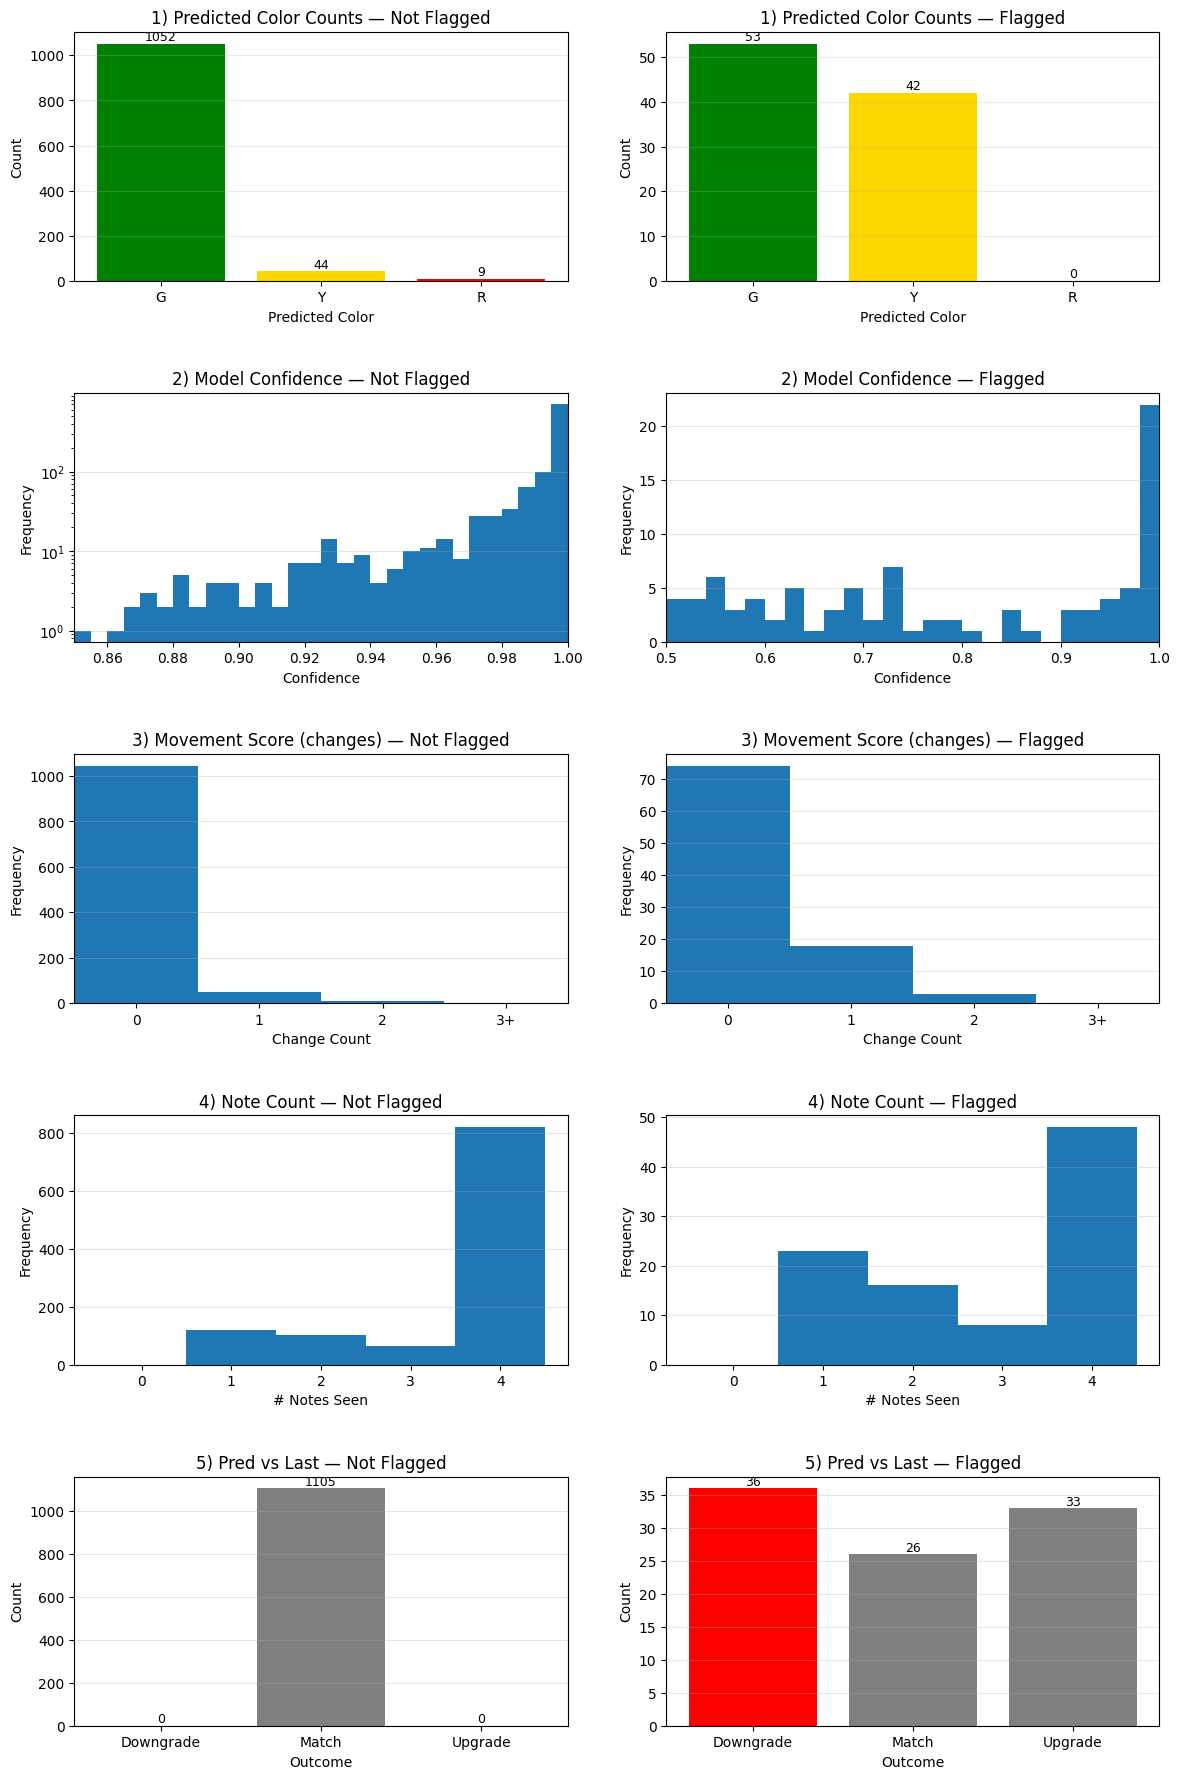

In [ ]:
# ==== Global Count Summary + 5×2 Dashboard (Graphs 1–5) ======================
# Assumes you already have a DataFrame named `aligned`, and a boolean column:
# aligned["Flagged"] = (aligned["Model_Confidence"] < .75) | (aligned["Prediction_Diff"] == 1)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df = aligned.copy()

# -------------------- Derivations / helpers ----------------------------------

# 1) Normalize predicted color to single letter (e.g., "Green" -> "G")
df["Pred_Color"] = df["Model_Prediction"].astype(str).str[0].str.upper()

# 2) Movement metrics from Color_Set
COLOR_MAP = {"G": 0, "Y": 1, "R": 2}

def movement_metrics(color_set: str) -> tuple[int, int]:
    s = [c for c in (color_set or "") if c in COLOR_MAP]
    if len(s) <= 1:
        return 0, 0
    nums  = [COLOR_MAP[c] for c in s]
    diffs = np.diff(nums)
    # change_count: count of transitions where the letter changes (G->Y->Y = 1 change)
    change_count = int(np.sum(np.array(s[1:]) != np.array(s[:-1])))
    # step_sum: captures distance (G<->R = 2, G<->Y = 1, etc.)
    step_sum = int(np.sum(np.abs(diffs)))
    return change_count, step_sum

mm = df["Color_Set"].apply(movement_metrics)
df["Move_Changes"] = mm.apply(lambda t: t[0])
df["Move_Steps"]   = mm.apply(lambda t: t[1])

# 3) Note count (how many non-null note columns)
note_cols = [c for c in df.columns if c.startswith("Scorecard_Detail_Note_SID_")]
df["Note_Count"] = df[note_cols].notna().sum(axis=1)

# 4) Low-history flag (example: fewer than 4 notes)
df["Low_History"] = (df["Note_Count"] < 4).astype(int)

# 5) Upgrade / Match / Downgrade vs last color
def compare_trend(last_c, pred_c):
    if pd.isna(last_c) or pd.isna(pred_c):
        return "N/A"
    a = COLOR_MAP.get(str(last_c)[0].upper(), None)
    b = COLOR_MAP.get(str(pred_c)[0].upper(), None)
    if a is None or b is None:
        return "N/A"
    delta = b - a
    if delta < 0:  return "Upgrade"
    if delta > 0:  return "Downgrade"
    return "Match"

df["Pred_vs_Last"] = [compare_trend(lc, pc) for lc, pc in zip(df["Last_Color"], df["Pred_Color"])]

# 6) Subsets
left  = df[~df["Flagged"]]   # Not Flagged
right = df[df["Flagged"]]    # Flagged

# 7) Utilities
color_order = ["G", "Y", "R"]
def bar_color_for(letter): return {"G":"green","Y":"gold","R":"red"}.get(letter, "gray")

# -------------------- (Optional) Global count summary tables -----------------
pred_counts = (pd.crosstab(df["Flagged"], df["Pred_Color"])
               .reindex(columns=color_order, fill_value=0)
               .rename(index={False:"Not Flagged", True:"Flagged"}))

conf_summary = (df.groupby("Flagged")["Model_Confidence"]
                .agg(["count","mean","median","min","max"])
                .rename(index={False:"Not Flagged", True:"Flagged"}))

move_summary = (df.groupby("Flagged")[["Move_Changes","Move_Steps"]]
                .agg(["mean","median","max"])
                .rename(index={False:"Not Flagged", True:"Flagged"}))

lowhist_counts = (pd.crosstab(df["Flagged"], df["Low_History"])
                  .rename(columns={0:"Sufficient History",1:"Low History"})
                  .rename(index={False:"Not Flagged", True:"Flagged"}))

trend_counts = (pd.crosstab(df["Flagged"], df["Pred_vs_Last"])
                .reindex(columns=["Downgrade","Match","Upgrade"], fill_value=0)
                .rename(index={False:"Not Flagged", True:"Flagged"}))

print("\n== Global Summary: Predicted Color Counts (Not Flagged vs Flagged) ==")
print(pred_counts)
print("\n== Confidence Summary ==")
print(conf_summary.round(4))
print("\n== Movement Summary ==")
print(move_summary.round(3))
print("\n== Low-History Counts ==")
print(lowhist_counts)
print("\n== Upgrade / Match / Downgrade Counts ==")
print(trend_counts)

# ========================= 5×2 Dashboard ====================================
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(14, 22))
plt.subplots_adjust(hspace=0.45)

# ---------------- Row 1: Predicted color counts (R/Y/G) ----------------------
for j, subset in enumerate([left, right]):
    ax = axes[0, j]
    counts = subset["Pred_Color"].value_counts().reindex(color_order, fill_value=0)
    bars = ax.bar(counts.index, counts.values, color=[bar_color_for(c) for c in counts.index])
    ax.set_title(f"1) Predicted Color Counts — {'Not Flagged' if j==0 else 'Flagged'}")
    ax.set_xlabel("Predicted Color")
    ax.set_ylabel("Count")
    for b in bars:
        ax.text(b.get_x()+b.get_width()/2, b.get_height(), f"{int(b.get_height())}",
                ha="center", va="bottom", fontsize=9)
    ax.grid(True, axis="y", alpha=0.25)

# ---------------- Row 2: Model confidence histograms (tuned) -----------------
def plot_conf_hist(ax, series, title, flagged=False):
    s = series.dropna()
    if flagged:
        bins = np.linspace(0.5, 1.0, 26)   # broader view for Flagged
        ax.set_xlim(0.5, 1.0)
    else:
        bins = np.linspace(0.85, 1.0, 31)  # fine-grained near the top for Not Flagged
        ax.set_xlim(0.85, 1.0)
        ax.set_yscale("log")               # reveal structure near 1.0

    ax.hist(s, bins=bins)
    ax.set_title(title)
    ax.set_xlabel("Confidence")
    ax.set_ylabel("Frequency")
    ax.grid(True, axis="y", alpha=0.3)

plot_conf_hist(axes[1, 0], left["Model_Confidence"],  "2) Model Confidence — Not Flagged", flagged=False)
plot_conf_hist(axes[1, 1], right["Model_Confidence"], "2) Model Confidence — Flagged",     flagged=True)

# ---------------- Row 3: Movement score (changes) histograms -----------------
def movement_capped(series):
    x = series.fillna(0).astype(int).to_numpy()
    return np.where(x > 3, 3, x)  # cap at 3 => "3+"

for j, subset in enumerate([left, right]):
    ax = axes[2, j]
    x = movement_capped(subset["Move_Changes"])
    ax.hist(x, bins=np.arange(-0.5, 4.5, 1))
    ax.set_title(f"3) Movement Score (changes) — {'Not Flagged' if j==0 else 'Flagged'}")
    ax.set_xlabel("Change Count")
    ax.set_ylabel("Frequency")
    ax.set_xticks([0,1,2,3])
    ax.set_xticklabels(["0", "1", "2", "3+"])
    ax.set_xlim(-0.5, 3.5)
    ax.grid(True, axis="y", alpha=0.3)

# ---------------- Row 4: Note count histograms -------------------------------
for j, subset in enumerate([left, right]):
    ax = axes[3, j]
    ax.hist(subset["Note_Count"].fillna(0), bins=np.arange(-0.5, len(note_cols)+1.5, 1))
    ax.set_title(f"4) Note Count — {'Not Flagged' if j==0 else 'Flagged'}")
    ax.set_xlabel("# Notes Seen")
    ax.set_ylabel("Frequency")
    ax.grid(True, axis="y", alpha=0.3)

# ---------------- Row 5: Upgrade / Match / Downgrade bars --------------------
for j, subset in enumerate([left, right]):
    ax = axes[4, j]
    order  = ["Downgrade","Match","Upgrade"]
    counts = subset["Pred_vs_Last"].value_counts().reindex(order, fill_value=0)

    # color Downgrade red; others gray
    colors = ["red", "gray", "gray"]
    bars = ax.bar(order, counts.values, color=colors)

    ax.set_title(f"5) Pred vs Last — {'Not Flagged' if j==0 else 'Flagged'}")
    ax.set_xlabel("Outcome")
    ax.set_ylabel("Count")
    for b in bars:
        ax.text(b.get_x()+b.get_width()/2, b.get_height(), f"{int(b.get_height())}",
                ha="center", va="bottom", fontsize=9)
    ax.grid(True, axis="y", alpha=0.3)

plt.show()


In [8]:
df

Model_Index  Model_Number  Model_Date  Scorecard_Detail_SID Color_Set  \
0               1             6  2019-06-01                  3524      GGGG   
1               2             6  2016-03-01                     8        GG   
2               3             6  2020-03-01                  4593      GGGG   
3               4             6  2025-09-01                 42505      GGGG   
4               5             6  2025-09-01                 42652      YYYY   
...           ...           ...         ...                   ...       ...   
1195         1196             6  2025-08-01                 42285         G   
1196         1197             6  2025-09-01                 42465         G   
1197         1198             6  2025-09-01                 42735       GGG   
1198         1199             6  2025-09-01                 42539         G   
1199         1200             6  2025-09-01                 42733        GG   

                                    Complete_Main_Words  \
0                                                   pop   
1                                        close contract   
2         deliver all em-2 cm rcs engine assemblies ksc   
3     receive complete transfer request go continue ...   
4     drive estimate complete document forecast comp...   
...                                                 ...   
1195  confirm give push rough daniel d. e. b. the da...   
1196  provide provide need provide establish actions...   
1197                                         no updates   
1198  authorize fund authorize fund authorize fund a...   
1199                                         no updates   

      Scorecard_Detail_Note_SID_0  Scorecard_Detail_Note_SID_1  \
0                            2230                         5672   
1                               7                            8   
2                              13                            9   
3                           39526                        39530   
4                           41370                        41743   
...                           ...                          ...   
1195                        42285                         <NA>   
1196                        42465                         <NA>   
1197                        42511                        42626   
1198                        42539                         <NA>   
1199                        42622                        42733   

      Scorecard_Detail_Note_SID_2  Scorecard_Detail_Note_SID_3  ... Info  \
0                            5774                         3524  ...        
1                            <NA>                         <NA>  ...        
2                            4592                         4593  ...        
3                           42232                        42505  ...        
4                           42216                        42652  ...        
...                           ...                          ...  ...  ...   
1195                         <NA>                         <NA>  ...        
1196                         <NA>                         <NA>  ...        
1197                        42735                         <NA>  ...        
1198                         <NA>                         <NA>  ...        
1199                         <NA>                         <NA>  ...        

      Last_Color Prediction_Diff  Flagged Pred_Color Move_Changes Move_Steps  \
0              G               0    False          G            0          0   
1              G               0    False          G            0          0   
2              G               0    False          G            0          0   
3              G               0    False          G            0          0   
4              Y               0    False          Y            0          0   
...          ...             ...      ...        ...          ...        ...   
1195           G               0    False          G            0          0   
11

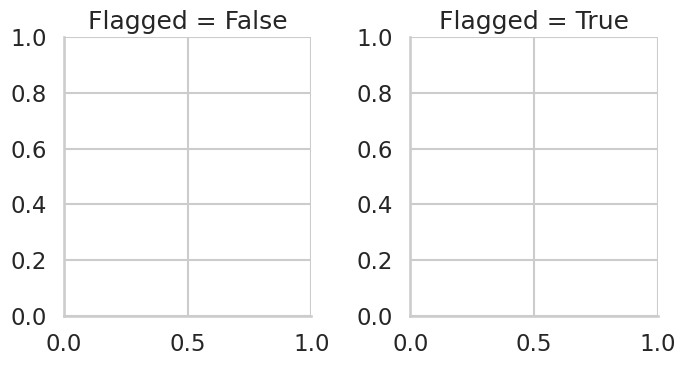

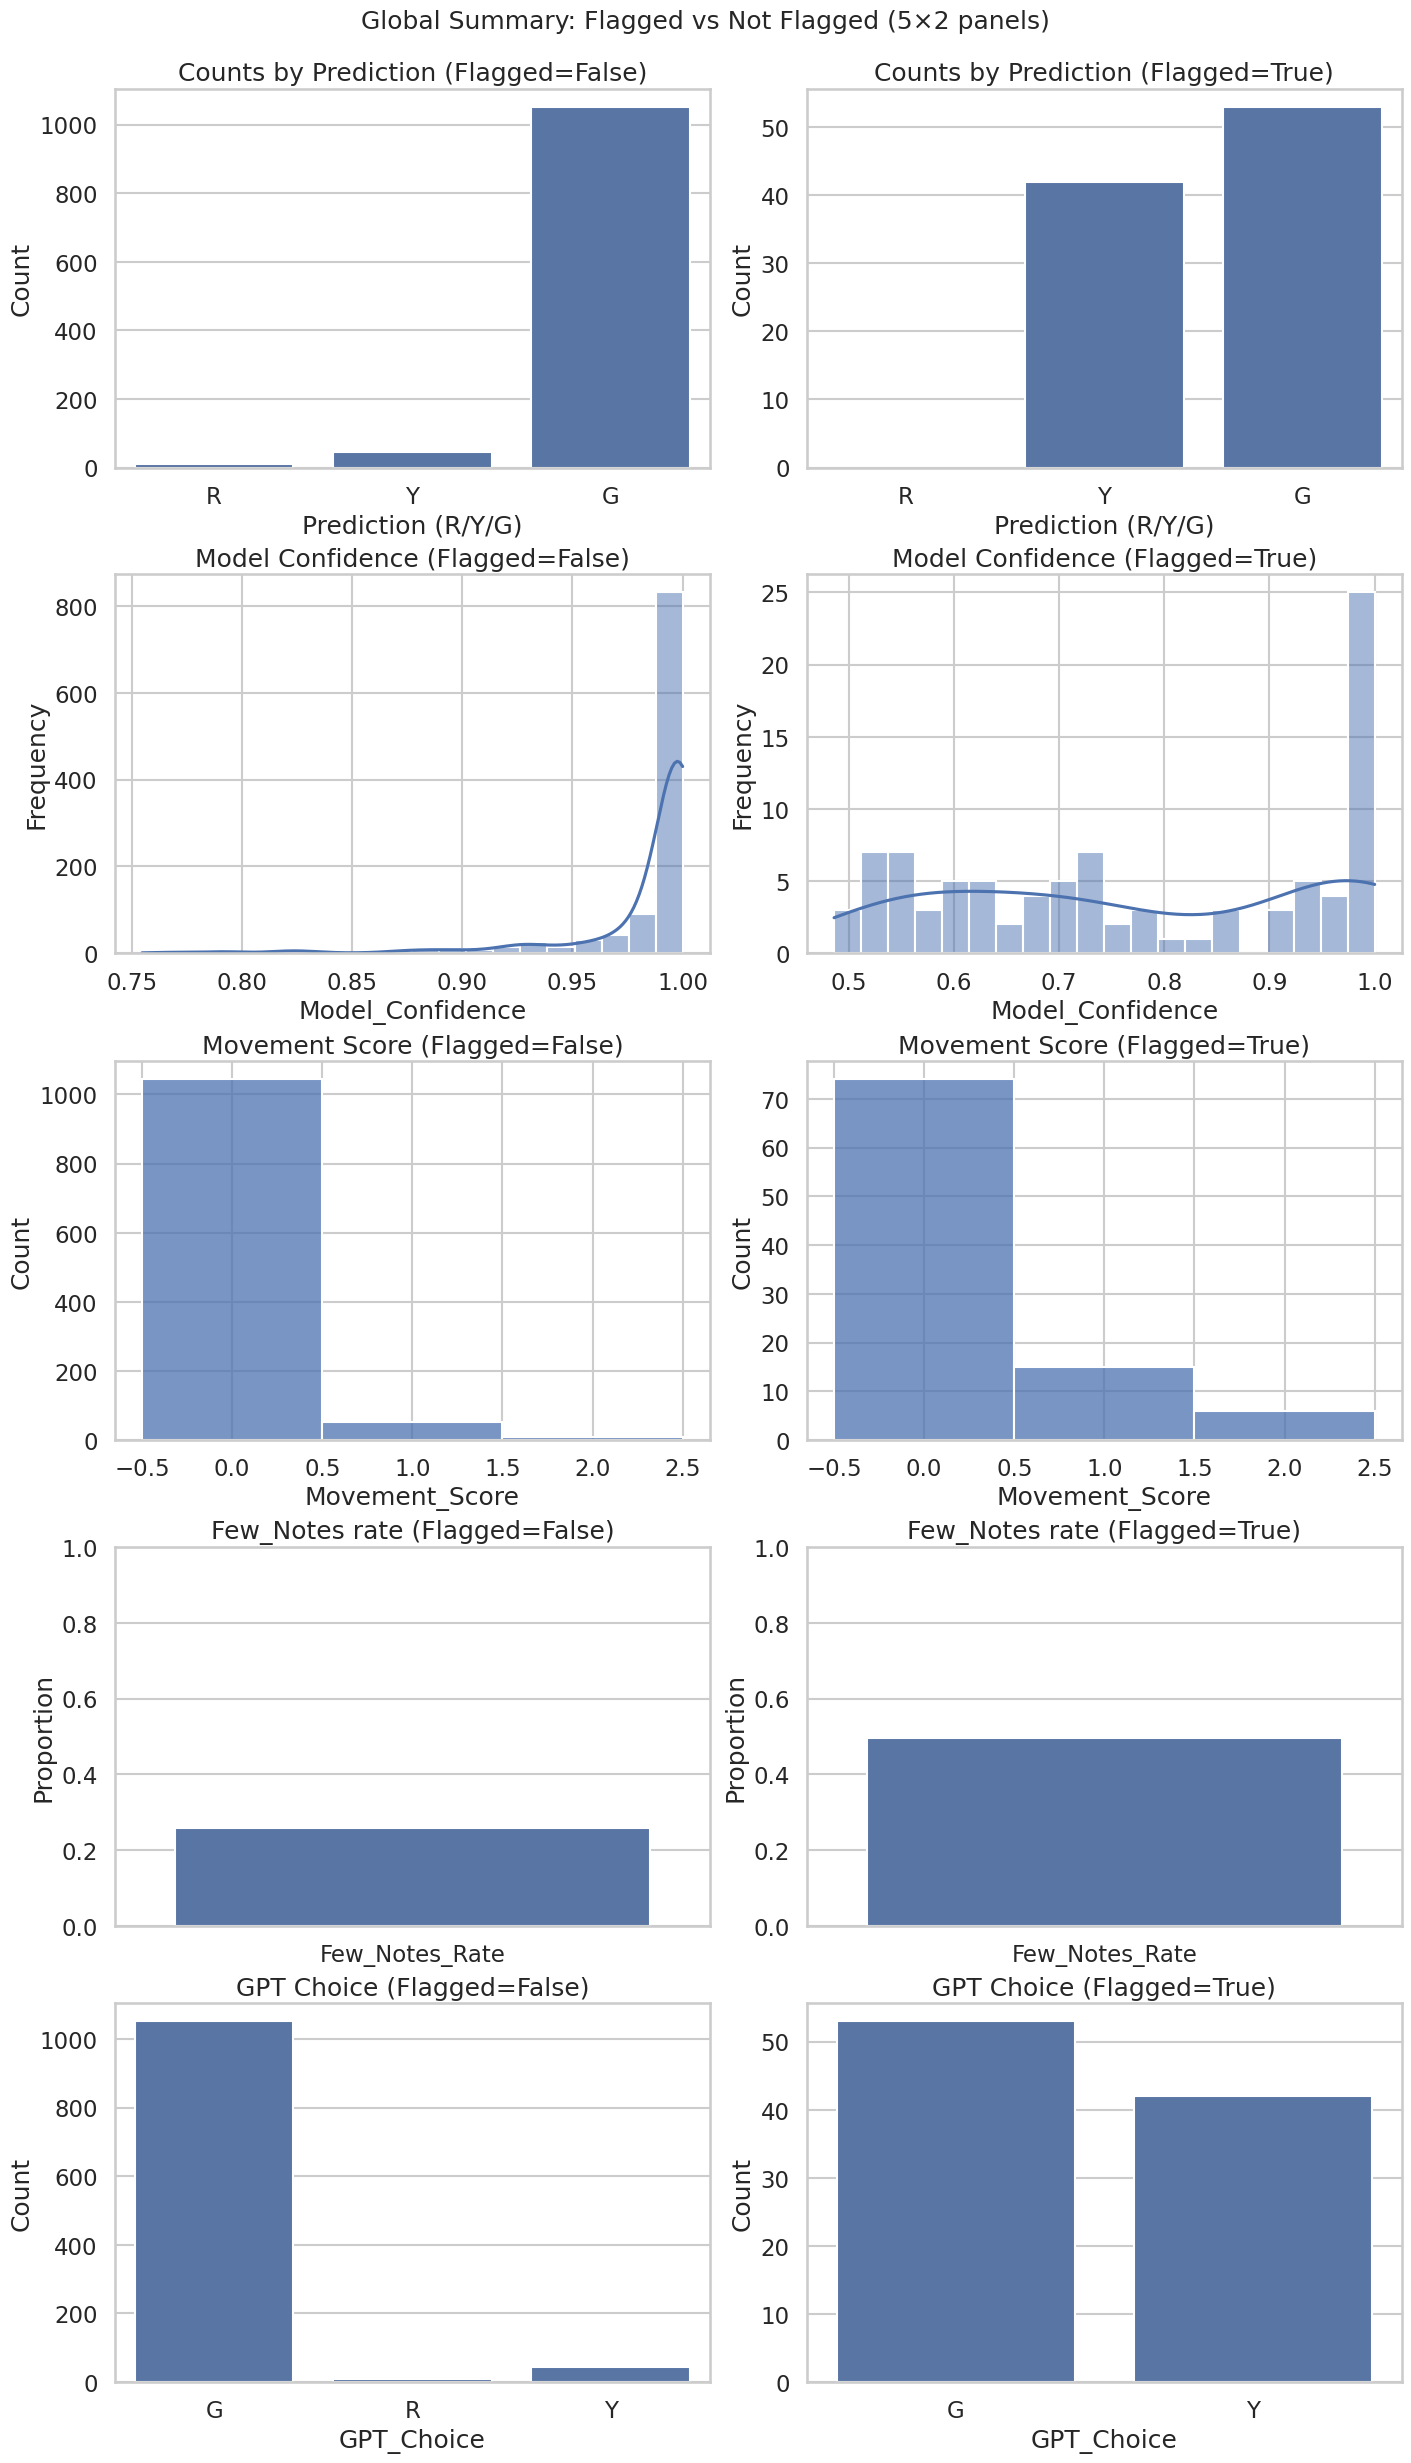

TypeError: unhashable type: 'Series'

In [43]:
# === Imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# === Assumes your dataframe is named `aligned` and has:
# Model_Prediction (e.g., "Green", "Yellow", "Red")
# Model_Confidence (float)
# Last_Color (e.g., "G", "Y", "R")
# Color_Set (e.g., "GYYY")
# Scorecard_Detail_Note_SID_0..3 (ints or None)
# Flagged (bool) — as you already created

# -------------------------------------------------------------------
# 1) Ensure core columns exist and clean
# -------------------------------------------------------------------
# Safer comparison column from Model_Prediction first letter
aligned["Pred_First"] = aligned["Model_Prediction"].str[0].str.upper()

# If you didn't make Prediction_Diff earlier:
aligned["Prediction_Diff"] = (aligned["Pred_First"] != aligned["Last_Color"].str[0].str.upper()).astype(int)

# If you didn’t set Flagged earlier:
# aligned["Flagged"] = (aligned["Model_Confidence"] < 0.75) | (aligned["Prediction_Diff"] == 1)

# -------------------------------------------------------------------
# 2) Movement score from Color_Set
#    Definition: sum of absolute diffs over the sequence with G=0, Y=1, R=2
# -------------------------------------------------------------------
color_map = {"G": 0, "Y": 1, "R": 2}

def movement_score(color_seq: str) -> int:
    if not isinstance(color_seq, str) or len(color_seq) < 2:
        return 0
    # keep only G/Y/R and map; ignore anything else
    nums = [color_map[c] for c in color_seq if c in color_map]
    if len(nums) < 2:
        return 0
    return int(np.abs(np.diff(nums)).sum())

aligned["Movement_Score"] = aligned["Color_Set"].fillna("").map(movement_score)

# -------------------------------------------------------------------
# 3) Warning counter: “few notes” (e.g., fewer than 4)
#    Count how many note SID columns are non-null
# -------------------------------------------------------------------
note_cols = [c for c in aligned.columns if c.startswith("Scorecard_Detail_Note_SID_")]
aligned["Note_Count"] = aligned[note_cols].notna().sum(axis=1)
aligned["Few_Notes"] = (aligned["Note_Count"] < 4).astype(int)

# -------------------------------------------------------------------
# 5) Prep plotting aesthetics
# -------------------------------------------------------------------
sns.set(context="talk", style="whitegrid")

# Two columns: Flagged = False/True
g = sns.FacetGrid(aligned, col="Flagged", col_order=[False, True], height=4, aspect=0.9, sharex=False, sharey=False)

# We’ll draw 5 rows manually using a single figure with subplots.
# (Seaborn FacetGrid typically controls the whole grid, but we can build a 5x2 layout explicitly for clarity.)
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(14, 24), constrained_layout=True)
flag_cols = [False, True]

# -------------------------------------------------------------------
# Row 1: Counts of R/Y/G (Pred_First) by Flagged
# -------------------------------------------------------------------
for j, flg in enumerate(flag_cols):
    ax = axes[0, j]
    data = aligned[aligned["Flagged"] == flg]
    sns.countplot(data=data, x="Pred_First", order=["R","Y","G"], ax=ax)
    ax.set_title(f"Counts by Prediction (Flagged={flg})")
    ax.set_xlabel("Prediction (R/Y/G)")
    ax.set_ylabel("Count")

# -------------------------------------------------------------------
# Row 2: Model Confidence distribution by Flagged
# -------------------------------------------------------------------
for j, flg in enumerate(flag_cols):
    ax = axes[1, j]
    data = aligned[aligned["Flagged"] == flg]
    # Histogram with KDE overlay for confidence
    sns.histplot(data=data, x="Model_Confidence", bins=20, kde=True, ax=ax)
    ax.set_title(f"Model Confidence (Flagged={flg})")
    ax.set_xlabel("Model_Confidence")
    ax.set_ylabel("Frequency")

# -------------------------------------------------------------------
# Row 3: Movement Score distribution by Flagged
# -------------------------------------------------------------------
for j, flg in enumerate(flag_cols):
    ax = axes[2, j]
    data = aligned[aligned["Flagged"] == flg]
    sns.histplot(data=data, x="Movement_Score", bins=range(0, data["Movement_Score"].max()+2 if len(data) else 2), kde=False, ax=ax, discrete=True)
    ax.set_title(f"Movement Score (Flagged={flg})")
    ax.set_xlabel("Movement_Score")
    ax.set_ylabel("Count")

# -------------------------------------------------------------------
# Row 4: Few_Notes (warning) rate by Flagged (bar of proportions)
# -------------------------------------------------------------------
for j, flg in enumerate(flag_cols):
    ax = axes[3, j]
    data = aligned[aligned["Flagged"] == flg]
    # Compute proportion of Few_Notes = 1
    prop = data["Few_Notes"].mean() if len(data) else 0.0
    sns.barplot(x=["Few_Notes_Rate"], y=[prop], ax=ax)
    ax.set_ylim(0, 1)
    ax.set_title(f"Few_Notes rate (Flagged={flg})")
    ax.set_ylabel("Proportion")
    ax.set_xlabel("")

# -------------------------------------------------------------------
# Row 5: GPT choice (or placeholder) by Flagged
# -------------------------------------------------------------------
for j, flg in enumerate(flag_cols):
    ax = axes[4, j]
    data = aligned[aligned["Flagged"] == flg]
    sns.countplot(data=data, x="GPT_Choice", order=sorted(data["GPT_Choice"].dropna().unique()), ax=ax)
    ax.set_title(f"GPT Choice (Flagged={flg})")
    ax.set_xlabel("GPT_Choice")
    ax.set_ylabel("Count")

plt.suptitle("Global Summary: Flagged vs Not Flagged (5×2 panels)", y=1.02, fontsize=18)
plt.show()

# -------------------------------------------------------------------
# ALSO build a small numeric executive table
# -------------------------------------------------------------------
def downgrade(a, b):
    # using R=2, Y=1, G=0; downgrade if Pred < Last
    m = {"R": 2, "Y": 1, "G": 0}
    return (m.get(a, -1) < m.get(b, -1))

def upgrade(a, b):
    m = {"R": 2, "Y": 1, "G": 0}
    return (m.get(a, -1) > m.get(b, -1))

tmp = aligned.assign(
    Last_First = aligned["Last_Color"].str[0].str.upper(),
    Is_Downgrade = lambda d: downgrade(d["Pred_First"], d["Last_First"]),
    Is_Upgrade   = lambda d: upgrade(d["Pred_First"], d["Last_First"])
)

summary = (
    tmp.groupby("Flagged")
      .agg(
          n=("Model_Index", "count"),
          downgrades=("Is_Downgrade", "sum"),
          upgrades=("Is_Upgrade", "sum"),
          low_conf=("Model_Confidence", lambda s: int((s < 0.75).sum())),
          mismatch=("Prediction_Diff", "sum"),
          few_notes=("Few_Notes", "sum"),
          avg_conf=("Model_Confidence", "mean"),
          avg_move=("Movement_Score", "mean")
      )
      .reset_index()
)

summary


In [9]:
def q(sql):
    return pd.read_sql(sql, engine)

# 1) Basic counts
cnt = q(f"""
SELECT COUNT(*) AS total_rows
FROM dbo.Scorecard_Spark_Model
WHERE Model_Number = {model_number};
""")
print(f"Total rows (Model_Number={model_number}):")
display(cnt)

# 2) Prediction distribution
pred_dist = q(f"""
SELECT Model_Prediction, COUNT(*) AS n
FROM dbo.Scorecard_Spark_Model
WHERE Model_Number = {model_number}
GROUP BY Model_Prediction
ORDER BY n DESC;
""")
print(f"Prediction distribution (Model_Number={model_number}):")
display(pred_dist)

# 3) Model_Date range (stored as VARCHAR -> ISO YYYY-MM-DD sorts correctly)
date_rng = q(f"""
SELECT MIN(Model_Date) AS min_date, MAX(Model_Date) AS max_date
FROM dbo.Scorecard_Spark_Model
WHERE Model_Number = {model_number};
""")
print(f"Model_Date range (Model_Number={model_number}):")
display(date_rng)

# 4) Nulls on key columns
nulls = q(f"""
SELECT 
  SUM(CASE WHEN Model_Prediction IS NULL THEN 1 ELSE 0 END) AS null_prediction,
  SUM(CASE WHEN Model_Confidence IS NULL THEN 1 ELSE 0 END) AS null_confidence,
  SUM(CASE WHEN Scorecard_Detail_SID IS NULL THEN 1 ELSE 0 END) AS null_detail_sid,
  SUM(CASE WHEN Model_Date IS NULL OR Model_Date = '' THEN 1 ELSE 0 END) AS null_model_date,
  SUM(CASE WHEN Color_Set IS NULL THEN 1 ELSE 0 END) AS null_color_set
FROM dbo.Scorecard_Spark_Model
WHERE Model_Number = {model_number};
""")
print(f"Null checks (Model_Number={model_number}):")
display(nulls)

# 5) Truncation marker audit
truncs = q(f"""
SELECT
  SUM(CASE WHEN CHARINDEX('[TRUNCATED]', Complete_Main_Words) > 0 THEN 1 ELSE 0 END) AS trunc_cmw,
  SUM(CASE WHEN CHARINDEX('[TRUNCATED]', Model_Explanation)   > 0 THEN 1 ELSE 0 END) AS trunc_expl,
  SUM(CASE WHEN CHARINDEX('[TRUNCATED]', Warning)             > 0 THEN 1 ELSE 0 END) AS trunc_warn,
  SUM(CASE WHEN CHARINDEX('[TRUNCATED]', Info)                > 0 THEN 1 ELSE 0 END) AS trunc_info
FROM dbo.Scorecard_Spark_Model
WHERE Model_Number = {model_number};
""")
print(f"[TRUNCATED] tag usage (Model_Number={model_number}):")
display(truncs)

# 6) Color_set length vs Warning rule
color_warn = q(f"""
SELECT
  SUM(CASE WHEN LEN(ISNULL(Color_Set,'')) < 4 THEN 1 ELSE 0 END) AS short_color_set,
  SUM(CASE WHEN LEN(ISNULL(Color_Set,'')) < 4 
            AND CHARINDEX('less than 4 prior notes', ISNULL(Warning,'')) = 0 
           THEN 1 ELSE 0 END) AS short_without_warning
FROM dbo.Scorecard_Spark_Model
WHERE Model_Number = {model_number};
""")
print("Color_Set len<4 and Warning rule check:")
display(color_warn)

# 7) Duplicate key check (just in case)
dupes = q(f"""
SELECT TOP (10) Scorecard_Detail_SID, COUNT(*) AS n
FROM dbo.Scorecard_Spark_Model
WHERE Model_Number = {model_number}
GROUP BY Scorecard_Detail_SID
HAVING COUNT(*) > 1
ORDER BY n DESC, Scorecard_Detail_SID;
""")
print("Potential duplicates on Scorecard_Detail_SID (top 10):")
display(dupes)

# 8) Random sample rows
sample5 = q(f"""
SELECT TOP (5) *
FROM dbo.Scorecard_Spark_Model
WHERE Model_Number = {model_number}
ORDER BY NEWID();
""")
print(f"Random sample (Model_Number={model_number}):")
display(sample5)


Total rows (Model_Number=6):


total_rows
0        1200

Prediction distribution (Model_Number=6):


Model_Prediction     n
0            Green  1105
1           Yellow    86
2              Red     9

Model_Date range (Model_Number=6):


min_date    max_date
0  2013-05-01  2025-09-01

Null checks (Model_Number=6):


null_prediction  null_confidence  null_detail_sid  null_model_date  \
0                0                0                0                0   

   null_color_set  
0               0

[TRUNCATED] tag usage (Model_Number=6):


trunc_cmw  trunc_expl  trunc_warn  trunc_info
0          6           0           0           0

Color_Set len<4 and Warning rule check:


short_color_set  short_without_warning
0              332                      0

Potential duplicates on Scorecard_Detail_SID (top 10):


Empty DataFrame
Columns: [Scorecard_Detail_SID, n]
Index: []

Random sample (Model_Number=6):


Model_Index  Model_Number  Model_Date  Scorecard_Detail_SID Color_Set  \
0          735             6  2024-01-01                 34403      GGGG   
1           35             6  2016-01-01                   136      GGGG   
2          444             6  2022-04-01                 22162      GGGG   
3          499             6  2021-10-01                 19865      GGGG   
4          664             6  2022-02-01                 21320         G   

                                 Complete_Main_Words  \
0                                          complete    
1                                               see    
2  close receive remove ready po all items po sco...   
3  invoice complete final fdr complete - final mi...   
4  execute remove execute execute add execute rem...   

   Scorecard_Detail_Note_SID_0  Scorecard_Detail_Note_SID_1  \
0                        33661                      33839.0   
1                          133                        134.0   
2                        19368                      19914.0   
3                        19317                      19473.0   
4                        21320                          NaN   

   Scorecard_Detail_Note_SID_2  Scorecard_Detail_Note_SID_3 Model_Prediction  \
0                      34117.0                      34403.0            Green   
1                        135.0                        136.0            Green   
2                      20222.0                      22162.0            Green   
3                      19503.0                      19865.0            Green   
4                          NaN                          NaN            Green   

   Model_Confidence                                  Model_Explanation  \
0            0.9985  The model forecasts a Green rating with 99.85%...   
1            0.9979  The model forecasts a Green rating with 99.79%...   
2            0.9912  The model forecasts a Green rating with 99.12%...   
3            1.0000  The model forecasts a Green rating with 100.00...   
4            0.9859  The model forecasts a Green rating with 98.59%...   

   Latest                                        Warning Info  
0       1                                                      
1       1                                                      
2       1                                                      
3       1                                                      
4       1  Model predicting with less than 4 prior notes

In [5]:
def build_model5_latest_table(df: pd.DataFrame) -> pd.DataFrame:
    def best_confidence(row: pd.Series) -> float:
        probs = [float(row[c]) for c in ["prob_green","prob_yellow","prob_red"] if c in row and pd.notna(row[c])]
        return max(probs) if probs else np.nan

    def extract_note_sid_from_key(s: pd.Series) -> pd.Series:
        return s.fillna("").astype(str).str.split(".").str[-1].replace("", np.nan)

    # ---------- choose key for "latest" ----------
    key_col = None
    for c in ["sid_key", "last_sid"]:
        if c in df.columns:
            key_col = c
            break
    if key_col is None:
        if {"SID","Note_Year","Note_Month","Scorecard_Detail_Note_SID"}.issubset(df.columns):
            sid_str = df["SID"].astype(int).astype(str).str.zfill(6)
            yr = df["Note_Year"].astype(int).astype(str).str.zfill(4)
            mo = df["Note_Month"].astype(int).astype(str).str.zfill(2)
            note = df["Scorecard_Detail_Note_SID"].astype(int).astype(str).str.zfill(6)
            df = df.assign(_built_sid_key = sid_str + "." + yr + "." + mo + "." + note)
            key_col = "_built_sid_key"
        else:
            raise ValueError("No sid_key/last_sid columns and insufficient parts to construct one.")

    # ---------- latest row per SID ----------
    idx_latest = (
        df.assign(_sortkey=df[key_col].astype(str))
          .groupby("SID")["_sortkey"]
          .idxmax()
    )
    latest = df.loc[idx_latest].copy()
    latest["_Latest"] = True

    # ---------- derived fields ----------
    latest = latest.sort_values(
        ["SID", "Report_Date"] if "Report_Date" in latest.columns else ["SID","Note_Year","Note_Month"]
    ).reset_index(drop=True)
    latest["_Model_Index"] = np.arange(1, len(latest)+1)
    latest["_Model_Number"] = model_number

    if "Report_Date" in latest.columns:
        model_date = pd.to_datetime(latest["Report_Date"], errors="coerce").dt.date
    else:
        y = latest.get("Note_Year")
        m = latest.get("Note_Month")
        model_date = pd.to_datetime(
            y.astype("Int64").astype(str).str.zfill(4) + "-" +
            m.astype("Int64").astype(str).str.zfill(2) + "-01",
            errors="coerce"
        ).dt.date
    latest["_Model_Date"] = model_date

    latest["_Scorecard_Detail_SID"] = latest.get("Scorecard_Detail_Note_SID")
    latest["_Color_Set"] = latest.get("color_set")

    latest["_Complete_Main_Words"] = (
        latest["complete_main_words"] if "complete_main_words" in latest.columns else latest.get("main_words")
    )

    for i in range(4):
        col_key = f"sid_key_{i}"
        out_col = f"_Scorecard_Detail_Note_SID_{i}"
        if col_key in latest.columns:
            latest[out_col] = extract_note_sid_from_key(latest[col_key]).astype("Int64")
        else:
            latest[out_col] = pd.Series([pd.NA]*len(latest), dtype="Int64")

    latest["_Model_Prediction"] = (
        latest["predicted_color"] if "predicted_color" in latest.columns else latest.get("predicted_label")
    )
    latest["_Model_Confidence"] = latest.apply(best_confidence, axis=1)
    latest["_Model_Explanation"] = (
        latest["justification"] if "justification" in latest.columns and latest["justification"].notna().any()
        else latest.get("gpt_justification")
    )

    # ---------- Warning / Info ----------
    latest["_Warning"] = ""
    latest["_Info"] = ""

    # If color_set length < 4, add warning
    if "_Color_Set" in latest.columns:
        mask = latest["_Color_Set"].fillna("").str.len() < 4
        latest.loc[mask, "_Warning"] = "Model predicting with less than 4 prior notes"

    # ---------- final trim ----------
    col_map = {
        "_Model_Index": "Model_Index",
        "_Model_Number": "Model_Number",
        "_Model_Date": "Model_Date",
        "_Scorecard_Detail_SID": "Scorecard_Detail_SID",
        "_Color_Set": "Color_Set",
        "_Complete_Main_Words": "Complete_Main_Words",
        "_Scorecard_Detail_Note_SID_0": "Scorecard_Detail_Note_SID_0",
        "_Scorecard_Detail_Note_SID_1": "Scorecard_Detail_Note_SID_1",
        "_Scorecard_Detail_Note_SID_2": "Scorecard_Detail_Note_SID_2",
        "_Scorecard_Detail_Note_SID_3": "Scorecard_Detail_Note_SID_3",
        "_Model_Prediction": "Model_Prediction",
        "_Model_Confidence": "Model_Confidence",
        "_Model_Explanation": "Model_Explanation",
        "_Latest": "Latest",
        "_Warning": "Warning",
        "_Info": "Info",
    }
    out = latest[list(col_map.keys())].rename(columns=col_map)
    return out

# Example usage (after your `df` is defined):
out_table = build_model5_latest_table(df)

  [Model_Index]
      ,[Model_Number]
      ,[Model_Date]
      ,[Scorecard_Detail_SID]
      ,[Color_Set]
      ,[Complete_Main_Words]
      ,[Scorecard_Detail_Note_SID_0]
      ,[Scorecard_Detail_Note_SID_1]
      ,[Scorecard_Detail_Note_SID_2]
      ,[Scorecard_Detail_Note_SID_3]
      ,[Model_Prediction]
      ,[Model_Confidence]
      ,[Model_Explanation]
      ,[Latest]
      ,[Warning]
      ,[Info]

In [6]:
# assumes `engine` already created
schema_df = pd.read_sql(f"""
SELECT
  c.ORDINAL_POSITION,
  c.COLUMN_NAME,
  c.DATA_TYPE,
  c.CHARACTER_MAXIMUM_LENGTH,
  c.IS_NULLABLE
FROM INFORMATION_SCHEMA.COLUMNS c
WHERE c.TABLE_SCHEMA = '{schema_name}'
  AND c.TABLE_NAME   = '{table_name}'
ORDER BY c.ORDINAL_POSITION
""", engine)

print(schema_df)

# Build a {col: maxlen} map for (n)varchar so you can auto-trim before insert
text_types = {"varchar","nvarchar","char","nchar"}
length_map = {
    r.COLUMN_NAME: (None if r.CHARACTER_MAXIMUM_LENGTH in (None, -1) else int(r.CHARACTER_MAXIMUM_LENGTH))
    for _, r in schema_df.iterrows()
    if r.DATA_TYPE in text_types
}

# Optional: see which cols in your out_table would overflow current widths
def find_overflows(df, length_map):
    report = {}
    for col, maxlen in length_map.items():
        if maxlen is None or col not in df.columns:
            continue
        s = df[col].dropna().astype(str)
        n = int((s.str.len() > maxlen).sum())
        if n:
            report[col] = {"max_allowed": maxlen, "rows_over_limit": n, "max_len_seen": int(s.str.len().max())}
    return report

# Example:
# print(find_overflows(out_table, length_map))


    ORDINAL_POSITION                  COLUMN_NAME DATA_TYPE  \
0                  1                  Model_Index       int   
1                  2                 Model_Number       int   
2                  3                   Model_Date   varchar   
3                  4         Scorecard_Detail_SID       int   
4                  5                    Color_Set   varchar   
5                  6          Complete_Main_Words   varchar   
6                  7  Scorecard_Detail_Note_SID_0       int   
7                  8  Scorecard_Detail_Note_SID_1       int   
8                  9  Scorecard_Detail_Note_SID_2       int   
9                 10  Scorecard_Detail_Note_SID_3       int   
10                11             Model_Prediction   varchar   
11                12             Model_Confidence   numeric   
12                13            Model_Explanation   varchar   
13                14                       Latest       int   
14                15                      Warning   var

In [19]:
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
from urllib.parse import quote_plus

preferred_driver = "ODBC Driver 18 for SQL Server"
odbc_base = (
    f"DRIVER={{{{DRIVER_TOKEN}}}};"
    f"SERVER={sql_server};"
    f"DATABASE={sql_database};"
    f"UID={sql_uid};PWD={sql_pwd};"
    "Encrypt=yes;TrustServerCertificate=yes;MARS_Connection=yes;"
)

def _make_engine(odbc_str: str):
    return create_engine(
        f"mssql+pyodbc:///?odbc_connect={quote_plus(odbc_str)}",
        fast_executemany=True
    )

# === 1) Pull live schema (types & lengths) ===
schema_df = pd.read_sql(f"""
SELECT
  c.ORDINAL_POSITION,
  c.COLUMN_NAME,
  c.DATA_TYPE,
  c.CHARACTER_MAXIMUM_LENGTH,
  c.IS_NULLABLE
FROM INFORMATION_SCHEMA.COLUMNS c
WHERE c.TABLE_SCHEMA = '{schema_name}'
  AND c.TABLE_NAME   = '{table_name}'
ORDER BY c.ORDINAL_POSITION
""", engine)

sql_cols   = schema_df["COLUMN_NAME"].tolist()
text_types = {"varchar","nvarchar","char","nchar"}
length_map = {
    r.COLUMN_NAME: (None if (r.CHARACTER_MAXIMUM_LENGTH in (None, -1)) else int(r.CHARACTER_MAXIMUM_LENGTH))
    for _, r in schema_df.iterrows()
    if r.DATA_TYPE in text_types
}

# === 2) Helpers ===
def forced_trim_with_marker(series: pd.Series, maxlen: int, marker: str = " [TRUNCATED]") -> pd.Series:
    """
    Force-add a truncation marker when cutting text, without exceeding maxlen.
    If the column is too tiny to fit the full marker, try a shorter one; else just hard-slice.
    """
    s = series
    # normalize to strings (preserve NaN)
    if not (pd.api.types.is_string_dtype(s) or s.dtype == "object"):
        s = s.where(s.isna(), s.astype(str))
    # which rows overflow?
    too_long = s.notna() & (s.astype(str).str.len() > maxlen)
    if not too_long.any():
        return s
    # choose the longest marker we can still fit
    markers = [marker, " [TRUNC]", " [TR]", "…"]
    chosen = ""
    for m in markers:
        if maxlen > len(m):
            chosen = m
            break
    if chosen:
        # leave room for marker
        base = s.astype(str).str.slice(0, maxlen - len(chosen))
        s = s.where(~too_long, base + chosen)
    else:
        # hopelessly tiny column; just slice hard
        s = s.astype(str).str.slice(0, maxlen)
    return s

def trim_df_to_schema(df: pd.DataFrame, length_map: dict) -> (pd.DataFrame, dict):
    """
    Trim only text columns that would overflow, forcing a marker when possible.
    Returns the trimmed df and a dict of {col: count_trimmed}.
    """
    out = df.copy()
    trimmed_counts = {}
    for col, maxlen in length_map.items():
        if maxlen is None or col not in out.columns:
            continue
        s = out[col]
        # figure which rows would overflow BEFORE trimming
        s_as_str = s.astype(str).where(s.notna(), s)
        mask = s.notna() & (s_as_str.str.len() > maxlen)
        if mask.any():
            out[col] = forced_trim_with_marker(s, maxlen)
            trimmed_counts[col] = int(mask.sum())
    return out, trimmed_counts

# === 3) Align, normalize, trim ===
# Mismatch report
missing_in_df = [c for c in sql_cols if c not in out_table.columns]
extra_in_df   = [c for c in out_table.columns if c not in sql_cols]
if missing_in_df:
    print("WARNING: Missing in DataFrame (will insert NULL):", missing_in_df)
if extra_in_df:
    print("NOTE: Extra columns in DataFrame (will be dropped):", extra_in_df)

aligned = out_table.reindex(columns=sql_cols)

# Normalize to your schema:
# - Model_Date is VARCHAR(18) → store 'YYYY-MM-DD' (safe 10 chars)
if "Model_Date" in aligned.columns:
    aligned["Model_Date"] = pd.to_datetime(aligned["Model_Date"], errors="coerce").dt.date
    aligned["Model_Date"] = aligned["Model_Date"].astype("string").fillna(pd.NA)

# - Latest is INT → coerce to 0/1
if "Latest" in aligned.columns:
    aligned["Latest"] = (
        aligned["Latest"]
        .map(lambda x: 1 if (isinstance(x, bool) and x) else (1 if str(x).lower() == "true" else 0) if pd.notna(x) else None)
        .astype("Int64")
    )

# Trim text cols to schema (with forced [TRUNCATED] when possible)
aligned, trimmed_counts = trim_df_to_schema(aligned, length_map)

if trimmed_counts:
    print("Trimmed columns (rows affected):", trimmed_counts)

# === 4) Append ===
with engine.connect() as conn:
    before = conn.exec_driver_sql(f"SELECT COUNT(*) FROM [{schema_name}].[{table_name}]").scalar()

aligned.to_sql(
    name=table_name,
    schema=schema_name,
    con=engine,
    if_exists="append",
    index=False,
    chunksize=1000
)

with engine.connect() as conn:
    after = conn.exec_driver_sql(f"SELECT COUNT(*) FROM [{schema_name}].[{table_name}]").scalar()

print(f"Append complete. Rows before: {before}, after: {after}, appended: {after - before}.")


DBAPIError: (pyodbc.Error) ('01000', "[01000] [unixODBC][Driver Manager]Can't open lib '/home/jovyan/local/msodbcsql18/opt/microsoft/msodbcsql-18.3.so.2.1' : file not found (0) (SQLDriverConnect)")
(Background on this error at: https://sqlalche.me/e/20/dbapi)

In [15]:
import pandas as pd


from sqlalchemy import create_engine, text
from urllib.parse import quote_plus


preferred_driver = "ODBC Driver 18 for SQL Server"
odbc_base = (
    f"DRIVER={{{{DRIVER_TOKEN}}}};"
    f"SERVER={sql_server};"
    f"DATABASE={sql_database};"
    f"UID={sql_uid};PWD={sql_pwd};"
    "Encrypt=yes;TrustServerCertificate=yes;MARS_Connection=yes;"
)

def _make_engine(odbc_str: str):
    return create_engine(
        f"mssql+pyodbc:///?odbc_connect={quote_plus(odbc_str)}",
        fast_executemany=True
    )

try:
    engine = _make_engine(odbc_base.replace("{{DRIVER_TOKEN}}", preferred_driver))
    with engine.connect() as c: c.exec_driver_sql("SELECT 1")
except Exception:
    engine = _make_engine(odbc_base.replace("{{DRIVER_TOKEN}}", sql_driver_path))
    with engine.connect() as c: c.exec_driver_sql("SELECT 1")

# --- 1) Schema widening (idempotent) ---
# Targets:
#   Complete_Main_Words -> NVARCHAR(MAX)
#   Model_Explanation   -> NVARCHAR(MAX)
#   Warning             -> NVARCHAR(2000)
#   Info                -> NVARCHAR(2000)

ddl = f"""
-- Complete_Main_Words -> NVARCHAR(MAX)
IF EXISTS (
  SELECT 1
  FROM INFORMATION_SCHEMA.COLUMNS
  WHERE TABLE_SCHEMA = '{schema_name}'
    AND TABLE_NAME   = '{table_name}'
    AND COLUMN_NAME  = 'Complete_Main_Words'
    AND DATA_TYPE IN ('varchar','nvarchar')
    AND (CHARACTER_MAXIMUM_LENGTH IS NULL OR CHARACTER_MAXIMUM_LENGTH <> -1)  -- not MAX
)
BEGIN
  ALTER TABLE [{schema_name}].[{table_name}] ALTER COLUMN [Complete_Main_Words] NVARCHAR(MAX) NULL;
END;

-- Model_Explanation -> NVARCHAR(MAX)
IF EXISTS (
  SELECT 1
  FROM INFORMATION_SCHEMA.COLUMNS
  WHERE TABLE_SCHEMA = '{schema_name}'
    AND TABLE_NAME   = '{table_name}'
    AND COLUMN_NAME  = 'Model_Explanation'
    AND DATA_TYPE IN ('varchar','nvarchar')
    AND (CHARACTER_MAXIMUM_LENGTH IS NULL OR CHARACTER_MAXIMUM_LENGTH <> -1)
)
BEGIN
  ALTER TABLE [{schema_name}].[{table_name}] ALTER COLUMN [Model_Explanation] NVARCHAR(MAX) NULL;
END;

-- Warning -> NVARCHAR(2000)
IF EXISTS (
  SELECT 1
  FROM INFORMATION_SCHEMA.COLUMNS
  WHERE TABLE_SCHEMA = '{schema_name}'
    AND TABLE_NAME   = '{table_name}'
    AND COLUMN_NAME  = 'Warning'
    AND DATA_TYPE IN ('varchar','nvarchar')
    AND (CHARACTER_MAXIMUM_LENGTH IS NULL OR CHARACTER_MAXIMUM_LENGTH < 2000)
)
BEGIN
  ALTER TABLE [{schema_name}].[{table_name}] ALTER COLUMN [Warning] NVARCHAR(2000) NULL;
END;

-- Info -> NVARCHAR(2000)
IF EXISTS (
  SELECT 1
  FROM INFORMATION_SCHEMA.COLUMNS
  WHERE TABLE_SCHEMA = '{schema_name}'
    AND TABLE_NAME   = '{table_name}'
    AND COLUMN_NAME  = 'Info'
    AND DATA_TYPE IN ('varchar','nvarchar')
    AND (CHARACTER_MAXIMUM_LENGTH IS NULL OR CHARACTER_MAXIMUM_LENGTH < 2000)
)
BEGIN
  ALTER TABLE [{schema_name}].[{table_name}] ALTER COLUMN [Info] NVARCHAR(2000) NULL;
END;
"""

with engine.begin() as conn:
    conn.exec_driver_sql(ddl)

# --- 2) Re-read live column order after DDL ---
with engine.connect() as conn:
    cols = conn.exec_driver_sql(f"""
        SELECT COLUMN_NAME
        FROM INFORMATION_SCHEMA.COLUMNS
        WHERE TABLE_SCHEMA = '{schema_name}'
          AND TABLE_NAME   = '{table_name}'
        ORDER BY ORDINAL_POSITION
    """).fetchall()
sql_cols = [c[0] for c in cols]

# --- 3) Mismatch report (optional) ---
missing_in_df  = [c for c in sql_cols if c not in out_table.columns]
extra_in_df    = [c for c in out_table.columns if c not in sql_cols]
if missing_in_df:
    print("WARNING: Missing in DataFrame (will insert NULL):", missing_in_df)
if extra_in_df:
    print("NOTE: Extra columns in DataFrame (will be dropped):", extra_in_df)

# --- 4) Align & minimal normalization ---
aligned = out_table.reindex(columns=sql_cols)

if "Latest" in aligned.columns:
    # ensure BIT-friendly bools
    aligned["Latest"] = aligned["Latest"].astype("boolean")

if "Model_Date" in aligned.columns:
    aligned["Model_Date"] = pd.to_datetime(aligned["Model_Date"], errors="coerce").dt.date

# --- 5) Rowcount before ---
with engine.connect() as conn:
    before = conn.exec_driver_sql(f"SELECT COUNT(*) FROM [{schema_name}].[{table_name}]").scalar()

# --- 6) Append ---
aligned.to_sql(
    name=table_name,
    schema=schema_name,
    con=engine,
    if_exists="append",
    index=False,
    chunksize=1000
)

# --- 7) Verify ---
with engine.connect() as conn:
    after = conn.exec_driver_sql(f"SELECT COUNT(*) FROM [{schema_name}].[{table_name}]").scalar()

print(f"Append complete. Rows before: {before}, after: {after}, appended: {after - before}.")


ProgrammingError: (pyodbc.ProgrammingError) ('42000', '[42000] [Microsoft][ODBC Driver 18 for SQL Server][SQL Server]Cannot find the object "Scorecard_Spark_Model" because it does not exist or you do not have permissions. (1088) (SQLExecDirectW)')
[SQL: 
-- Complete_Main_Words -> NVARCHAR(MAX)
IF EXISTS (
  SELECT 1
  FROM INFORMATION_SCHEMA.COLUMNS
  WHERE TABLE_SCHEMA = 'dbo'
    AND TABLE_NAME   = 'Scorecard_Spark_Model'
    AND COLUMN_NAME  = 'Complete_Main_Words'
    AND DATA_TYPE IN ('varchar','nvarchar')
    AND (CHARACTER_MAXIMUM_LENGTH IS NULL OR CHARACTER_MAXIMUM_LENGTH <> -1)  -- not MAX
)
BEGIN
  ALTER TABLE [dbo].[Scorecard_Spark_Model] ALTER COLUMN [Complete_Main_Words] NVARCHAR(MAX) NULL;
END;

-- Model_Explanation -> NVARCHAR(MAX)
IF EXISTS (
  SELECT 1
  FROM INFORMATION_SCHEMA.COLUMNS
  WHERE TABLE_SCHEMA = 'dbo'
    AND TABLE_NAME   = 'Scorecard_Spark_Model'
    AND COLUMN_NAME  = 'Model_Explanation'
    AND DATA_TYPE IN ('varchar','nvarchar')
    AND (CHARACTER_MAXIMUM_LENGTH IS NULL OR CHARACTER_MAXIMUM_LENGTH <> -1)
)
BEGIN
  ALTER TABLE [dbo].[Scorecard_Spark_Model] ALTER COLUMN [Model_Explanation] NVARCHAR(MAX) NULL;
END;

-- Warning -> NVARCHAR(2000)
IF EXISTS (
  SELECT 1
  FROM INFORMATION_SCHEMA.COLUMNS
  WHERE TABLE_SCHEMA = 'dbo'
    AND TABLE_NAME   = 'Scorecard_Spark_Model'
    AND COLUMN_NAME  = 'Warning'
    AND DATA_TYPE IN ('varchar','nvarchar')
    AND (CHARACTER_MAXIMUM_LENGTH IS NULL OR CHARACTER_MAXIMUM_LENGTH < 2000)
)
BEGIN
  ALTER TABLE [dbo].[Scorecard_Spark_Model] ALTER COLUMN [Warning] NVARCHAR(2000) NULL;
END;

-- Info -> NVARCHAR(2000)
IF EXISTS (
  SELECT 1
  FROM INFORMATION_SCHEMA.COLUMNS
  WHERE TABLE_SCHEMA = 'dbo'
    AND TABLE_NAME   = 'Scorecard_Spark_Model'
    AND COLUMN_NAME  = 'Info'
    AND DATA_TYPE IN ('varchar','nvarchar')
    AND (CHARACTER_MAXIMUM_LENGTH IS NULL OR CHARACTER_MAXIMUM_LENGTH < 2000)
)
BEGIN
  ALTER TABLE [dbo].[Scorecard_Spark_Model] ALTER COLUMN [Info] NVARCHAR(2000) NULL;
END;
]
(Background on this error at: https://sqlalche.me/e/20/f405)

# Pipeline

In [2]:
config = ScoreCardConfig()
state = ScoreCardState(config)
conn = ConnectionManager(config, state)
modeler = ScoreCardModeling(config, state, conn)
rag = ScoreCardRag(config, state, conn)

pipeline = ScoreCardPipeline(config, state, conn, modeler)

[CONN] 	Elasticsearch connection established.
[CONN] 	SQL connection established.
[CONN] 	GPT client initialized.
[EMBD] 	Loading embedding model 'BAAI/bge-large-en-v1.5' to GPU


/home/jovyan/.local/lib/python3.11/site-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


[EMBD] 	Embedding model loaded with dim 1024


In [15]:
es = conn.es_client

# option 1: list indices via aliases
indices = es.indices.get_alias(index="*").keys()
print(list(indices))

# option 2: more detailed metadata
info = es.indices.get(index="*")
for name in info:
    print(name)


['scorecard_model_summary', 'scorecard_log', 'scorecard_details', 'scorecard_rag_notes', 'complete_predictions', 'scorecard_enriched', 'jules-verne-rag', 'scorecard_predictions', 'scorecard_complete', 'scorecard', 'scorecard_sid_history']
complete_predictions
jules-verne-rag
scorecard
scorecard_complete
scorecard_details
scorecard_enriched
scorecard_log
scorecard_model_summary
scorecard_predictions
scorecard_rag_notes
scorecard_sid_history


In [17]:
es = conn.es_client

indices = [
    "scorecard_model_summary",
    "scorecard_log",
    "scorecard_details",
    "scorecard_rag_notes",
    "complete_predictions",
    "scorecard_enriched",
    "jules-verne-rag",
    "scorecard_predictions",
    "scorecard_complete",
    "scorecard",
    "scorecard_sid_history",
]

fields_by_index = {}

for idx in indices:
    try:
        mapping = es.indices.get_mapping(index=idx)
        props = mapping[idx]["mappings"].get("properties", {})
        fields_by_index[idx] = list(props.keys())
    except Exception as e:
        fields_by_index[idx] = [f"Error: {e}"]

import pprint
pprint.pprint(fields_by_index)


{'complete_predictions': ['LOB_Name',
                          'PO_Complexity_Level',
                          'PO_Contract_Dollars_Mil',
                          'Performance_Management_Type',
                          'Supplier_Name',
                          'all_green',
                          'color_set',
                          'gpt_justification',
                          'gpt_status',
                          'model_summary',
                          'model_version',
                          'predicted_label',
                          'prob_green',
                          'prob_red',
                          'prob_yellow',
                          'prompt',
                          'sid',
                          'timestamp'],
 'jules-verne-rag': ['author',
                     'char_count',
                     'chunk_type',
                     'embedding',
                     'index',
                     'source_file',
                     'text',
      

In [ ]:
df,=

In [23]:
import random

es = conn.es_client
idx = conn.state.config.rag_index  # usually "scorecard_rag_notes"

# grab a batch of docs
res = es.search(
    index="scorecard_rag_notes",
    body={"size": 100, "query": {"match_all": {}}},
)

hits = res["hits"]["hits"]
random_doc = random.choice(hits)

sid_key = random_doc["_id"]
note = random_doc["_source"]

In [24]:
note

{'SID': 308,
 'Scorecard_Detail_Note_SID': 28272,
 'Scorecard_Note': 'HSWS - CPS - WSI - NGMS - Advanced Payload Module: CDR Delays: · Issue – NGMS was unable to support completion of WSI CDRs in October 2022. · Impact – Delay in CDRs could impact schedule for placement of Zumwalt long-lead material as well as impact completion of Underwater Launch APM under WSI contract. · What are We Doing About it? – CDR path forward has been agreed to with PM internal to LM and coordinated with NGMS. Next incremental CDR is planned for 2/16/2023 and has been added to required attendee calendars. Also verified final system CDR is planned and expected May of 2023 to support WSI and Zumwalt milestones per agreed to plan. Canister Pad Redesign / AUR OML Growth: · Issue – The AUR OML diameter continues to get larger, impacting the launch window for the APM. · Impact – Current worst case scenario indicates there is no launch window for the AUR given the OML dimensions which drives need for pad redesign. 

In [ ]:
es = conn.es_client

indices = [
    "scorecard_model_summary",
    "scorecard_log",
    "scorecard_details",
    "scorecard_rag_notes",
    "complete_predictions",
    "scorecard_enriched",
    "jules-verne-rag",
    "scorecard_predictions",
    "scorecard_complete",
    "scorecard",
    "scorecard_sid_history",
]

fields_by_index = {}

for idx in indices:
    try:
        mapping = es.indices.get_mapping(index=idx)
        props = mapping[idx]["mappings"].get("properties", {})
        fields_by_index[idx] = list(props.keys())
    except Exception as e:
        fields_by_index[idx] = [f"Error: {e}"]

import pprint
pprint.pprint(fields_by_index)


In [ ]:
### import random

es = conn.es_client
idx = conn.state.config.rag_index  # usually "scorecard_rag_notes"

# grab a batch of docs
res = es.search(
    index=idx,
    body={"size": 100, "query": {"match_all": {}}},
)

hits = res["hits"]["hits"]
random_doc = random.choice(hits)

sid_key = random_doc["_id"]
note = random_doc["_source"].get("Scorecard_Note", "")
justification = random_doc["_source"].get("justification", "")


In [13]:
hits[3]["_source"]

{'SID': 203,
 'Scorecard_Detail_Note_SID': 21922,
 'Scorecard_Note': 'Battery production status & look ahead: Flight battery build - progress delayed due to connectors and interconnect board challenge. Battery S/N 14 – Baseplate surface rework in process. Surface rework and Alodine touch up ECD 3/23. VRIC 113 was dispositioned and sent to EPT 3/22. Super-bricks installed/torqued on the strongback ECD 3/28. Filter tray assembly complete; however 3 of 4 assemblies require bumper rework. Rework is in process with ECD 3/23. Lid subassembly in process ECD 3/18, 4/1. Contactor prep ECD 3/23 , 3/30. J01 connector assembly ECD 3/28 , 4/7. Interconnect board assembly (center flex and solder mask) rework ECD 4/7. Qual battery build - progress delayed due to connectors and interconnect board challenge. Interconnect board assembly complete. J01 harness assembly ECD 3/21 , 4/1. Lid assembly in process ECD 3/21 , 4/1. Interconnect board installation ECD 3/23 , 4/6. Regal flight interconnect board st

In [6]:
random_doc["_source"]["justification"]

KeyError: 'justification'

In [6]:
pipeline.run()

[ES] 	Loading data from index 'scorecard_details'...
[ES] 	Loaded 27107 rows from 'scorecard_details'
[PIPE] 	Completed all Downloads from SQL or ES
[ES] 	Loading data from index 'scorecard_enriched'...
[ES] 	Loaded 27076 rows from 'scorecard_enriched'
[ES] 	Loading data from index 'scorecard_sid_history'...
[ES] 	Loaded 27076 rows from 'scorecard_sid_history'
[PIPE] 	Completed all Text Prep Steps
[ES] 	Loading data from index 'scorecard_predictions'...
[ES] 	Loaded 27076 rows from 'scorecard_predictions'
[JOIN] 	Merged predictions into enriched_df. Final shape: (27076, 51)


In [15]:
pipeline.state.es_conn

<Elasticsearch(['http://localhost:9200'])>

In [571]:
#rag.embed_and_index_notes()

In [7]:
complete_df = pipeline.state.complete_df

In [8]:
complete_df[(complete_df.Overall != "G")].sample().T

5731
SID                                                                       1369
Scorecard_Detail_Note_SID                                                15848
Scorecard_Note               Expecting response to request for quantity red...
Note_Year                                                                 2021
Note_Month                                                                  01
PO_Number                                                           4104205630
PO_Contract_Type                                                           FFP
PO_Complexity_Level                                                          3
PO_Lifecycle_Phase                                                  Production
Supplier_Name                                                     CAREEN, INC.
LM_Vendor_ID                                                         LM0267092
Supplier_Site_Location                                             NEW ULM, MN
Supplier_DandB_Number                                                006204176
LOB_Name                                               NATIONAL SECURITY SPACE
Program_Name                                                          GPS IIIF
Prime_Contract_Number                                         FA8807-18-C-0009
Program_Contract_Type                       FPIF    Fixed Price Incentive/Firm
PO_Contract_Dollars_Mil                                              514981.91
PO_Funding_Dollars_Mil                                               401724.79
PO_Definitization_Status                                                   DEF
PO_Funding_Override_Ind                                                      Y
PO_Contract_Override_Ind                                                     N
Performance_Management_Type                                                PBP
Overall                                                                      Y
Technical                                                                    Y
Quality                                                                      G
Cost                                                                         G
Schedule                                                                     Y
LM_Dependency                                                                G
Cyber                                                                        Y
Report_Month                                                                01
Report_Year                                                               2021
Archive_Indicator                                                            Y
sid_key                                                  001369.2021.01.015848
main_words                   expect take extended response request quantity...
target                                                                       1
next_color_code                                                              1
note_history                 11303;11304;11383;11472;11672;12936;14191;1419...
last_sid                                                 001369.2021.01.015848
sid_key_0                                                001369.2020.12.015537
sid_key_1                                                001369.2020.12.015725
sid_key_2                                                001369.2021.01.015770
sid_key_3                                                001369.2021.01.015848
predicted_label                                                              1
prob_green                                                            0.025492
prob_yellow                                                           0.974494
prob_red                                                              0.000014
all_green                                                                    0
color_set                                                                 YYYY
trainable                                                                 True
predicted_color                              

In [10]:
complete_df.sample().T.to_dict()

{14854: {'SID': 2617,
  'Scorecard_Detail_Note_SID': 19946,
  'Scorecard_Note': 'No change',
  'Note_Year': 2021,
  'Note_Month': '10',
  'PO_Number': '4104716660',
  'PO_Contract_Type': 'FFP',
  'PO_Complexity_Level': 3,
  'PO_Lifecycle_Phase': 'Production',
  'Supplier_Name': 'VALVETECH, INC.',
  'LM_Vendor_ID': 'LM1601734',
  'Supplier_Site_Location': 'PHELPS, NY',
  'Supplier_DandB_Number': '175764521',
  'LOB_Name': 'MILITARY SPACE',
  'Program_Name': 'GPS III',
  'Prime_Contract_Number': 'FA8807-18-C-0009',
  'Program_Contract_Type': 'FPIF    Fixed Price Incentive/Firm',
  'PO_Contract_Dollars_Mil': 641486.0,
  'PO_Funding_Dollars_Mil': 0.0,
  'PO_Definitization_Status': 'DEF',
  'PO_Funding_Override_Ind': 'N',
  'PO_Contract_Override_Ind': 'N',
  'Performance_Management_Type': 'FFP',
  'Overall': 'G',
  'Technical': 'G',
  'Quality': 'G',
  'Cost': 'G',
  'Schedule': 'G',
  'LM_Dependency': 'G',
  'Cyber': None,
  'Report_Month': '10',
  'Report_Year': '2021',
  'Archive_Indicat

In [11]:
latest = complete_df.loc[complete_df.groupby("Scorecard_Detail_Note_SID")['sid_key'].idxmax()]

In [12]:
latest

SID  Scorecard_Detail_Note_SID  \
1         1                          1   
2         1                          2   
3         1                          3   
4         1                          4   
5         1                          5   
...     ...                        ...   
26262  3215                      42054   
24269  3030                      42055   
24211  3025                      42056   
26849  3287                      42057   
26953  3306                      42058   

                                          Scorecard_Note  Note_Year  \
1                      OLGASim LOS Bias Error Insertion8       2018   
2      conduct initial delivery 4 MCSB-2 IT&E capabil...       2018   
3           MWT_SN_Threat scenario regeneration for SSGM       2018   
4                SPA SW 6. 2. 3 candidatereleasedelivery       2018   
5                            Program Replan & ETC Update       2018   
...                                                  ...        ...   
26262                                         No change.       2025   
24269  Dragonfly / Service Valves / Vacco. Qty 5 of 6...       2025   
24211  4 of 5 Filters (SNs: -0065,-0067, -0068, -0069...       2025   
26849  Letter contract signed. Finalizing CorpDoc3 Re...       2025   
26953  PROPELLANT FILTER / GAS FILTER. All piece part...       2025   

      Note_Month   PO_Number PO_Contract_Type  PO_Complexity_Level  \
1             02   HA80E5771             CPFF                    1   
2             02   HA80E5771             CPFF                    1   
3             02   HA80E5771             CPFF                    1   
4             02   HA80E5771             CPFF                    1   
5             02   HA80E5771             CPFF                    1   
...          ...         ...              ...                  ...   
26262         07  4106091449              FFP                    3   
24269         07  4106044080              FFP                    3   
24211         07  4105894262              FFP                    3   
26849         07  4106486663              FFP                    3   
26953         07  4106520536              FFP                    3   

      PO_Lifecycle_Phase                         Supplier_Name  ...  \
1             Production  NORTHROP GRUMMAN SYSTEMS CORPORATION  ...   
2             Production  NORTHROP GRUMMAN SYSTEMS CORPORATION  ...   
3             Production  NORTHROP GRUMMAN SYSTEMS CORPORATION  ...   
4             Production  NORTHROP GRUMMAN SYSTEMS CORPORATION  ...   
5             Production  NORTHROP GRUMMAN SYSTEMS CORPORATION  ...   
...                  ...                                   ...  ...   
26262         Production                             MOOG INC.  ...   
24269         Production                      VACCO INDUSTRIES  ...   
24211         Production                      VACCO INDUSTRIES  ...   
26849         Production                      MOTT CORPORATION  ...   
26953         Production                      VACCO INDUSTRIES  ...   

                   sid_key_2              sid_key_3 predicted_label  \
1                       None                   None               0   
2      000001.2018.02.000002                   None               0   
3      000001.2018.02.000002  000001.2018.02.000003               0   
4      000001.2018.02.000003  000001.2018.02.000004               0   
5      000001.2018.02.000004  000001.2018.02.000005               0   
...                      ...                    ...             ...   
26262  003215.2025.06.041489  003215.2025.07.042054               0   
24269  003030.2025.06.041488  003030.2025.07.042055               0   
24211  003025.2025.06.041485  003025.2025.07.042056               0   
26849  003287.2025.06.041256  003287.2025.07.042057               0   
26953  003306.2025.07.042058                   None               0   

      prob_green prob_yellow      prob_red all_green  color_set  trainable  \
1       0.928578    0.065

In [577]:
results = rag.retrieve_augmented_history("000051.2019.04.005649")
results["vendor_troubles"]

[{'trouble_note_key': '001450.2023.07.030756',
  'SID': 1450,
  'Scorecard_Note': 'Current SV11 (S/N 17) Status Update. ATP started, vibe testing successfully completed 7/11. Thermal Cycling started 7/12. Future Significant Events. Thermal cycling ECD 7/17. Should reach elevated temperature in thermal cycling by 7/13 (point of failure on S/N 18 OBC). Burn in starts 7/17. Current Schedule: SV11 09/13/23 (ATLO need 8/04/23). SV12 pending FRB (ATLO need 1/17/24). SV13 10/20/23 (ATLO need 6/11/24). SV14 12/06/23 (ATLO need 10/8/24). Lockheed Martin subcontract management team and Honeywell are continuing to look for any opportunities to pull the SV11 schedule in, closer to the ATLO need date.'},
 {'trouble_note_key': '002558.2023.07.030795',
  'SID': 2558,
  'Scorecard_Note': '2 units through vibe & finished rate table activities. Still need LM & DCMA to witness ATP, validation of CofC and Navy Gage, then comes sell off. Test manager on vaca so sell off pushes to 7/24 for 2 parts. 2 ready 

In [578]:
rag.generate_justifications("000051.2019.04.005649", printer=True)

[AI] 	Justification saved for 000051.2019.04.005649. Here is the first part:
 The model forecasts a Red rating with 98.62% confidence for SID 51 on the GPS III PHASE B program. This high-confidence prediction likely stems from a combination of persistent issues in the vendor's recent performance history and broader trends observed across other contracts.

Firstly, the recent local note history for SID 51 reveals a pattern of recurring technical issues and delays. For example, the notes from 2018 and 2019 consistently mention that units SV 07 and SV 08 were on hold due to failure analysis and root cause investigations related to cable assemblies and connectors (*Note 003365, Note 003403, Note 003463, Note 004601, Note 004612*). These issues led to significant schedule slips, with delivery dates being pushed back multiple times. Additionally, the failure analysis process itself appears to have been protracted and complex, involving multiple stakeholders and generating numerous action ite

In [ ]:
rag.run_gpt_justification_pass()

[RAG] 	No prior notes found for SID 4 before 2018-1
[RAG] 	No prior notes found for SID 4 before 2018-1
[RAG] 	No prior notes found for SID 3 before 2018-8
[RAG] 	No prior notes found for SID 2 before 2016-2
[RAG] 	No prior notes found for SID 3 before 2018-8
[RAG] 	No prior notes found for SID 4 before 2018-1
[RAG] 	No prior notes found for SID 1 before 2017-12
[RAG] 	No prior notes found for SID 4 before 2018-1
[RAG] 	No prior notes found for SID 4 before 2018-1
[RAG] 	No prior notes found for SID 4 before 2018-1
[RAG] 	No prior notes found for SID 3 before 2018-8
[RAG] 	No prior notes found for SID 4 before 2018-1
[RAG] 	No prior notes found for SID 4 before 2018-1
[RAG] 	No prior notes found for SID 3 before 2018-8
[GPT] 	[5] 000001.2018.02.000005 succeeded (attempt 1)
[GPT] 	[28] 000004.2018.01.000021 succeeded (attempt 1)
[GPT] 	[19] 000003.2018.08.000013 succeeded (attempt 1)
[GPT] 	[39] 000004.2022.01.018076 succeeded (attempt 1)
[GPT] 	[38] 000004.2021.06.017513 succeeded (att

# End

In [586]:
pipeline.state.complete_df

SID  Scorecard_Detail_Note_SID  \
0         1                        927   
1         1                          1   
2         1                          2   
3         1                          3   
4         1                          4   
...     ...                        ...   
27071  3364                      41961   
27072  3365                      41890   
27073  3365                      41960   
27074  3367                      41875   
27075  3368                      41958   

                                          Scorecard_Note  Note_Year  \
0      PO Contract value in the General Section does ...       2017   
1                      OLGASim LOS Bias Error Insertion8       2018   
2      conduct initial delivery 4 MCSB-2 IT&E capabil...       2018   
3           MWT_SN_Threat scenario regeneration for SSGM       2018   
4                SPA SW 6. 2. 3 candidatereleasedelivery       2018   
...                                                  ...        ...   
27071  7/23 SubK working with IPT and CAES to prep fo...       2025   
27072  PO (UCA) in place as of 7/3. Subcontracts work...       2025   
27073  7/23 SubK working with IPT and CAES to prep fo...       2025   
27074  7/24/25 Potential risk - Pressure Vessel risk ...       2025   
27075      PO released Kickoff meeting schedule in work.       2025   

      Note_Month   PO_Number PO_Contract_Type  PO_Complexity_Level  \
0             12   HA80E5771             CPFF                    1   
1             02   HA80E5771             CPFF                    1   
2             02   HA80E5771             CPFF                    1   
3             02   HA80E5771             CPFF                    1   
4             02   HA80E5771             CPFF                    1   
...          ...         ...              ...                  ...   
27071         07  4106626220             CPIF                    3   
27072         07  4106626221             CPIF                    3   
27073         07  4106626221             CPIF                    3   
27074         07  4106572601             CPFF                    1   
27075         07  4106478387             CPFF                    3   

      PO_Lifecycle_Phase                         Supplier_Name  ...  \
0             Production  NORTHROP GRUMMAN SYSTEMS CORPORATION  ...   
1             Production  NORTHROP GRUMMAN SYSTEMS CORPORATION  ...   
2             Production  NORTHROP GRUMMAN SYSTEMS CORPORATION  ...   
3             Production  NORTHROP GRUMMAN SYSTEMS CORPORATION  ...   
4             Production  NORTHROP GRUMMAN SYSTEMS CORPORATION  ...   
...                  ...                                   ...  ...   
27071        Development              CAES MISSION SYSTEMS LLC  ...   
27072        Development              CAES MISSION SYSTEMS LLC  ...   
27073        Development              CAES MISSION SYSTEMS LLC  ...   
27074        Development              SPACE VECTOR CORPORATION  ...   
27075        Development                ROCKWELL COLLINS, INC.  ...   

                   sid_key_2              sid_key_3 predicted_label  \
0                       None                   None               0   
1                       None                   None               0   
2      000001.2018.02.000002                   None               0   
3      000001.2018.02.000002  000001.2018.02.000003               0   
4      000001.2018.02.000003  000001.2018.02.000004               0   
...                      ...                    ...             ...   
27071                   None                   None               0   
27072                   None                   None               0   
27073                   None                   None               0   
27074                   None                   None               0   
27075                   None                   None               0   

      prob_green prob_yellow  prob_red all_green  color_set  trainable  \
0       0.921984    0.072050 

In [673]:
import random
import pandas as pd
from elasticsearch import Elasticsearch

# === Class Label Mapper ===
label_map = {0: "Green", 1: "Yellow", 2: "Red"}

def sample_random_rag_notes(
    es: Elasticsearch = pipeline.conn.es_client,
    index: str = config.rag_index,
    n: int = 15,
    require_justification: bool = True
) -> pd.DataFrame:
    """
    Samples a mix of green/yellow/red notes and includes both high-confidence
    and uncertain model predictions.
    """
    query = {
        "size": 1000,
        "query": {
            "exists": {"field": "Scorecard_Note"}
        }
    }

    results = es.search(index=index, body=query)
    hits = results.get("hits", {}).get("hits", [])
    docs = [hit["_source"] | {"sid_key": hit["_id"]} for hit in hits]

    if require_justification:
        docs = [d for d in docs if d.get("justification", "").strip()]

    df = pd.DataFrame(docs)

    if "target" in df.columns:
        df["target_label"] = df["target"].map(label_map)

    # Drop rows missing confidence or prediction fields
    required_probs = ["prob_green", "prob_yellow", "prob_red", "predicted_color"]
    df = df.dropna(subset=required_probs)

    # Define confidence level for predicted class
    def get_confidence(row):
        pred = row["predicted_color"].lower()
        return row.get(f"prob_{pred}", 0)

    df["confidence"] = df.apply(get_confidence, axis=1)

    # Stratified sampling logic
    def stratified_sample(group_df, n_per_group=2, high_conf=True):
        condition = group_df["confidence"] >= 0.90 if high_conf else group_df["confidence"] <= 0.75
        subset = group_df[condition]
        return subset.sample(n=min(n_per_group, len(subset)), replace=False)

    samples = []

    for color in ["Green", "Yellow", "Red"]:
        group = df[df["predicted_color"].str.lower() == color.lower()]
        samples += [
            stratified_sample(group, n_per_group=2, high_conf=True),
            stratified_sample(group, n_per_group=1, high_conf=False)
        ]

    combined = pd.concat(samples).sample(n=min(n, len(samples)))
    return combined.reset_index(drop=True)

# Example usage
f_df = sample_random_rag_notes()


In [648]:
top15_columns = [
    # Core ID + PO context
    "sid_key",                    # Unique key for this row (used for RAG/generation)
    "Program_Name",              # Essential for contract context
    "PO_Number",                 # Identifies the specific line

    # Model predictions
    "predicted_color",          # Green / Yellow / Red
    "prob_green", "prob_yellow", "prob_red",  # Confidence scores

    # Raw input
    "Scorecard_Note",           # The actual performance note
    "main_words",               # Compressed input for modeling
    "note_history",             # Past notes, essential context

    # GPT generation output
    "justification",            # Clean GPT-written summary
    "gpt_justification",        # Raw GPT output if available

    # Performance metrics
    "Overall",

    # Date stamp
    "created_at",                # When the note was created / evaluated
    "target"
]



In [649]:
f_df.sample()[top15_columns].T.to_dict()

{11: {'sid_key': '000135.2018.06.002260',
  'Program_Name': 'SBIRS',
  'PO_Number': '4102368828',
  'predicted_color': 'Green',
  'prob_green': 0.5328142275890674,
  'prob_yellow': 0.4623010037876462,
  'prob_red': 0.004884768623286464,
  'Scorecard_Note': 'GEO 6 - Honeywell Internal FRB ongoing for 2. 5V processor card did not power up normally during pre-ATP hot settling cycles. - Investigation on going in parallel to unit build. Failure attributed to high resistance bonding between regulator case and ground board - Rework completed on processor cards. Currently in integration. - TRR Scheduled for 07/09/18',
  'main_words': 'power go attribute complete schedule internal ongoing pre - atp hot parallel high honeywell internal frb 2. 5v processor card pre-atp hot settling cycles - investigation unit build failure high resistance bonding regulator case ground board - rework processor cards integration - trr',
  'note_history': '549;550;551;552;553;554;555;556;557;558;912;913;984;985;1040

In [676]:
def display_one_note(row: pd.Series) -> None:
    sid = row.get("sid_key", "unknown")
    color = row.get("predicted_color", "Unknown").title()
    p_green = f"{100 * row.get('prob_green', 0):.1f}%"
    p_yellow = f"{100 * row.get('prob_yellow', 0):.1f}%"
    p_red = f"{100 * row.get('prob_red', 0):.1f}%"
    program = row.get("Program_Name", "N/A")
    po_number = row.get("PO_Number", "N/A")
    note = row.get("Scorecard_Note", "").strip()
    justification = row.get("justification", "").strip()

    # Safe handling for possibly missing or NaN target_label
    target_raw = row.get("target_label", "")
    target = str(target_raw).strip() if pd.notnull(target_raw) else "N/A"

    md = f"""
<hr style="border-top: 3px double red;">

**SID**: `{sid}`   **Predicted Rating**: **{color}**  
**Program**: `{program}`   **PO Number**: `{po_number}`

---

**Model Confidence**  
- **Green**: {p_green}  
- **Yellow**: {p_yellow}  
- **Red**: {p_red}

---

**Ground Truth**: **{target}**

---

**Raw Note**  
> {note}

---

**GPT Justification**  
{justification}

---
"""
    display(Markdown(md))


In [677]:
sampled_df = sample_random_rag_notes()
for _, row in sampled_df.iterrows():
    display_one_note(row)


<hr style="border-top: 3px double red;">

**SID**: `000203.2021.06.018267`   **Predicted Rating**: **Yellow**  
**Program**: `ORION DDT&E`   **PO Number**: `4102686644`

---

**Model Confidence**  
- **Green**: 0.0%  
- **Yellow**: 100.0%  
- **Red**: 0.0%

---

**Ground Truth**: **Yellow**

---

**Raw Note**  
> Battery production status. Continuing flight battery 3 & 4 sub-brick and super-brick assembly build. Qualification battery assembly in process ECD 9/2. Super-brick assembly post laser weld in work ECD 7/1. MUA approved for innerconnect boards. Upcoming Milestones Complete ETA Mass Sim saltwater test 7/6, 8/20 - Schedule shift due to incorrect assumption between LM and EP on the mass sim build and test procedure. Complete Saltwater/Vibe failure corrective action 7/23 , 8/26. Qual vibe test starts 8/31, 9/16 , 10/14 - This task is a predecessor to the start of flight battery assembly. Qual Battery Complete 10/13 , 10/26, 11/17.

---

**GPT Justification**  
The model forecasts a Yellow rating with 100.00% confidence for SID 203 on the ORION DDT&E program. This prediction is likely driven by several factors evident in the recent note history and the vendor's performance on other contracts.

Firstly, the recurring schedule delays and corrective actions on SID 203 indicate a pattern of production and testing challenges. For instance, the saltwater and vibration test failures required multiple corrective actions and retests, as noted in [000203.2021.03.016356] and [000203.2021.05.017756]. These delays pushed the expected completion dates multiple times, reflecting ongoing difficulties in meeting the original schedule. Additionally, the need to implement corrective actions for the gore vent design and the subsequent impact on the flight battery build schedule further underscore the vendor's struggle with technical issues.

Secondly, coordination challenges between Lockheed Martin (LM) and the vendor, EaglePicher (EP), have been a recurring theme. Note [000203.2021.06.018267] highlights a schedule shift due to incorrect assumptions between LM and EP regarding the mass simulator build and test procedure. This misalignment not only caused delays but also indicates potential communication and project management issues that could affect overall performance reliability.

Thirdly, the vendor's performance on other contracts reveals broader issues that may contribute to the Yellow rating. For example, in SID 002546, Note 041806, the vendor faced significant technical challenges with telemetry board failures and vacuum leak tests, leading to schedule impacts and the need for extensive troubleshooting. Similarly, in SID 003211, Note 041834, the vendor encountered documentation and quality control issues, resulting in major corrective action requests (CARs) from DCMA. These recurring problems across different programs suggest systemic issues within the vendor's processes that could affect their performance on the ORION DDT&E program.

In conclusion, the model's Yellow rating for SID 203 is supported by evidence of persistent schedule delays, coordination challenges, and systemic issues in the vendor's performance across multiple programs. These factors collectively indicate a moderate risk of performance issues that warrant close monitoring and proactive management to mitigate potential impacts on the ORION DDT&E program.

---



<hr style="border-top: 3px double red;">

**SID**: `000241.2022.11.027251`   **Predicted Rating**: **Yellow**  
**Program**: `FY13 P&DSS`   **PO Number**: `4100865774`

---

**Model Confidence**  
- **Green**: 36.3%  
- **Yellow**: 63.6%  
- **Red**: 0.1%

---

**Ground Truth**: **Yellow**

---

**Raw Note**  
> No new status- PO Termination in work- Presently, AP is working with Contracts and the Program Office on a contract mod.

---

**GPT Justification**  
The model forecasts a Yellow rating with 63.61% confidence for SID 241 on the FY13 P&DSS program.

The primary reason for this forecast is the ongoing and unresolved issue of the Purchase Order (PO) termination, which has been a consistent theme in the recent local note history. For instance, note 022029 from April 2022 indicates that there were no status updates and that the vendor was still working through the cancellation of the PO. This lack of progress is echoed in subsequent notes, such as note 024436 from July 2022 and note 024848 from August 2022, both of which state that the PO termination is still in work. The persistence of this issue suggests a significant delay in resolving contractual matters, which likely contributes to the model's prediction of a performance risk.

Additionally, the coordination challenges between the vendor, Contracts, and the Program Office are evident from the notes. For example, note 025410 from September 2022 and note 025734 from October 2022 both mention that AP is working with Contracts and the Program Office on a contract modification related to the PO termination. The repeated mention of this coordination effort without resolution indicates potential inefficiencies or communication breakdowns, which could further exacerbate performance risks.

Comparing this to the vendor’s performance on other programs, there is a similar pattern of issues. Note 025411 from SID 240 in September 2022 highlights that all line items from PO 4101525457 were deleted, and the PO was revised and closed due to the deletion of FY14 requirements from the FY14 P&DSS contract. This indicates that the vendor has faced challenges in managing contract requirements and modifications across multiple programs, suggesting a broader issue with contract management processes.

In summary, the model's prediction of a Yellow rating for SID 241 is likely due to the persistent and unresolved PO termination issue, coordination challenges with Contracts and the Program Office, and a broader pattern of contract management difficulties observed in other programs. These factors collectively signal a moderate performance risk, justifying the model's forecast.

---



<hr style="border-top: 3px double red;">

**SID**: `000203.2022.10.025922`   **Predicted Rating**: **Red**  
**Program**: `ORION DDT&E`   **PO Number**: `4102686644`

---

**Model Confidence**  
- **Green**: 0.0%  
- **Yellow**: 0.0%  
- **Red**: 100.0%

---

**Ground Truth**: **Red**

---

**Raw Note**  
> Battery production status & look ahead: ETA (Engineering Test Article) battery. ETA S/N 5 – Battery assembly ECD 11/15 - on track. Power drain complete. Wiring and shear pins installation in process. Wiring complete. Voltage check through connector confirmed good. ETA S/N 6 – Battery assembly ECD 10/25 - on track. Lid installation and leak test complete – passed. EPON applied to connectors and DC-6 applied to lid. Flight battery - Battery assembly ECD 11/11 - on track. S/N 11 Filter tray and electrical seals complete. Pre-lid closure inspection in process. S/N 12 Filter tray and electrical seals complete. Pre-lid closure inspection in process. S/N 13 Battery assembly complete. S/N 14 Thermistor wire repair complete. Resuming normal assembly activities. Qual battery Battery assembly complete. Qualification testing is scheduled to start 10/12. Upcoming Plan: Qual Battery – Pre-ATP verification ECD 10/12. Flight batteries S/Ns 11 & 12 lid installation and vacuum leak check. ETA #1 & #2 (S/N 5 & S/N 6) – Continue battery assembly build ECD 11/15. Challenges Flight battery delivery schedule challenge. Unforeseen issues may arise during test, which can potentially impact delivery schedule. Delivery Schedule Outlook: Flight batteries delivery. Best case - Estimated 12/28 (ATLO need date 10/13/22). Most likely – 2/16/23 - 2 months risk with active LM/ management. Worst case – TBD due to unforeseen issues/failure during test that can result in lengthy FRB. Risk has been significantly reduced based on previous successful mass simulator test. ETA batteries delivery ECD 12/28/22. Qual battery complete ECD 12/20/22 (without EMI/EMC & life test).

---

**GPT Justification**  
The model forecasts a Red rating with 100.00% confidence for SID 203 on the ORION DDT&E program. This prediction is likely driven by several critical factors observed in the recent note history and the vendor's performance on other programs.

Firstly, the recurring issues with battery production and testing on SID 203 indicate significant technical and schedule risks. For instance, Note 025213 highlights unforeseen issues during battery production and testing, despite efforts to reduce risks through design and procedure reviews. This pattern of encountering unexpected problems is further evidenced in Note 025329, where telemetry troubleshooting and loss of telemetry on multiple flight batteries (S/Ns 11, 12, and 14) were reported, causing delays and requiring extensive rework. These technical challenges and the need for continuous troubleshooting suggest a lack of stability and reliability in the production process.

Secondly, the delivery schedule for the flight batteries has consistently been a challenge, as documented across multiple notes. For example, Note 025697 emphasizes that the delivery of AR2 flight batteries is on the program's critical path, with the best-case delivery estimate being significantly later than the ATLO need date. The most likely scenario projects a two-month delay, with the worst case being undetermined due to potential unforeseen issues. This consistent pattern of schedule slippage, as seen in Notes 025805 and 025806, indicates a high risk of not meeting critical program milestones, which is a significant concern for program managers.

Lastly, the vendor's performance on other contracts further corroborates the model's prediction. In SID 002546 (Note 041806), similar issues with telemetry board failures and vacuum leak test failures were reported, impacting delivery schedules. Additionally, in SID 003211 (Note 041834), major findings from a DCMA review highlighted non-conforming materials and documentation issues, leading to delays and corrective action requests. These recurring problems across different programs suggest systemic issues within the vendor's processes, affecting their ability to deliver quality products on time.

In summary, the model's prediction of a Red rating for SID 203 is supported by the vendor's ongoing technical challenges, consistent schedule delays, and broader performance issues across multiple programs. These factors collectively indicate a high risk of underperformance, justifying the model's high confidence in the forecasted outcome.

---



<hr style="border-top: 3px double red;">

**SID**: `000257.2019.02.003341`   **Predicted Rating**: **Green**  
**Program**: `SBIRS`   **PO Number**: `4103393248`

---

**Model Confidence**  
- **Green**: 98.6%  
- **Yellow**: 1.2%  
- **Red**: 0.2%

---

**Ground Truth**: **Green**

---

**Raw Note**  
> Hinge Panel source inspection complete 7/24. Need VRICs and EIDP approval. EDD 9/12

---

**GPT Justification**  
The model forecasts a Green rating with 98.60% confidence for SID 257 on the SBIRS program.

The model likely predicted this positive outcome due to the consistent and timely performance demonstrated in the recent local note history for SID 257. For instance, the hinge panel fabrication and testing were completed as scheduled, with the preliminary EIDP submitted on 6/29/18 and delivery on track for 8/2/18, as noted in [000257.2018.08.002287]. This adherence to the timeline is further supported by the successful delivery of GEO 5 & 6 Hinge Panels on 9/19/2019, as documented in [000257.2018.10.003440]. Additionally, the MRR held on 3/29/2019 and the completion of the hinge panel source inspection on 7/24, with subsequent steps clearly outlined and on schedule, as seen in [000257.2019.02.002286] and [000257.2019.02.003341], respectively, indicate a pattern of reliable performance.

When comparing this to the vendor's performance on other programs, such as the issues encountered with SID 003136 on the GPS IIIF SV15 program, it is evident that the vendor has faced significant challenges elsewhere. Note [003136.2025.07.041696] details late deliveries driven by first-time build challenges, tooling out of tolerance, bottlenecks in the first article inspection, and manufacturing defects. These issues have impacted the production schedule and necessitated corrective actions, including additional inspection capacity and tooling adjustments. Despite these setbacks, the vendor has shown a proactive approach to resolving issues by implementing corrective actions and accelerating recovery efforts.

The contrast between the consistent, timely performance on SID 257 and the challenges faced on SID 003136 suggests that the vendor has a strong track record on the SBIRS program. The absence of similar issues in the recent local note history for SID 257 indicates that the vendor has effectively managed this contract line, contributing to the model's high confidence in a Green rating. Furthermore, the vendor's proactive measures to address and rectify issues on other programs demonstrate a commitment to improving performance, which likely reinforces the model's positive forecast for SID 257.

---



<hr style="border-top: 3px double red;">

**SID**: `000203.2024.11.038743`   **Predicted Rating**: **Green**  
**Program**: `ORION DDT&E`   **PO Number**: `4102686644`

---

**Model Confidence**  
- **Green**: 54.7%  
- **Yellow**: 45.1%  
- **Red**: 0.2%

---

**Ground Truth**: **Yellow**

---

**Raw Note**  
> Accomplishment: Flight Battery ECD 1st set qty. 2 – 11/20 (complete), 2nd set qty. 2 – 12/4. Flight Battery SN 011 & 012 - Delivered to KSC on 11/20/24. Pre-ship readiness review (PSR) completed 11/18/24. SN 013 – ATP in progress. TVAC in progress ECD 11/22/24. SN 014 - ATP in progress. Random vibe testing completed. Roll test completed. TVAC in progress ECD 11/23/24. Challenge: Interconnect Boards Status: 1 spare board from Excello ECD 11/20. 6 additional boards from Excello are on order ECD 12/19/24.

---

**GPT Justification**  
The model forecasts a Green rating with 54.74% confidence for SID 203 on the ORION DDT&E program. This prediction likely stems from a combination of recent positive performance trends and effective mitigation strategies for encountered challenges.

Firstly, the recent local note history for SID 203 indicates consistent progress and successful completion of key milestones. For instance, note 038394 highlights that the assembly of Flight Battery SN 011 and SN 012 was completed one week ahead of schedule, with subsequent tests such as the vacuum leak test also completed successfully. Similarly, note 038743 confirms the delivery of these batteries to KSC on 11/20/24, following a pre-ship readiness review. These accomplishments suggest that the vendor has been able to maintain a steady production pace and meet critical deadlines, which likely contributed to the model's positive outlook.

Secondly, the vendor has demonstrated effective problem-solving and coordination skills in addressing technical challenges. For example, note 038473 details the resolution of an anomaly with thermistor 3B during cold temperature testing for Battery SN 014, with a cause investigation already in progress. Additionally, note 038226 shows proactive measures taken to manage interconnect board issues, including the reuse and repair of existing boards and the expedited delivery of new ones. These actions reflect the vendor's capability to handle unforeseen issues without significant delays, reinforcing the model's confidence in their performance.

Lastly, when comparing the vendor's performance on other programs, there are notable instances of technical challenges being addressed successfully. For instance, in SID 002546, note 041806 mentions the resolution of a telemetry board MOSFET failure through collaborative troubleshooting with the LM technical team. Although there were initial setbacks, the vendor's ability to navigate these issues and keep the project on track demonstrates a pattern of resilience and adaptability.

In conclusion, the model's Green rating for SID 203 on the ORION DDT&E program is supported by the vendor's recent track record of timely deliveries, effective mitigation of technical challenges, and consistent coordination efforts. These factors collectively indicate a lower performance risk, justifying the model's positive forecast.

---



<hr style="border-top: 3px double red;">

**SID**: `000203.2021.03.016791`   **Predicted Rating**: **Yellow**  
**Program**: `ORION DDT&E`   **PO Number**: `4102686644`

---

**Model Confidence**  
- **Green**: 0.0%  
- **Yellow**: 100.0%  
- **Red**: 0.0%

---

**Ground Truth**: **Yellow**

---

**Raw Note**  
> Production status: Continuing flight Sub-bricks & Super-bricks production. Weld and Eddy Current validation in process. Purchased order issued for lid and mass model for ETA mass model. Schedule outlook: Saltwater and Vibe test failure FRB root cause - 90% complete ECD 3/19/21, 3/26/21. ETA mass simulator dunk test ECD 7/6/21. Qual battery complete ECD 8/4/21. Flight batteries delivery ECD 12/22/21.

---

**GPT Justification**  
The model forecasts a Yellow rating with 99.99% confidence for SID 203 on the ORION DDT&E program. This prediction is likely driven by a series of recurring technical issues and schedule delays observed in the recent local note history, coupled with similar patterns in the vendor's performance on other contracts.

Firstly, the recent notes for SID 203 highlight several persistent technical problems with the battery units, particularly related to the J01 connector and saltwater testing. For instance, in note 014221, it was identified that the J01 connector on the battery was loose, leading to leakage during saltwater submersion tests. This issue necessitated a root cause analysis and corrective action, delaying the EDU test progression. Subsequent notes, such as 016319 and 016515, indicate ongoing challenges with both vibration and saltwater dunk tests, requiring multiple rounds of root cause analysis and design changes. These repeated technical failures and the need for extensive troubleshooting suggest a pattern of inadequate initial quality control and testing procedures.

Secondly, the vendor's performance on other contracts reveals similar technical and schedule challenges, which likely influenced the model's prediction. For example, in SID 002546 (note 041806), the vendor faced issues with the telemetry board MOSFET failure and vacuum leak test failures, leading to significant delays. Additionally, in SID 003211 (note 041834), the vendor encountered major findings from DCMA source reviews, including non-conforming materials and documentation discrepancies. These issues indicate broader systemic problems within the vendor's processes, affecting their ability to meet technical specifications and delivery schedules consistently.

Lastly, the escalation patterns observed in the local notes for SID 203 further support the model's forecast. The notes frequently mention emergency Failure Review Boards (FRBs) and mini FRBs being convened to address ongoing issues (e.g., notes 013125 and 016319). The necessity for such frequent high-level interventions indicates a reactive rather than proactive approach to problem-solving, contributing to schedule risks and potential delays.

In conclusion, the model's prediction of a Yellow rating with high confidence is substantiated by the vendor's recurring technical issues, both within SID 203 and across other contracts, as well as the observed escalation patterns and schedule delays. These factors collectively suggest a heightened risk of performance problems, justifying the model's forecast.

---


In [678]:
predictions_df = pipeline.state.predictions_df

In [681]:
predictions_df[predictions_df.sid == "203"].T.to_dict()

{203: {'sid': '203',
  'more_than_4': 1,
  'total_notes': 56,
  'trainable': True,
  'sid_key_0': '000013.2021.05.015685',
  'main_words_0': 'receive perform implement cause require implement resolve find new concerned new same corrective underway new underway lms orion two new issues the july rca implementations lm these actions these two new issues evidence root the root cause and corrective action plan outbrief schedule all actions april frb switch issue dow key algorithm update regression testing new anomaly rf capacitor switch frb',
  'Color_Code_0': 'Y',
  'last_sid': '000013.2021.07.018414',
  'target': 1,
  'Color_Code_4': 'Y',
  'last_note_text': 'FRB for Qual Power drop concluded that the unit be reopened and inspected. Photograph unit to document current state of the box. Remove panels, perform visual inspection. Quality inspection during reassembly. Finish Qual testing (provided no anomalies found during inspection), including penalty vibe. Complete inspection while driving

In [686]:
pipeline.conn.es_client.info()

ObjectApiResponse({'name': 'silver-wildcat-0', 'cluster_name': 'elasticsearch', 'cluster_uuid': 'UBWmDBJnQouM3WRuGcas-w', 'version': {'number': '8.13.0', 'build_flavor': 'default', 'build_type': 'tar', 'build_hash': '09df99393193b2c53d92899662a8b8b3c55b45cd', 'build_date': '2024-03-22T03:35:46.757803203Z', 'build_snapshot': False, 'lucene_version': '9.10.0', 'minimum_wire_compatibility_version': '7.17.0', 'minimum_index_compatibility_version': '7.0.0'}, 'tagline': 'You Know, for Search'})

In [687]:
from elasticsearch import Elasticsearch, helpers
import pandas as pd

def fetch_index_as_dataframe(es_client, index_name, scroll='2m', page_size=1000) -> pd.DataFrame:
    """
    Fetches all documents from an Elasticsearch index and returns them as a DataFrame.
    
    Parameters:
    - es_client: Elasticsearch client instance (e.g., pipeline.conn.es_client)
    - index_name: Name of the index to retrieve
    - scroll: Scroll duration to keep context alive
    - page_size: Number of documents per scroll batch

    Returns:
    - pd.DataFrame containing all _source fields from the index
    """
    results = []

    # Initial search to get the scroll ID
    resp = es_client.search(
        index=index_name,
        scroll=scroll,
        size=page_size,
        body={"query": {"match_all": {}}}
    )

    scroll_id = resp['_scroll_id']
    hits = resp['hits']['hits']
    results.extend([doc['_source'] for doc in hits])

    # Keep scrolling until no hits are returned
    while len(hits):
        resp = es_client.scroll(scroll_id=scroll_id, scroll=scroll)
        scroll_id = resp['_scroll_id']
        hits = resp['hits']['hits']
        results.extend([doc['_source'] for doc in hits])

    # Cleanup scroll context
    es_client.clear_scroll(scroll_id=scroll_id)

    return pd.DataFrame(results)



In [688]:
df = fetch_index_as_dataframe(pipeline.conn.es_client, "scorecard_rag_notes")


/tmp/ipykernel_105/3978008377.py:20: DeprecationWarning: Received 'size' via a specific parameter in the presence of a 'body' parameter, which is deprecated and will be removed in a future version. Instead, use only 'body' or only specific parameters.
  resp = es_client.search(


In [703]:
df['justification'].isna().sum()

228

In [704]:
df = df.dropna(subset=['justification'])
df = df[[x for x in df.columns if x not in ['embedding',
                                            'tokens',
                                            'text_for_embedding']]]

In [708]:
df.sample().columns

Index(['SID', 'Scorecard_Detail_Note_SID', 'Scorecard_Note', 'Note_Year',
       'Note_Month', 'PO_Number', 'PO_Contract_Type', 'PO_Complexity_Level',
       'PO_Lifecycle_Phase', 'Supplier_Name', 'LM_Vendor_ID',
       'Supplier_Site_Location', 'Supplier_DandB_Number', 'LOB_Name',
       'Program_Name', 'Prime_Contract_Number', 'Program_Contract_Type',
       'PO_Contract_Dollars_Mil', 'PO_Funding_Dollars_Mil',
       'PO_Definitization_Status', 'PO_Funding_Override_Ind',
       'PO_Contract_Override_Ind', 'Performance_Management_Type', 'Overall',
       'Technical', 'Quality', 'Cost', 'Schedule', 'LM_Dependency', 'Cyber',
       'Report_Month', 'Report_Year', 'Archive_Indicator', 'sid_key',
       'main_words', 'target', 'next_color_code', 'note_history', 'last_sid',
       'sid_key_0', 'sid_key_1', 'sid_key_2', 'sid_key_3', 'predicted_label',
       'prob_green', 'prob_yellow', 'prob_red', 'all_green', 'color_set',
       'trainable', 'predicted_color', 'Note_YearMonth', 'Report_Dat

In [706]:
df.to_csv("predictions.csv")

In [707]:
import zipfile

file_to_zip = 'predictions.csv'
zip_filename = 'predictions.csv.zip'

with zipfile.ZipFile(zip_filename, 'w', zipfile.ZIP_DEFLATED) as zipf:
    zipf.write(file_to_zip)


In [137]:
print(pipeline.state.best_model)

{'model': LogisticRegression(class_weight={0: 0.5, 1: 1.35, 2: 1.15}, max_iter=2000,
                   multi_class='multinomial', n_jobs=-1, random_state=42,
                   solver='newton-cg'), 'accuracy': 0.9737981810307492, 'classification_report': '              precision    recall  f1-score   support\n\n           0     0.9852    0.9862    0.9857      3707\n           1     0.9212    0.9199    0.9206       737\n           2     0.9532    0.9368    0.9449       174\n\n    accuracy                         0.9738      4618\n   macro avg     0.9532    0.9477    0.9504      4618\nweighted avg     0.9738    0.9738    0.9738      4618\n', 'confusion_matrix': array([[3656,   50,    1],
       [  52,  678,    7],
       [   3,    8,  163]]), 'top_coef_indices': array([ 2544,  3712,  3714,  3391, 14109]), 'class_weights': {0: 0.5, 1: 1.35, 2: 1.15}, 'false_negatives': {'2 → 0': 3, '2 → 1': 8, '1 → 0': 52}, 'total_false_negatives': 63, 'feature_set': 'complete_main_words_only', 'sampling

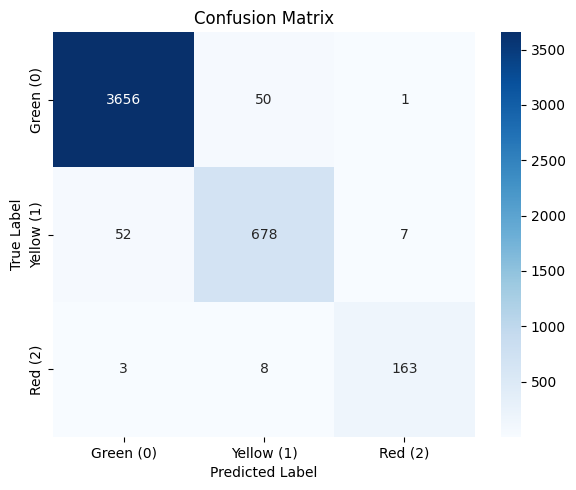

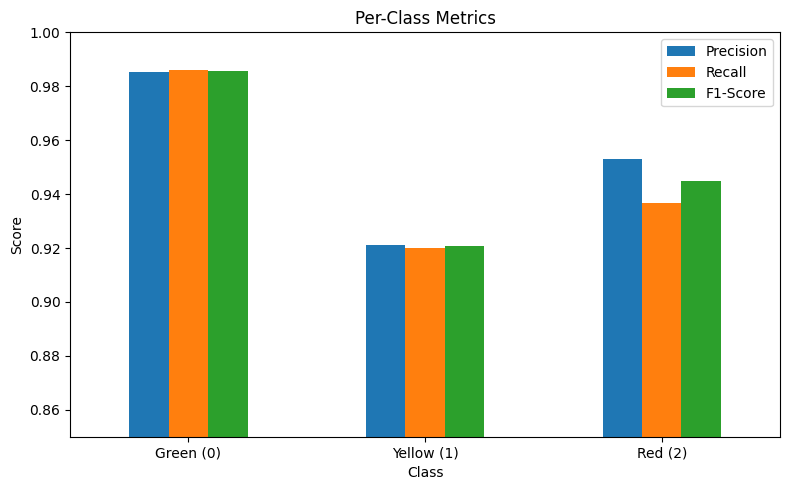

/tmp/ipykernel_105/3874323695.py:46: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(fn_counts.keys()), y=list(fn_counts.values()), palette="Reds")


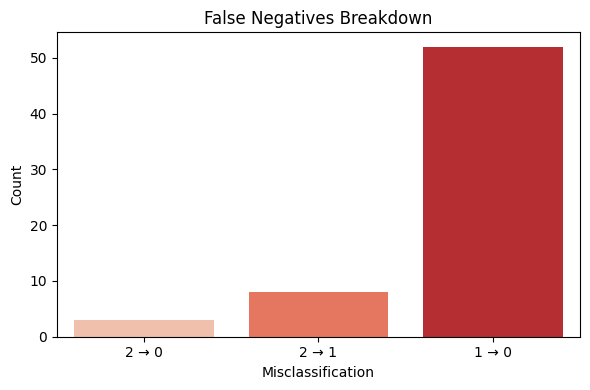

/tmp/ipykernel_105/3874323695.py:56: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=["Green (0)", "Yellow (1)", "Red (2)"], y=[weights[0], weights[1], weights[2]], palette="Greens")


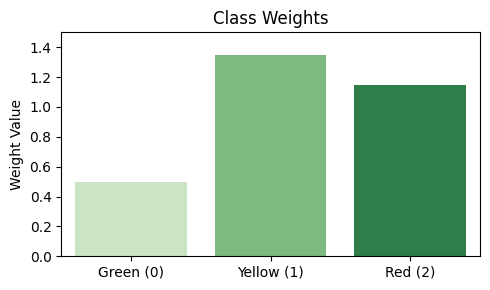